# Exploratory data analyses & normalization with `DeSeq2` in preparation for DGE analysis

## **Content**
### 1. Exploratory PCAs on TPM counts: 4 combinations
### 2. Exploratory PCAs on ELCs
### 3. Library size & log10 counts boxplot
### 4. Normalization with DeSeq2 / r-sleuth package
### 5. Confirming normalization efficiency with PCAs on TPM counts
### 6. Confirming normalization efficiency with PCAs on ELCs

In [3]:
library(DESeq2, warn.conflicts = FALSE)
library(sleuth, warn.conflicts = FALSE)
library(plyr, warn.conflicts = FALSE)
library(tidyverse, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(cowplot, warn.conflicts = FALSE)
library(vsn, warn.conflicts = FALSE)
library(hexbin, warn.conflicts = FALSE)
library(FactoMineR, warn.conflicts = FALSE)
library(factoextra, warn.conflicts = FALSE)
library(edgeR, warn.conflicts = FALSE)
library(RColorBrewer, warn.conflicts = FALSE)
library(viridis, warn.conflicts = FALSE)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Attaching package: ‘S4Vectors’

The followin

In [4]:
set.seed(42) # For reproducibility of results

In [5]:
# import count table
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
hord <- readRDS("barley_count_table_merged.rds")
h <- hord$counts
dim(h)
head(h)
# dimensions shows that a total of 193 samples were mapped to 49 281 genes of H.vulgare

[1] 49281   240

ERR781039 ERR781040 ERR781041 ERR781042 ERR781043
Horvu_MOREX_1H01G000100 336.0000  122.0000   66.0000  208.0000  354.000  
Horvu_MOREX_1H01G000200   1.0000    0.0000    0.0000    1.0000    1.000  
Horvu_MOREX_1H01G000300 116.0000   56.0000   45.0000   98.0000  108.000  
Horvu_MOREX_1H01G000400 550.0000  184.0000  133.0000  351.0000  549.000  
Horvu_MOREX_1H01G000500 556.0000  167.0000  116.0000  382.0000  511.000  
Horvu_MOREX_1H01G000600 707.3084  260.5543  146.4439  381.1077  572.695  
                        ERR781044 ERR781045 ERR781046 ERR781047 ERR781048 ⋯
Horvu_MOREX_1H01G000100 452.0000  388.0000  405.0000  359.0000   657.000  ⋯
Horvu_MOREX_1H01G000200   1.0000    1.0000    0.0000    0.0000     1.000  ⋯
Horvu_MOREX_1H01G000300 163.0000  160.0000  133.0000  117.0000   284.000  ⋯
Horvu_MOREX_1H01G000400 657.0000  577.0000  605.0000  540.0000  1183.000  ⋯
Horvu_MOREX_1H01G000500 635.0000  772.0000  607.0000  630.0000  1166.000  ⋯
Horvu_MOREX_1H01G000600 776.8168  827.0809  874.5452  566.1862  1397.799  ⋯
                        ERR515188 ERR515189 ERR515190 ERR515191 ERR515192
Horvu_MOREX_1H01G000100 1232.000  2237.000  1503.000  1833.000  1695.000 
Horvu_MOREX_1H01G000200    1.000     3.000    10.000     1.000     2.000 
Horvu_MOREX_1H01G000300  428.000   610.000   519.000   466.000   492.000 
Horvu_MOREX_1H01G000400  971.000  1640.000  1312.000  1160.000  2093.000 
Horvu_MOREX_1H01G000500 3656.000  4336.000  4734.000  4469.000  2296.000 
Horvu_MOREX_1H01G000600 2808.661  3316.393  2766.549  2833.275  2984.255 
                        ERR515193 ERR515194 ERR515195 ERR515196 ERR515197
Horvu_MOREX_1H01G000100 2477.000  2265.000  2578.000  2468.000  2317.000 
Horvu_MOREX_1H01G000200    8.000     6.000     0.000     2.000     2.000 
Horvu_MOREX_1H01G000300  652.000   569.000   677.000   710.000   584.000 
Horvu_MOREX_1H01G000400 2738.000  2795.000  3687.000  3044.000  3045.000 
Horvu_MOREX_1H01G000500 2418.000  2349.000  3908.000  3340.000  3221.000 
Horvu_MOREX_1H01G000600 4250.868  3915.629  4172.974  4106.843  4045.146

In [6]:
# import metadata
setwd("/home/vanda.marosi/floral_development_thesis_vm/datatables/")
# stringsAsfactors has to be truse for deseq2 design
barley_metadata <- read.table("barley_final.csv", header = TRUE, sep = ",", stringsAsFactors = TRUE)
barley_meta <- select(barley_metadata, Run.ID, Dataset, Batch, Cultivar, GM, Zadok_scale, Intermediate_age, High_level_age, Intermediate_tissue, High_level_tissue, Treatment, RNA_extraction, RNA_enrichment, RNA_input..microg., PCR_purification, Growth_condition, Day_night_condition, Temperature_day_night_c, Growth_location, Seq_location, Instrument, Library.layout)
colnames(barley_meta) <- c("ID", "dataset", "batch", "cultivar", "gm", "zadoc_scale", "intermediate_age", "high_level_age", "intermediate_tissue", "high_level_tissue", "treatment", "rna_extraction", "rna_enrichment", "rna_input", "pcr_purification", "growth_condition", "day_night", "temp", "growth_location", "seq_location", "instrument", "library")
# add rownames for deseq2 to identify rows with count-columns
rownames(barley_meta) <- barley_meta$ID
glimpse(barley_meta)
tail(barley_meta)

Rows: 240
Columns: 22
$ ID                  <fct> ERR781039, ERR781040, ERR781041, ERR781042, ERR78…
$ dataset             <fct> photoperiod_mutant_preanthesis, photoperiod_mutan…
$ batch               <int> 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5, 6, 6, 6…
$ cultivar            <fct> S42-IL107, S42-IL107, S42-IL107, Scarlett, Scarle…
$ gm                  <fct> wt, wt, wt, mut, mut, mut, wt, wt, wt, wt, wt, wt…
$ zadoc_scale         <int> 9, 9, 9, 11, 11, 11, 11, 11, 11, 29, 29, 29, 29, …
$ intermediate_age    <fct> Germination, Germination, Germination, Leaf_devel…
$ high_level_age      <fct> Seedling, Seedling, Seedling, Seedling, Seedling,…
$ intermediate_tissue <fct> apex, apex, apex, apex, apex, apex, apex, apex, a…
$ high_level_tissue   <fct> leaf, leaf, leaf, leaf, leaf, leaf, leaf, leaf, l…
$ treatment           <fct> control, control, control, mutant, mutant, mutant…
$ rna_extraction      <fct> trizol, trizol, trizol, trizol, trizol, trizol, t…
$ rna_enrichment      <fct> Rn

ID        dataset        batch cultivar gm  zadoc_scale
ERR515192 ERR515192 laxatum_mutant 75    Bowman   wt  45         
ERR515193 ERR515193 laxatum_mutant 75    Bowman   wt  45         
ERR515194 ERR515194 laxatum_mutant 75    Bowman   wt  45         
ERR515195 ERR515195 laxatum_mutant 76    Bowman   mut 45         
ERR515196 ERR515196 laxatum_mutant 76    Bowman   mut 45         
ERR515197 ERR515197 laxatum_mutant 76    Bowman   mut 45         
          intermediate_age high_level_age intermediate_tissue high_level_tissue
ERR515192 Booting          Reproductive   spike               inflorescence    
ERR515193 Booting          Reproductive   spike               inflorescence    
ERR515194 Booting          Reproductive   spike               inflorescence    
ERR515195 Booting          Reproductive   spike               inflorescence    
ERR515196 Booting          Reproductive   spike               inflorescence    
ERR515197 Booting          Reproductive   spike               inflorescence    
          ⋯ rna_enrichment rna_input pcr_purification growth_condition
ERR515192 ⋯ unknown        unknown   unknown          unknown         
ERR515193 ⋯ unknown        unknown   unknown          unknown         
ERR515194 ⋯ unknown        unknown   unknown          unknown         
ERR515195 ⋯ unknown        unknown   unknown          unknown         
ERR515196 ⋯ unknown        unknown   unknown          unknown         
ERR515197 ⋯ unknown        unknown   unknown          unknown         
          day_night temp    growth_location     seq_location       
ERR515192 unknown   unknown Germany_Gatersleben Germany_Gatersleben
ERR515193 unknown   unknown Germany_Gatersleben Germany_Gatersleben
ERR515194 unknown   unknown Germany_Gatersleben Germany_Gatersleben
ERR515195 unknown   unknown Germany_Gatersleben Germany_Gatersleben
ERR515196 unknown   unknown Germany_Gatersleben Germany_Gatersleben
ERR515197 unknown   unknown Germany_Gatersleben Germany_Gatersleben
          instrument          library
ERR515192 Illumina HiSeq 2000 paired 
ERR515193 Illumina HiSeq 2000 paired 
ERR515194 Illumina HiSeq 2000 paired 
ERR515195 Illumina HiSeq 2000 paired 
ERR515196 Illumina HiSeq 2000 paired 
ERR515197 Illumina HiSeq 2000 paired

### Subsetting categorical variables: 
* **technical variables:** "ID", "dataset", "batch", "rna_extraction", "rna_enrichment", "rna_input", "pcr_purification", "growth_condition", "day_night", "temp", "growth_location", "seq_location", "instrument", "library"
* **biological variables:** "cultivar", "gm", "treatment", "zadoc_scale", "intermediate_age", "high_level_age", "intermediate_tissue", "high_level_tissue",

In [7]:
# separate technical variables from metadata
barley_tech_meta <- select(barley_meta, ID, dataset, batch, rna_extraction, rna_enrichment, rna_input, pcr_purification, growth_condition, day_night, temp, growth_location, seq_location, instrument, library)

In [8]:
# separate biological variables from metadata
barley_bio_meta <- select(barley_meta, ID, dataset, cultivar, gm, treatment, zadoc_scale, intermediate_age, high_level_age, intermediate_tissue, high_level_tissue)

In [9]:
# mixed most important variables from metadata
barley_mix_meta <- select(barley_meta, ID, dataset, instrument, library, intermediate_age, high_level_age, intermediate_tissue, high_level_tissue)

# 1. Exploratory analysis with PCAs
* in my exploratory analysis unscaled PCAs are performed using raw and filtered & log10-transformed count tables to see the effect of batches and other different technical variables that can be used for the model of variance stabilization

## 1.1 PCA on raw TPM counts without filtering using `FactoMineR` and `factoextra`

In [10]:
dim(h)
# switching rows to columns
cnt <- t(h)
cnt <- as.data.frame(cnt, stringsAsFactors = TRUE)
# adding rownames=ID as a column
cnt <- cbind(ID = rownames(cnt), cnt)
rownames(cnt) <- cnt$ID
dim(cnt)
head(cnt)

[1] 49281   240

[1]   240 49282

ID        Horvu_MOREX_1H01G000100 Horvu_MOREX_1H01G000200
ERR781039 ERR781039 336                     1                      
ERR781040 ERR781040 122                     0                      
ERR781041 ERR781041  66                     0                      
ERR781042 ERR781042 208                     1                      
ERR781043 ERR781043 354                     1                      
ERR781044 ERR781044 452                     1                      
          Horvu_MOREX_1H01G000300 Horvu_MOREX_1H01G000400
ERR781039 116                     550                    
ERR781040  56                     184                    
ERR781041  45                     133                    
ERR781042  98                     351                    
ERR781043 108                     549                    
ERR781044 163                     657                    
          Horvu_MOREX_1H01G000500 Horvu_MOREX_1H01G000600
ERR781039 556                     707.3084               
ERR781040 167                     260.5543               
ERR781041 116                     146.4439               
ERR781042 382                     381.1077               
ERR781043 511                     572.6950               
ERR781044 635                     776.8168               
          Horvu_MOREX_1H01G000700 Horvu_MOREX_1H01G000800
ERR781039 351.0000                368                    
ERR781040 111.9312                129                    
ERR781041  52.0000                 60                    
ERR781042 189.9432                198                    
ERR781043 314.0000                360                    
ERR781044 362.7905                399                    
          Horvu_MOREX_1H01G000900 ⋯ Horvu_MOREX_Un01G109700
ERR781039 72                      ⋯ 0                      
ERR781040 20                      ⋯ 0                      
ERR781041 11                      ⋯ 0                      
ERR781042 39                      ⋯ 1                      
ERR781043 48                      ⋯ 0                      
ERR781044 68                      ⋯ 0                      
          Horvu_MOREX_Un01G109800 Horvu_MOREX_Un01G109900
ERR781039 2.759218                0.000000               
ERR781040 5.793865                0.000000               
ERR781041 0.000000                0.000000               
ERR781042 0.000000                1.507178               
ERR781043 2.717011                2.544734               
ERR781044 2.957741                0.000000               
          Horvu_MOREX_Un01G110000 Horvu_MOREX_Un01G110100
ERR781039 7.619365                2                      
ERR781040 0.000000                0                      
ERR781041 0.000000                1                      
ERR781042 5.928367                0                      
ERR781043 4.332308                0                      
ERR781044 0.000000                0                      
          Horvu_MOREX_Un01G110200 Horvu_MOREX_Un01G110300
ERR781039 0                       1                      
ERR781040 0                       0                      
ERR781041 0                       0                      
ERR781042 0                       0                      
ERR781043 0                       0                      
ERR781044 0                       0                      
          Horvu_MOREX_Un01G110400 Horvu_MOREX_Un01G110500
ERR781039 0                       0.1512110              
ERR781040 0                       2.5000000              
ERR781041 0                       0.0000000              
ERR781042 0                       0.8098828              
ERR781043 0                       0.6214817              
ERR781044 0                       1.1231197              
          Horvu_MOREX_Un01G110600
ERR781039 0.00000000             
ERR781040 0.03942593             
ERR781041 0.00000000             
ERR781042 0.00000000             
ERR781043 0.00000000             
ERR781044 0.00000000

In [11]:
# include metadata table
cnt_meta <- inner_join(barley_tech_meta, cnt, by = "ID")
# add rownames again
rownames(cnt_meta) <- cnt_meta$ID
dim(cnt_meta)
head(cnt_meta)

[1]   240 49295

ID        dataset                        batch rna_extraction
ERR781039 ERR781039 photoperiod_mutant_preanthesis 1     trizol        
ERR781040 ERR781040 photoperiod_mutant_preanthesis 1     trizol        
ERR781041 ERR781041 photoperiod_mutant_preanthesis 1     trizol        
ERR781042 ERR781042 photoperiod_mutant_preanthesis 2     trizol        
ERR781043 ERR781043 photoperiod_mutant_preanthesis 2     trizol        
ERR781044 ERR781044 photoperiod_mutant_preanthesis 2     trizol        
          rna_enrichment         rna_input pcr_purification growth_condition
ERR781039 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781040 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781041 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781042 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781043 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781044 Rneasy_microkit_Qiagen unknown   unknown          incubator       
          day_night temp  ⋯ Horvu_MOREX_Un01G109700 Horvu_MOREX_Un01G109800
ERR781039 8_16      22_18 ⋯ 0                       2.759218               
ERR781040 8_16      22_18 ⋯ 0                       5.793865               
ERR781041 8_16      22_18 ⋯ 0                       0.000000               
ERR781042 16_8      22_18 ⋯ 1                       0.000000               
ERR781043 16_8      22_18 ⋯ 0                       2.717011               
ERR781044 16_8      22_18 ⋯ 0                       2.957741               
          Horvu_MOREX_Un01G109900 Horvu_MOREX_Un01G110000
ERR781039 0.000000                7.619365               
ERR781040 0.000000                0.000000               
ERR781041 0.000000                0.000000               
ERR781042 1.507178                5.928367               
ERR781043 2.544734                4.332308               
ERR781044 0.000000                0.000000               
          Horvu_MOREX_Un01G110100 Horvu_MOREX_Un01G110200
ERR781039 2                       0                      
ERR781040 0                       0                      
ERR781041 1                       0                      
ERR781042 0                       0                      
ERR781043 0                       0                      
ERR781044 0                       0                      
          Horvu_MOREX_Un01G110300 Horvu_MOREX_Un01G110400
ERR781039 1                       0                      
ERR781040 0                       0                      
ERR781041 0                       0                      
ERR781042 0                       0                      
ERR781043 0                       0                      
ERR781044 0                       0                      
          Horvu_MOREX_Un01G110500 Horvu_MOREX_Un01G110600
ERR781039 0.1512110               0.00000000             
ERR781040 2.5000000               0.03942593             
ERR781041 0.0000000               0.00000000             
ERR781042 0.8098828               0.00000000             
ERR781043 0.6214817               0.00000000             
ERR781044 1.1231197               0.00000000

#### Prepare dataset for `FactoMineR`
* check on classes
* to deal with missing values:

By default, missing values in FactoMineR are replaced by the mean of each variable which is not a very proper and convenient way to deal with missing values, especially when there are a lot of them in your dataset. We have implemented a package missMDA to deal with missing values in PCA, in CA, in MCA, in FAMD, and in MFA.

In [12]:
# convert variables which are not factor into factor that they could be part of pca
cnt_meta$rna_input<-factor(cnt_meta$rna_input)
cnt_meta$batch<-factor(cnt_meta$batch)
class(cnt_meta$rna_input)
class(cnt_meta$batch)
# change factor levels where extra levels are present from single dataset: inf_dev & tf_q for dataset, 21 for temp
cnt_meta <- droplevels(cnt_meta)
# delete ID column to not have it as extra supplementary variable
cnt_meta <- select(cnt_meta, -ID)
head(cnt_meta)

[1] "factor"

[1] "factor"

dataset                        batch rna_extraction
ERR781039 photoperiod_mutant_preanthesis 1     trizol        
ERR781040 photoperiod_mutant_preanthesis 1     trizol        
ERR781041 photoperiod_mutant_preanthesis 1     trizol        
ERR781042 photoperiod_mutant_preanthesis 2     trizol        
ERR781043 photoperiod_mutant_preanthesis 2     trizol        
ERR781044 photoperiod_mutant_preanthesis 2     trizol        
          rna_enrichment         rna_input pcr_purification growth_condition
ERR781039 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781040 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781041 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781042 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781043 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781044 Rneasy_microkit_Qiagen unknown   unknown          incubator       
          day_night temp  growth_location ⋯ Horvu_MOREX_Un01G109700
ERR781039 8_16      22_18 Germany         ⋯ 0                      
ERR781040 8_16      22_18 Germany         ⋯ 0                      
ERR781041 8_16      22_18 Germany         ⋯ 0                      
ERR781042 16_8      22_18 Germany         ⋯ 1                      
ERR781043 16_8      22_18 Germany         ⋯ 0                      
ERR781044 16_8      22_18 Germany         ⋯ 0                      
          Horvu_MOREX_Un01G109800 Horvu_MOREX_Un01G109900
ERR781039 2.759218                0.000000               
ERR781040 5.793865                0.000000               
ERR781041 0.000000                0.000000               
ERR781042 0.000000                1.507178               
ERR781043 2.717011                2.544734               
ERR781044 2.957741                0.000000               
          Horvu_MOREX_Un01G110000 Horvu_MOREX_Un01G110100
ERR781039 7.619365                2                      
ERR781040 0.000000                0                      
ERR781041 0.000000                1                      
ERR781042 5.928367                0                      
ERR781043 4.332308                0                      
ERR781044 0.000000                0                      
          Horvu_MOREX_Un01G110200 Horvu_MOREX_Un01G110300
ERR781039 0                       1                      
ERR781040 0                       0                      
ERR781041 0                       0                      
ERR781042 0                       0                      
ERR781043 0                       0                      
ERR781044 0                       0                      
          Horvu_MOREX_Un01G110400 Horvu_MOREX_Un01G110500
ERR781039 0                       0.1512110              
ERR781040 0                       2.5000000              
ERR781041 0                       0.0000000              
ERR781042 0                       0.8098828              
ERR781043 0                       0.6214817              
ERR781044 0                       1.1231197              
          Horvu_MOREX_Un01G110600
ERR781039 0.00000000             
ERR781040 0.03942593             
ERR781041 0.00000000             
ERR781042 0.00000000             
ERR781043 0.00000000             
ERR781044 0.00000000

In [13]:
# create classes to check on class types -> pca can handle supplementary variables only as factors!
classes <- sapply(X = cnt_meta, FUN = class)
table(classes)
which(classes == 'factor')
# it is important to define NAs for missing values and check on factor levels! do this once in the analysis
#table(cnt_meta$dataset, useNA = "always") and so on..

classes
 factor numeric 
     13   49281 

dataset            batch   rna_extraction   rna_enrichment 
               1                2                3                4 
       rna_input pcr_purification growth_condition        day_night 
               5                6                7                8 
            temp  growth_location     seq_location       instrument 
               9               10               11               12 
         library 
              13

# 1.1 UNscaled PCA on raw & not-filtered TPM counts

In [14]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 100)
raw_pca <- PCA(X = cnt_meta, scale.unit = FALSE, ncp = 4, quali.sup = c(1:13), graph = F)
#summary(raw_pca)

eigenvalue   percentage of variance cumulative percentage of variance
comp 1 105338946913 30.949514              30.94951                         
comp 2  60581703814 17.799440              48.74895                         
comp 3  39840159076 11.705391              60.45435                         
comp 4  29838481248  8.766810              69.22116                         
comp 5  22804757196  6.700239              75.92139                         
comp 6  19753476892  5.803746              81.72514

Warning message in brewer.pal(18, "Paired"):
“n too large, allowed maximum for palette Paired is 12
Returning the palette you asked for with that many colors
”

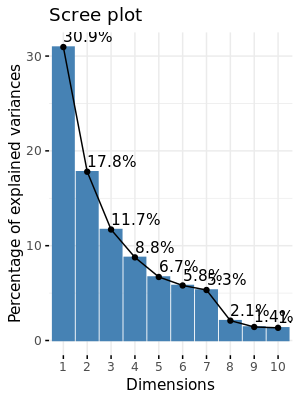

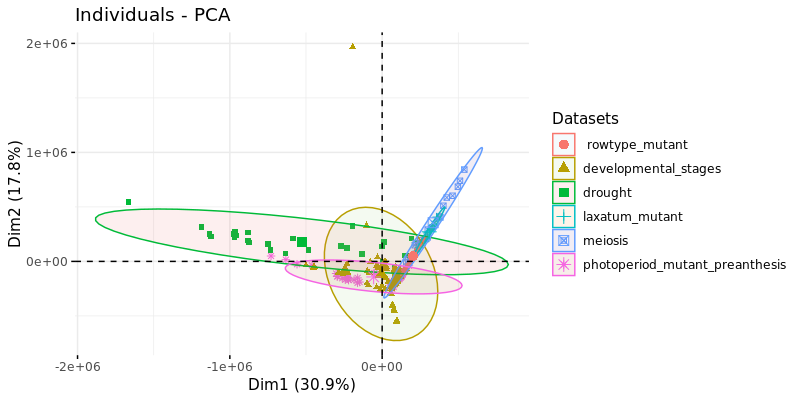

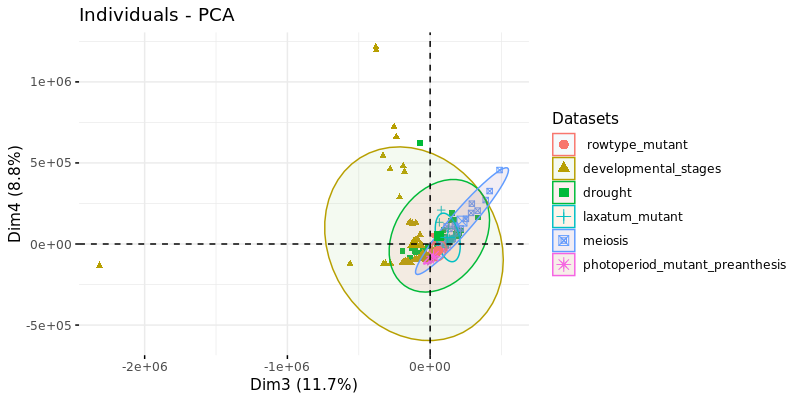

In [15]:
options(repr.plot.width = 3, repr.plot.height = 4, repr.plot.res = 100)
# display eigenvalues
head(raw_pca$eig)
# display scree plot
fviz_eig(raw_pca, addlabels = TRUE)
# display individuals (samples) colored by technical variable
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 100)
colourCount = length(unique(cnt_meta$dataset))
getPalette = colorRampPalette(brewer.pal(18, "Paired"))
fviz_pca_ind(X = raw_pca, label = "none", legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2), habillage = cnt_meta$dataset) +
                scale_fill_manual(values = getPalette(colourCount))
fviz_pca_ind(X = raw_pca, label = "none", legend.title = "Datasets", addEllipses = TRUE, axes = c(3, 4), habillage = cnt_meta$dataset) +
                scale_fill_manual(values = getPalette(colourCount))

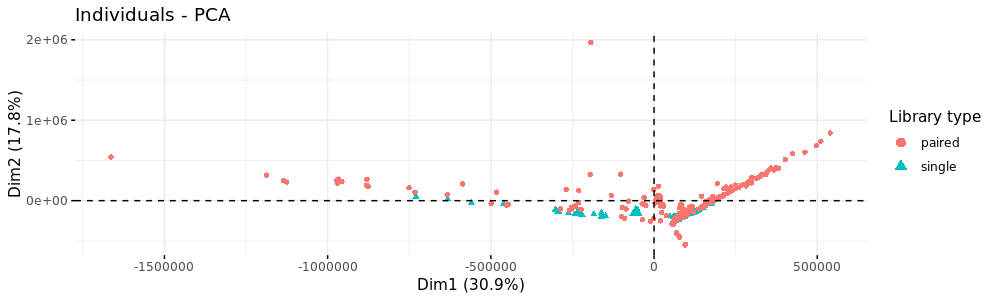

In [16]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 100)
fviz_pca_ind(X = raw_pca, geom="point", axes = c(1, 2), legend.title = "Library type", habillage = cnt_meta$library)

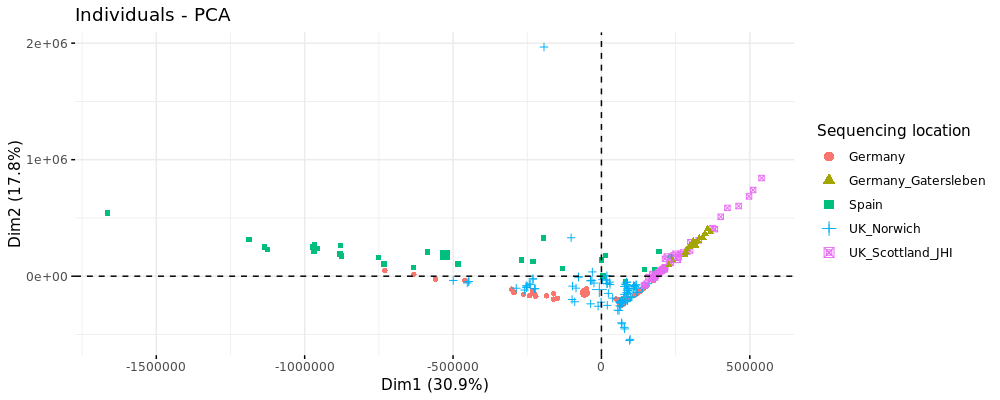

In [17]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 100)
fviz_pca_ind(X = raw_pca, geom="point", axes= c(1,2), legend.title = "Sequencing location", habillage = cnt_meta$seq_location)

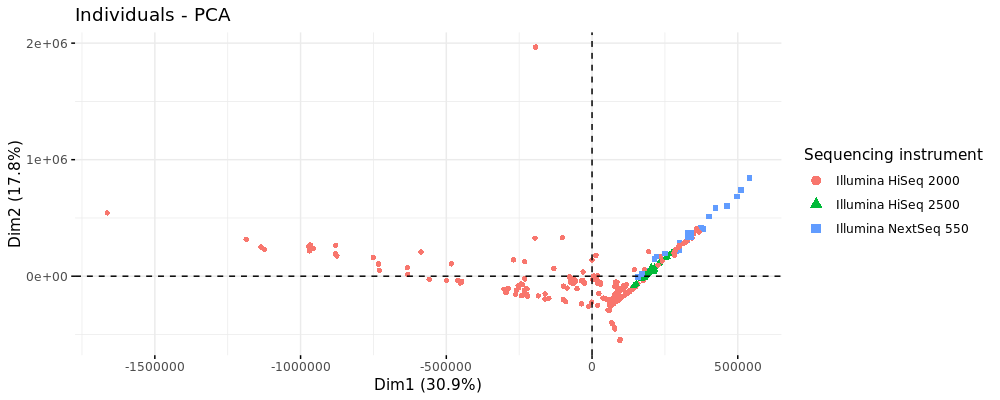

In [18]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 100)
fviz_pca_ind(X = raw_pca, geom="point", axes = c(1,2), legend.title = "Sequencing instrument", habillage = cnt_meta$instrument)

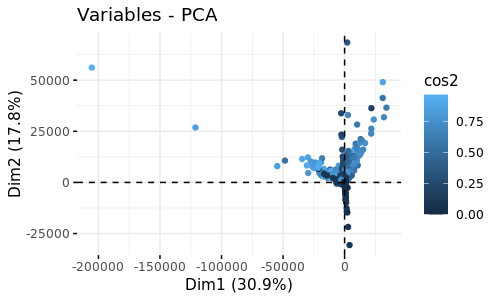

In [19]:
# display variables (genes) colored by quality
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 100)
fviz_pca_var(X = raw_pca, col.var = "cos2", axes = 1:2, label = "none", geom = "point")

# 1.2 **Scaled & centered** PCA on raw & not-filtered TPM counts

In [20]:
# scaling and centering data
dim(h)
cnt <- as.data.frame(h, stringsAsFactors = FALSE)
# filter out zero variance genes that would cause a problem for scaling and centering
filter_cnt <- cnt[(rowSums(cnt)>0), ]
#filter_cnt <- filter_cnt+1
dim(filter_cnt)
# switching columns to rows
switched_cnt_df <- t(filter_cnt)
# scaling and centering
cnt_scaled <- scale(switched_cnt_df, center = TRUE, scale = TRUE)
cnt_scaled <- cnt_scaled+1
# adding rownames=ID as a column
cnt_scaled <- as.data.frame(cnt_scaled, stringsAsFactors = TRUE)
cnt_scaled <- cbind(ID = rownames(cnt_scaled), cnt_scaled)
rownames(cnt_scaled) <- cnt_scaled$ID
dim(cnt_scaled)
head(cnt_scaled)

[1] 49281   240

[1] 46243   240

[1]   240 46244

ID        Horvu_MOREX_1H01G000100 Horvu_MOREX_1H01G000200
ERR781039 ERR781039  0.07977662             0.6218743              
ERR781040 ERR781040 -0.12851156             0.6193724              
ERR781041 ERR781041 -0.18301688             0.6193724              
ERR781042 ERR781042 -0.04480697             0.6218743              
ERR781043 ERR781043  0.09729619             0.6218743              
ERR781044 ERR781044  0.19268050             0.6218743              
          Horvu_MOREX_1H01G000300 Horvu_MOREX_1H01G000400
ERR781039 0.3822245               0.6772662              
ERR781040 0.2493021               0.2321300              
ERR781041 0.2249330               0.1701029              
ERR781042 0.3423478               0.4352386              
ERR781043 0.3645015               0.6760500              
ERR781044 0.4863471               0.8074016              
          Horvu_MOREX_1H01G000500 Horvu_MOREX_1H01G000600
ERR781039  0.22492253              0.49599998            
ERR781040  0.01445693              0.07326091            
ERR781041 -0.01313625             -0.03471563            
ERR781042  0.13078111              0.18733400            
ERR781043  0.20057561              0.36862265            
ERR781044  0.26766491              0.56177204            
          Horvu_MOREX_1H01G000700 Horvu_MOREX_1H01G000800
ERR781039 0.4015209                0.07851779            
ERR781040 0.1821944               -0.23594720            
ERR781041 0.1272124               -0.32673417            
ERR781042 0.2537642               -0.14516024            
ERR781043 0.3675764                0.06799177            
ERR781044 0.4123377                0.11930614            
          Horvu_MOREX_1H01G000900 ⋯ Horvu_MOREX_Un01G109600
ERR781039 0.7011648               ⋯ 0.8540393              
ERR781040 0.3139294               ⋯ 0.8540393              
ERR781041 0.2469079               ⋯ 0.8540393              
ERR781042 0.4554193               ⋯ 0.8540393              
ERR781043 0.5224408               ⋯ 0.8540393              
ERR781044 0.6713774               ⋯ 0.8540393              
          Horvu_MOREX_Un01G109700 Horvu_MOREX_Un01G109800
ERR781039 0.8013742               0.8206366              
ERR781040 0.8013742               0.9634882              
ERR781041 0.8013742               0.6907505              
ERR781042 1.8417645               0.6907505              
ERR781043 0.8013742               0.8186498              
ERR781044 0.8013742               0.8299818              
          Horvu_MOREX_Un01G109900 Horvu_MOREX_Un01G110000
ERR781039 0.5904898               0.8581443              
ERR781040 0.5904898               0.8005380              
ERR781041 0.5904898               0.8005380              
ERR781042 1.0264710               0.8453595              
ERR781043 1.3266047               0.8332924              
ERR781044 0.5904898               0.8005380              
          Horvu_MOREX_Un01G110100 Horvu_MOREX_Un01G110300
ERR781039 0.7193219               0.7813962              
ERR781040 0.5454926               0.7576346              
ERR781041 0.6324073               0.7576346              
ERR781042 0.5454926               0.7576346              
ERR781043 0.5454926               0.7576346              
ERR781044 0.5454926               0.7576346              
          Horvu_MOREX_Un01G110400 Horvu_MOREX_Un01G110500
ERR781039 0.7877584               0.4229204              
ERR781040 0.7877584               1.3982525              
ERR781041 0.7877584               0.3601303              
ERR781042 0.7877584               0.6964332              
ERR781043 0.7877584               0.6181999              
ERR781044 0.7877584               0.8265045              
          Horvu_MOREX_Un01G110600
ERR781039 0.8308936              
ERR781040 0.9779606              
ERR781041 0.8308936              
ERR781042 0.8308936              
ERR781043 0.8308936              
ERR781044 0.8308936

In [21]:
# include metadata table
cnt_meta_scaled <- inner_join(barley_tech_meta, cnt_scaled, by = "ID")
# add rownames again
rownames(cnt_meta_scaled) <- cnt_meta_scaled$ID
dim(cnt_meta_scaled)
head(cnt_meta_scaled)

[1]   240 46257

ID        dataset                        batch rna_extraction
ERR781039 ERR781039 photoperiod_mutant_preanthesis 1     trizol        
ERR781040 ERR781040 photoperiod_mutant_preanthesis 1     trizol        
ERR781041 ERR781041 photoperiod_mutant_preanthesis 1     trizol        
ERR781042 ERR781042 photoperiod_mutant_preanthesis 2     trizol        
ERR781043 ERR781043 photoperiod_mutant_preanthesis 2     trizol        
ERR781044 ERR781044 photoperiod_mutant_preanthesis 2     trizol        
          rna_enrichment         rna_input pcr_purification growth_condition
ERR781039 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781040 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781041 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781042 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781043 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781044 Rneasy_microkit_Qiagen unknown   unknown          incubator       
          day_night temp  ⋯ Horvu_MOREX_Un01G109600 Horvu_MOREX_Un01G109700
ERR781039 8_16      22_18 ⋯ 0.8540393               0.8013742              
ERR781040 8_16      22_18 ⋯ 0.8540393               0.8013742              
ERR781041 8_16      22_18 ⋯ 0.8540393               0.8013742              
ERR781042 16_8      22_18 ⋯ 0.8540393               1.8417645              
ERR781043 16_8      22_18 ⋯ 0.8540393               0.8013742              
ERR781044 16_8      22_18 ⋯ 0.8540393               0.8013742              
          Horvu_MOREX_Un01G109800 Horvu_MOREX_Un01G109900
ERR781039 0.8206366               0.5904898              
ERR781040 0.9634882               0.5904898              
ERR781041 0.6907505               0.5904898              
ERR781042 0.6907505               1.0264710              
ERR781043 0.8186498               1.3266047              
ERR781044 0.8299818               0.5904898              
          Horvu_MOREX_Un01G110000 Horvu_MOREX_Un01G110100
ERR781039 0.8581443               0.7193219              
ERR781040 0.8005380               0.5454926              
ERR781041 0.8005380               0.6324073              
ERR781042 0.8453595               0.5454926              
ERR781043 0.8332924               0.5454926              
ERR781044 0.8005380               0.5454926              
          Horvu_MOREX_Un01G110300 Horvu_MOREX_Un01G110400
ERR781039 0.7813962               0.7877584              
ERR781040 0.7576346               0.7877584              
ERR781041 0.7576346               0.7877584              
ERR781042 0.7576346               0.7877584              
ERR781043 0.7576346               0.7877584              
ERR781044 0.7576346               0.7877584              
          Horvu_MOREX_Un01G110500 Horvu_MOREX_Un01G110600
ERR781039 0.4229204               0.8308936              
ERR781040 1.3982525               0.9779606              
ERR781041 0.3601303               0.8308936              
ERR781042 0.6964332               0.8308936              
ERR781043 0.6181999               0.8308936              
ERR781044 0.8265045               0.8308936

In [22]:
# convert variables which are not factor into factor that they could be part of pca
cnt_meta_scaled$rna_input<-factor(cnt_meta_scaled$rna_input)
cnt_meta_scaled$batch<-factor(cnt_meta_scaled$batch)
class(cnt_meta_scaled$rna_input)
class(cnt_meta_scaled$batch)
# change factor levels where extra levels are present from single dataset: inf_dev & tf_q for dataset, 21 for temp
cnt_meta_scaled <- droplevels(cnt_meta_scaled)
# delete ID column to not have it as extra supplementary variable
cnt_meta_scaled <- select(cnt_meta_scaled, -ID)
head(cnt_meta_scaled)

[1] "factor"

[1] "factor"

dataset                        batch rna_extraction
ERR781039 photoperiod_mutant_preanthesis 1     trizol        
ERR781040 photoperiod_mutant_preanthesis 1     trizol        
ERR781041 photoperiod_mutant_preanthesis 1     trizol        
ERR781042 photoperiod_mutant_preanthesis 2     trizol        
ERR781043 photoperiod_mutant_preanthesis 2     trizol        
ERR781044 photoperiod_mutant_preanthesis 2     trizol        
          rna_enrichment         rna_input pcr_purification growth_condition
ERR781039 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781040 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781041 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781042 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781043 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781044 Rneasy_microkit_Qiagen unknown   unknown          incubator       
          day_night temp  growth_location ⋯ Horvu_MOREX_Un01G109600
ERR781039 8_16      22_18 Germany         ⋯ 0.8540393              
ERR781040 8_16      22_18 Germany         ⋯ 0.8540393              
ERR781041 8_16      22_18 Germany         ⋯ 0.8540393              
ERR781042 16_8      22_18 Germany         ⋯ 0.8540393              
ERR781043 16_8      22_18 Germany         ⋯ 0.8540393              
ERR781044 16_8      22_18 Germany         ⋯ 0.8540393              
          Horvu_MOREX_Un01G109700 Horvu_MOREX_Un01G109800
ERR781039 0.8013742               0.8206366              
ERR781040 0.8013742               0.9634882              
ERR781041 0.8013742               0.6907505              
ERR781042 1.8417645               0.6907505              
ERR781043 0.8013742               0.8186498              
ERR781044 0.8013742               0.8299818              
          Horvu_MOREX_Un01G109900 Horvu_MOREX_Un01G110000
ERR781039 0.5904898               0.8581443              
ERR781040 0.5904898               0.8005380              
ERR781041 0.5904898               0.8005380              
ERR781042 1.0264710               0.8453595              
ERR781043 1.3266047               0.8332924              
ERR781044 0.5904898               0.8005380              
          Horvu_MOREX_Un01G110100 Horvu_MOREX_Un01G110300
ERR781039 0.7193219               0.7813962              
ERR781040 0.5454926               0.7576346              
ERR781041 0.6324073               0.7576346              
ERR781042 0.5454926               0.7576346              
ERR781043 0.5454926               0.7576346              
ERR781044 0.5454926               0.7576346              
          Horvu_MOREX_Un01G110400 Horvu_MOREX_Un01G110500
ERR781039 0.7877584               0.4229204              
ERR781040 0.7877584               1.3982525              
ERR781041 0.7877584               0.3601303              
ERR781042 0.7877584               0.6964332              
ERR781043 0.7877584               0.6181999              
ERR781044 0.7877584               0.8265045              
          Horvu_MOREX_Un01G110600
ERR781039 0.8308936              
ERR781040 0.9779606              
ERR781041 0.8308936              
ERR781042 0.8308936              
ERR781043 0.8308936              
ERR781044 0.8308936

In [23]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 100)
raw_pca_scaled <- PCA(X = cnt_meta_scaled, scale.unit = FALSE, ncp = 4, quali.sup = c(1:13), graph = F)
#summary(raw_pca_scaled)

eigenvalue percentage of variance cumulative percentage of variance
comp 1 9670.024   20.998821              20.99882                         
comp 2 4097.392    8.897639              29.89646                         
comp 3 2914.931    6.329883              36.22634                         
comp 4 2272.507    4.934834              41.16118                         
comp 5 1572.643    3.415054              44.57623                         
comp 6 1379.082    2.994729              47.57096

Warning message in brewer.pal(18, "Paired"):
“n too large, allowed maximum for palette Paired is 12
Returning the palette you asked for with that many colors
”

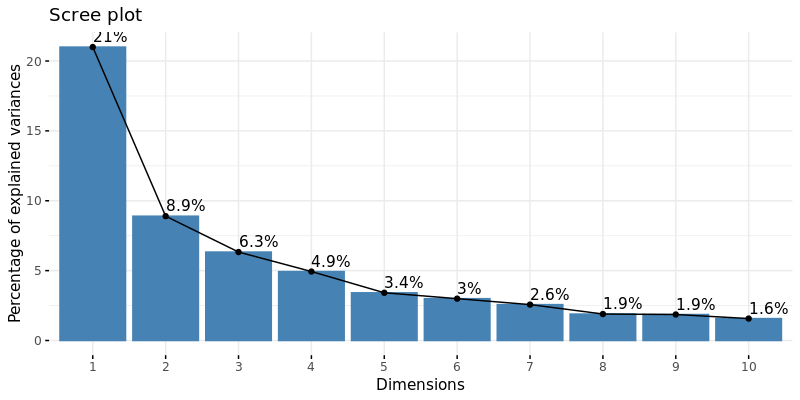

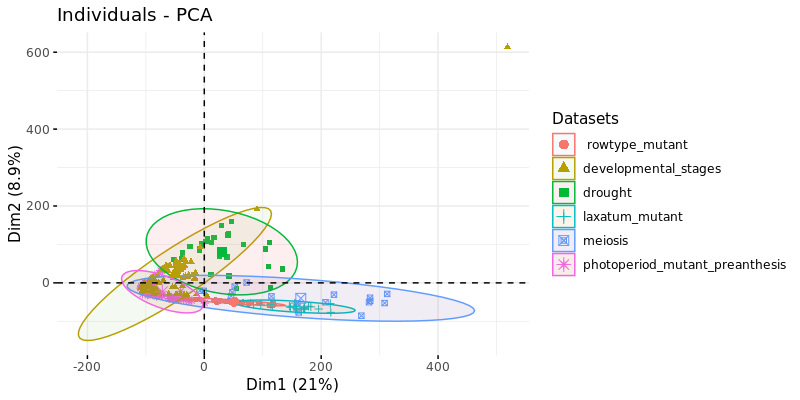

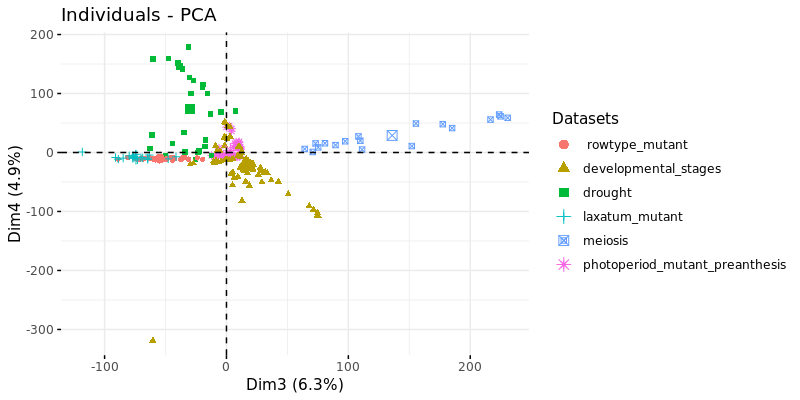

In [24]:
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 100)
# display eigenvalues
head(raw_pca_scaled$eig)
# display scree plot
fviz_eig(raw_pca_scaled, addlabels = TRUE)
# display individuals (samples) colored by technical variable
colourCount = length(unique(cnt_meta_scaled$dataset))
getPalette = colorRampPalette(brewer.pal(18, "Paired"))
fviz_pca_ind(X = raw_pca_scaled, label = "none", legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2), habillage = cnt_meta_scaled$dataset) +
                scale_fill_manual(values = getPalette(colourCount))
fviz_pca_ind(X = raw_pca_scaled, label = "none", labelsize = 0.4, legend.title = "Datasets", axes = c(3, 4), habillage = cnt_meta_scaled$dataset) +
                scale_fill_manual(values = getPalette(colourCount))

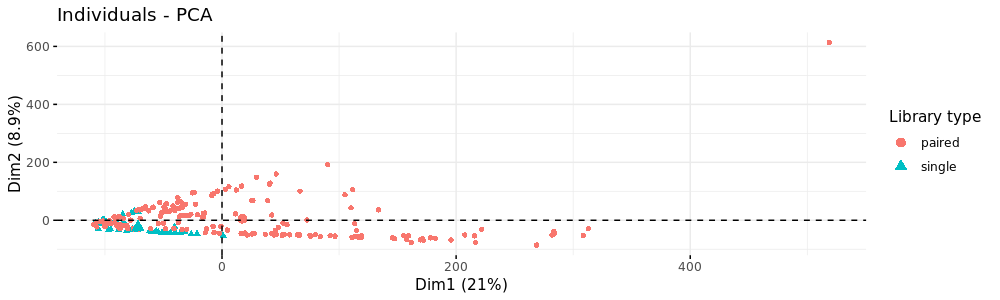

In [25]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 100)
fviz_pca_ind(X = raw_pca_scaled, geom="point", axes = c(1, 2), legend.title = "Library type", habillage = cnt_meta$library)

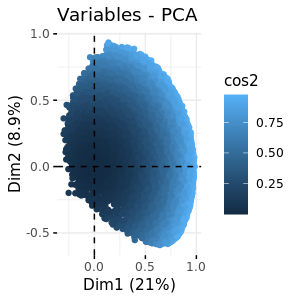

In [26]:
# display variables (genes) colored by quality
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 100)
fviz_pca_var(X = raw_pca_scaled, col.var = "cos2", axes = 1:2, label = "none", geom = "point")

# 1.3. PCA on filtered & log2-transformed TPM counts
### 1.3.1 Filtering out ribosomal-mitochondrial-chloroplast genes to avoid their overrepresentation:
These genes were by default not present in the reference transcriptomes.
Daniel's practice is to filter for: human genome, E.coli, common (wheat) pathogens such as Fusarium, Pseudomonas, Xanthomonas, mitochondrial-ribosomal-chloroplast genes
### 1.3.2 Filter out all genes that have no reads in any of the experiments:

In [27]:
filter_cnt <- h[(rowSums(h)>0), ]
dim(filter_cnt)
# dimensions shows that my 180 samples are successfully mapped with exisiting transcripts to 122 025 genes of T.aestivum

[1] 46243   240

### 1.3.3 Filtering to remove lowly expressed genes
* source: https://combine-australia.github.io/RNAseq-R/06-rnaseq-day1.html

Genes with very low counts across all libraries provide little evidence for differential expression and they interfere with some of the statistical approximations that are used later in the pipeline. They also add to the multiple testing burden when estimating false discovery rates, reducing power to detect differentially expressed genes. These genes should be filtered out prior to further analysis.

When there are biological replicates in each group, in this case we have a minimum sample size of 2 in each group, so we favour filtering on a minimum transcripts per million threshold present in at least 2 samples. We choose to retain genes if they are expressed at a transcripts-per-million (TPM) above 0.5 in at least 2 samples.

* **how to choose ideal cutoff (from above mentioned source):** A TPM of 0.5 is used as it corresponds to a count of 10-15 for the library sizes in this data set. If the count is any smaller, it is considered to be very low, indicating that the associated gene is not expressed in that sample. A requirement for expression in two or more libraries is used as each group contains two replicates. This ensures that a gene will be retained if it is only expressed in one group. Smaller TPM thresholds are usually appropriate for larger libraries. As a general rule, a good threshold can be chosen by identifying the TPM that corresponds to a count of 10, which in this case is about 0.5. You should filter with TPMs rather than filtering on the counts directly, as the latter does not account for differences in library sizes between samples.

In [28]:
# which value in my TPMs are greater than 0.5?
thresh <- filter_cnt >= 0.5
# this gives a logical matrix
head(thresh)

ERR781039 ERR781040 ERR781041 ERR781042 ERR781043
Horvu_MOREX_1H01G000100 TRUE       TRUE      TRUE     TRUE      TRUE     
Horvu_MOREX_1H01G000200 TRUE      FALSE     FALSE     TRUE      TRUE     
Horvu_MOREX_1H01G000300 TRUE       TRUE      TRUE     TRUE      TRUE     
Horvu_MOREX_1H01G000400 TRUE       TRUE      TRUE     TRUE      TRUE     
Horvu_MOREX_1H01G000500 TRUE       TRUE      TRUE     TRUE      TRUE     
Horvu_MOREX_1H01G000600 TRUE       TRUE      TRUE     TRUE      TRUE     
                        ERR781044 ERR781045 ERR781046 ERR781047 ERR781048 ⋯
Horvu_MOREX_1H01G000100 TRUE      TRUE       TRUE      TRUE     TRUE      ⋯
Horvu_MOREX_1H01G000200 TRUE      TRUE      FALSE     FALSE     TRUE      ⋯
Horvu_MOREX_1H01G000300 TRUE      TRUE       TRUE      TRUE     TRUE      ⋯
Horvu_MOREX_1H01G000400 TRUE      TRUE       TRUE      TRUE     TRUE      ⋯
Horvu_MOREX_1H01G000500 TRUE      TRUE       TRUE      TRUE     TRUE      ⋯
Horvu_MOREX_1H01G000600 TRUE      TRUE       TRUE      TRUE     TRUE      ⋯
                        ERR515188 ERR515189 ERR515190 ERR515191 ERR515192
Horvu_MOREX_1H01G000100 TRUE      TRUE      TRUE      TRUE      TRUE     
Horvu_MOREX_1H01G000200 TRUE      TRUE      TRUE      TRUE      TRUE     
Horvu_MOREX_1H01G000300 TRUE      TRUE      TRUE      TRUE      TRUE     
Horvu_MOREX_1H01G000400 TRUE      TRUE      TRUE      TRUE      TRUE     
Horvu_MOREX_1H01G000500 TRUE      TRUE      TRUE      TRUE      TRUE     
Horvu_MOREX_1H01G000600 TRUE      TRUE      TRUE      TRUE      TRUE     
                        ERR515193 ERR515194 ERR515195 ERR515196 ERR515197
Horvu_MOREX_1H01G000100 TRUE      TRUE       TRUE     TRUE      TRUE     
Horvu_MOREX_1H01G000200 TRUE      TRUE      FALSE     TRUE      TRUE     
Horvu_MOREX_1H01G000300 TRUE      TRUE       TRUE     TRUE      TRUE     
Horvu_MOREX_1H01G000400 TRUE      TRUE       TRUE     TRUE      TRUE     
Horvu_MOREX_1H01G000500 TRUE      TRUE       TRUE     TRUE      TRUE     
Horvu_MOREX_1H01G000600 TRUE      TRUE       TRUE     TRUE      TRUE

In [29]:
# summary of how many TRUEs are in each row
tail(table(rowSums(thresh)))
# there are 12 470 genes that have TRUEs in all 240 samples


  235   236   237   238   239   240 
  257   316   369   455   824 12470 

In [30]:
# we would like to keep genes that have at least 2 TRUEs in each row of thresh
keep <- rowSums(thresh) >= 2
summary(keep)

   Mode   FALSE    TRUE 
logical    3468   42775 

In [31]:
# subset the rows of countdata to keep the more highly expressed genes
bcp_filtered <- filter_cnt[keep,]
dim(bcp_filtered)

[1] 42775   240

### Display Pearson's correlation matrix
* -1 indicates a perfectly negative linear correlation between two variables
* 0 indicates no linear correlation between two variables
* 1 indicates a perfectly positive linear correlation between two variables

In [32]:
library(corrplot)

In [50]:
barley_cor <- cor(bcp_filtered, method = c("pearson"))
head(barley_cor)
min(barley_cor)
max(barley_cor)
mean(barley_cor-(barley_cor == 1))
median(barley_cor-(barley_cor == 1))

ERR781039 ERR781040 ERR781041 ERR781042 ERR781043 ERR781044 ERR781045
ERR781039 1.0000000 0.9983506 0.9804698 0.9739204 0.9877802 0.9847281 0.9878523
ERR781040 0.9983506 1.0000000 0.9846675 0.9763716 0.9888377 0.9861224 0.9905447
ERR781041 0.9804698 0.9846675 1.0000000 0.9732351 0.9737301 0.9701909 0.9803507
ERR781042 0.9739204 0.9763716 0.9732351 1.0000000 0.9880459 0.9785536 0.9851420
ERR781043 0.9877802 0.9888377 0.9737301 0.9880459 1.0000000 0.9935679 0.9949366
ERR781044 0.9847281 0.9861224 0.9701909 0.9785536 0.9935679 1.0000000 0.9917372
          ERR781046 ERR781047 ERR781048 ⋯ ERR515188 ERR515189 ERR515190
ERR781039 0.9890610 0.9882486 0.9630949 ⋯ 0.9139018 0.9137167 0.9192863
ERR781040 0.9911266 0.9907827 0.9653344 ⋯ 0.9106083 0.9089604 0.9163639
ERR781041 0.9819359 0.9849803 0.9568307 ⋯ 0.8964810 0.8921265 0.9067657
ERR781042 0.9834619 0.9877229 0.9669904 ⋯ 0.8950100 0.8915620 0.9067965
ERR781043 0.9941801 0.9932371 0.9808674 ⋯ 0.9025797 0.8992748 0.9094608
ERR781044 0.9940058 0.9878144 0.9765495 ⋯ 0.8954324 0.8934389 0.9022871
          ERR515191 ERR515192 ERR515193 ERR515194 ERR515195 ERR515196 ERR515197
ERR781039 0.8328885 0.9244350 0.9289617 0.9324661 0.9258872 0.9268537 0.9211383
ERR781040 0.8262359 0.9267953 0.9310937 0.9336084 0.9281015 0.9268211 0.9243519
ERR781041 0.8232435 0.9247116 0.9262382 0.9297147 0.9290851 0.9223419 0.9222295
ERR781042 0.8554948 0.9251243 0.9276731 0.9275293 0.9301284 0.9297665 0.9235358
ERR781043 0.8300518 0.9328699 0.9371689 0.9373477 0.9374064 0.9368356 0.9314445
ERR781044 0.8224461 0.9310485 0.9348337 0.9342368 0.9334593 0.9386467 0.9279439

[1] 0.005440028

[1] 1

[1] 0.4447591

[1] 0.4001333

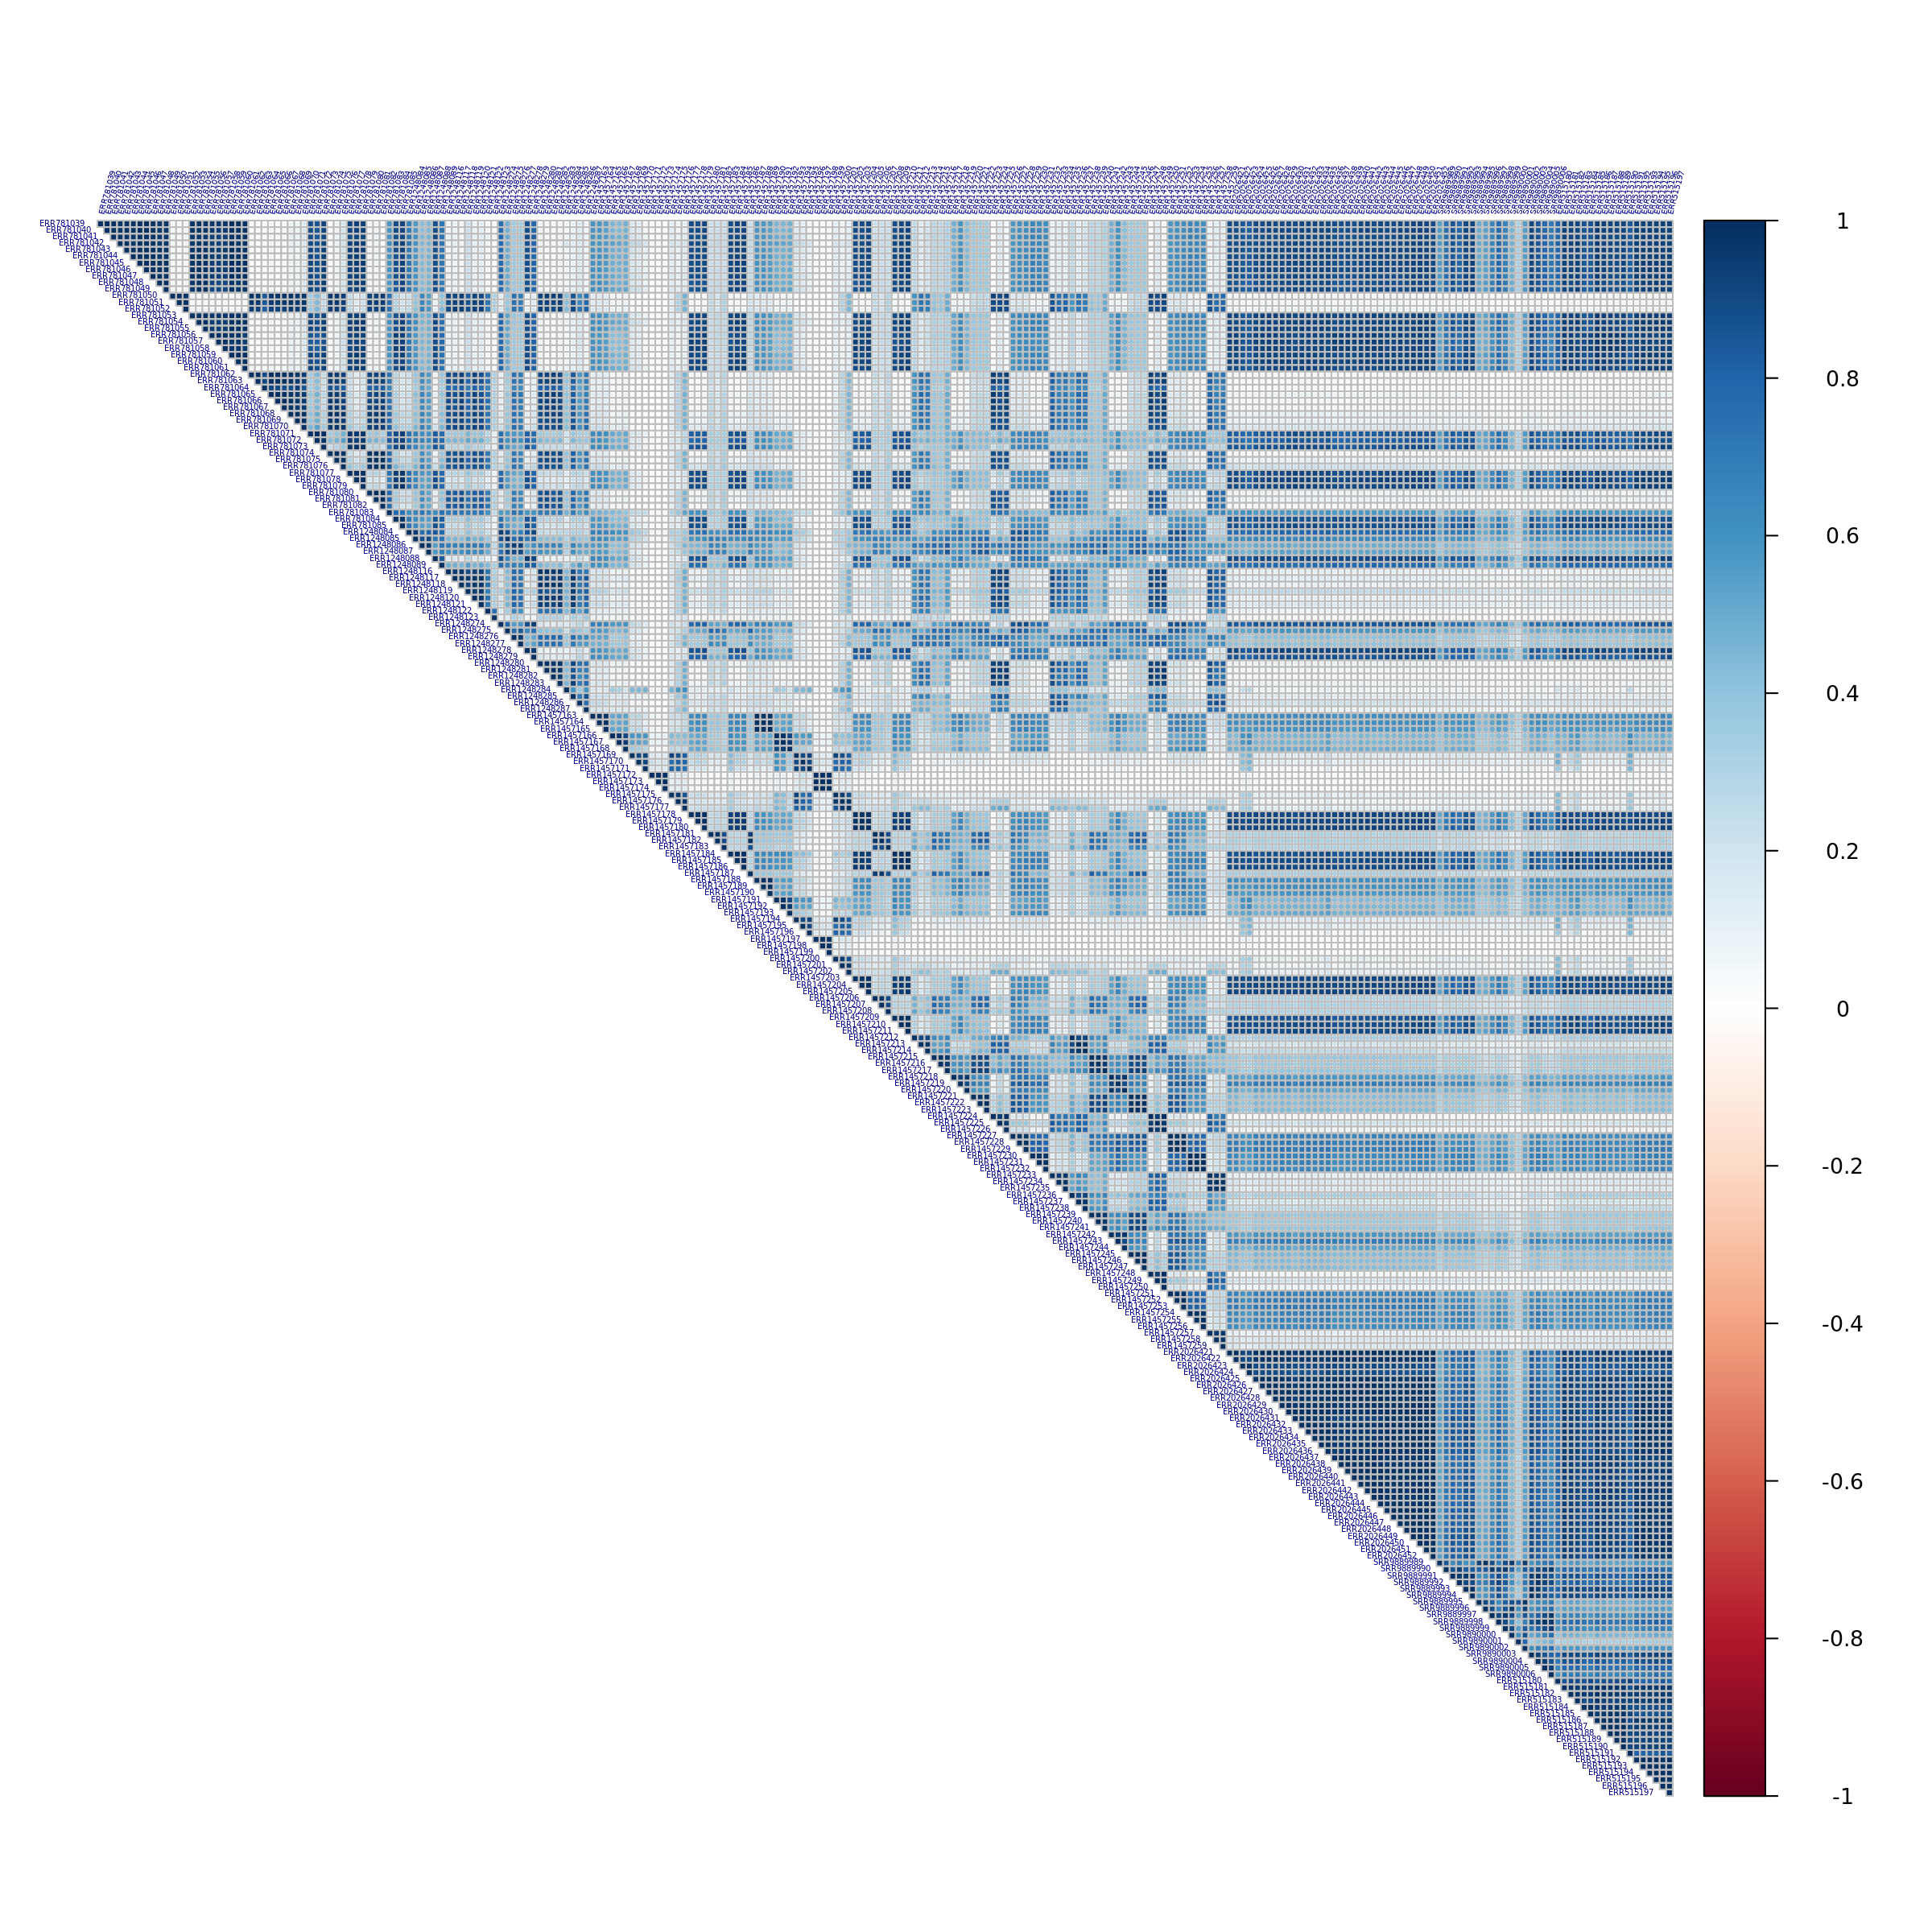

In [48]:
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 200)
corrplot(barley_cor, tl.cex = 0.3, tl.col = "darkblue", type = "upper")
         #sig.level = 0.05, tl.srt = 75)

### 1.3.5 Log2 transform

In [57]:
cnt_log2 <- log2(bcp_filtered+1)
head(cnt_log2)

ERR781039 ERR781040 ERR781041 ERR781042 ERR781043
Horvu_MOREX_1H01G000100 8.396605  6.942515  6.066089  7.707359  8.471675 
Horvu_MOREX_1H01G000200 1.000000  0.000000  0.000000  1.000000  1.000000 
Horvu_MOREX_1H01G000300 6.870365  5.832890  5.523562  6.629357  6.768184 
Horvu_MOREX_1H01G000400 9.105909  7.531381  7.066089  8.459432  9.103288 
Horvu_MOREX_1H01G000500 9.121534  7.392317  6.870365  8.581201  9.000000 
Horvu_MOREX_1H01G000600 9.468234  8.030967  7.204022  8.577836  9.164140 
                        ERR781044 ERR781045 ERR781046 ERR781047 ERR781048 ⋯
Horvu_MOREX_1H01G000100 8.823367  8.603626  8.665336  8.491853   9.361944 ⋯
Horvu_MOREX_1H01G000200 1.000000  1.000000  0.000000  0.000000   1.000000 ⋯
Horvu_MOREX_1H01G000300 7.357552  7.330917  7.066089  6.882643   8.154818 ⋯
Horvu_MOREX_1H01G000400 9.361944  9.174926  9.243174  9.079485  10.209453 ⋯
Horvu_MOREX_1H01G000500 9.312883  9.594325  9.247928  9.301496  10.188589 ⋯
Horvu_MOREX_1H01G000600 9.603287  9.693628  9.774038  9.147679  10.449972 ⋯
                        ERR515188 ERR515189 ERR515190 ERR515191 ERR515192
Horvu_MOREX_1H01G000100 10.267957 11.127994 10.554589 10.840778 10.727920
Horvu_MOREX_1H01G000200  1.000000  2.000000  3.459432  1.000000  1.584963
Horvu_MOREX_1H01G000300  8.744834  9.255029  9.022368  8.867279  8.945444
Horvu_MOREX_1H01G000400  9.924813 10.680360 10.358651 10.181152 11.032046
Horvu_MOREX_1H01G000500 11.836445 12.082482 12.209149 12.126059 11.165535
Horvu_MOREX_1H01G000600 11.456180 11.695834 11.434393 11.468764 11.543638
                        ERR515193 ERR515194 ERR515195 ERR515196 ERR515197
Horvu_MOREX_1H01G000100 11.274960 11.145932 11.332596 11.269711 11.178665
Horvu_MOREX_1H01G000200  3.169925  2.807355  0.000000  1.584963  1.584963
Horvu_MOREX_1H01G000300  9.350939  9.154818  9.405141  9.473706  9.192293
Horvu_MOREX_1H01G000400 11.419434 11.449149 11.848623 11.572227 11.572700
Horvu_MOREX_1H01G000500 11.240195 11.198445 11.932584 11.706064 11.653741
Horvu_MOREX_1H01G000600 12.053881 11.935397 12.027206 12.004165 11.982333

### 1.3.6 Preparation for PCA with log2 & filtered counts

In [58]:
# switching rows to columns
cnt_log <- t(cnt_log2)
cnt_log <- as.data.frame(cnt_log, stringsAsFactors = TRUE)
# adding rownames=ID as a column
cnt_log <- cbind(ID = rownames(cnt_log), cnt_log)
rownames(cnt_log) <- cnt_log$ID
dim(cnt_log)
head(cnt_log)
# barley_tech_meta has technical variables

[1]   240 42776

ID        Horvu_MOREX_1H01G000100 Horvu_MOREX_1H01G000200
ERR781039 ERR781039 8.396605                1                      
ERR781040 ERR781040 6.942515                0                      
ERR781041 ERR781041 6.066089                0                      
ERR781042 ERR781042 7.707359                1                      
ERR781043 ERR781043 8.471675                1                      
ERR781044 ERR781044 8.823367                1                      
          Horvu_MOREX_1H01G000300 Horvu_MOREX_1H01G000400
ERR781039 6.870365                9.105909               
ERR781040 5.832890                7.531381               
ERR781041 5.523562                7.066089               
ERR781042 6.629357                8.459432               
ERR781043 6.768184                9.103288               
ERR781044 7.357552                9.361944               
          Horvu_MOREX_1H01G000500 Horvu_MOREX_1H01G000600
ERR781039 9.121534                9.468234               
ERR781040 7.392317                8.030967               
ERR781041 6.870365                7.204022               
ERR781042 8.581201                8.577836               
ERR781043 9.000000                9.164140               
ERR781044 9.312883                9.603287               
          Horvu_MOREX_1H01G000700 Horvu_MOREX_1H01G000800
ERR781039 8.459432                8.527477               
ERR781040 6.819300                7.022368               
ERR781041 5.727920                5.930737               
ERR781042 7.577000                7.636625               
ERR781043 8.299208                8.495855               
ERR781044 8.506964                8.643856               
          Horvu_MOREX_1H01G000900 ⋯ Horvu_MOREX_Un01G109600
ERR781039 6.189825                ⋯ 0                      
ERR781040 4.392317                ⋯ 0                      
ERR781041 3.584963                ⋯ 0                      
ERR781042 5.321928                ⋯ 0                      
ERR781043 5.614710                ⋯ 0                      
ERR781044 6.108524                ⋯ 0                      
          Horvu_MOREX_Un01G109700 Horvu_MOREX_Un01G109800
ERR781039 0                       1.910433               
ERR781040 0                       2.764233               
ERR781041 0                       0.000000               
ERR781042 1                       0.000000               
ERR781043 0                       1.894143               
ERR781044 0                       1.984677               
          Horvu_MOREX_Un01G109900 Horvu_MOREX_Un01G110000
ERR781039 0.000000                3.107582               
ERR781040 0.000000                0.000000               
ERR781041 0.000000                0.000000               
ERR781042 1.326065                2.792515               
ERR781043 1.825677                2.414760               
ERR781044 0.000000                0.000000               
          Horvu_MOREX_Un01G110100 Horvu_MOREX_Un01G110300
ERR781039 1.584963                1                      
ERR781040 0.000000                0                      
ERR781041 1.000000                0                      
ERR781042 0.000000                0                      
ERR781043 0.000000                0                      
ERR781044 0.000000                0                      
          Horvu_MOREX_Un01G110400 Horvu_MOREX_Un01G110500
ERR781039 0                       0.2031522              
ERR781040 0                       1.8073549              
ERR781041 0                       0.0000000              
ERR781042 0                       0.8558963              
ERR781043 0                       0.6973128              
ERR781044 0                       1.0861857              
          Horvu_MOREX_Un01G110600
ERR781039 0.00000000             
ERR781040 0.05578695             
ERR781041 0.00000000             
ERR781042 0.00000000             
ERR781043 0.00000000             
ERR781044 0.00000000

In [159]:
# include metadata table
cnt_log_meta <- inner_join(barley_mix_meta, cnt_log, by = "ID")
# add rownames again
rownames(cnt_log_meta) <- cnt_log_meta$ID
dim(cnt_log_meta)
head(cnt_log_meta)

[1]   240 42783

ID        dataset                        instrument          library
ERR781039 ERR781039 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
ERR781040 ERR781040 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
ERR781041 ERR781041 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
ERR781042 ERR781042 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
ERR781043 ERR781043 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
ERR781044 ERR781044 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
          intermediate_age high_level_age intermediate_tissue high_level_tissue
ERR781039 Germination      Seedling       apex                leaf             
ERR781040 Germination      Seedling       apex                leaf             
ERR781041 Germination      Seedling       apex                leaf             
ERR781042 Leaf_development Seedling       apex                leaf             
ERR781043 Leaf_development Seedling       apex                leaf             
ERR781044 Leaf_development Seedling       apex                leaf             
          Horvu_MOREX_1H01G000100 Horvu_MOREX_1H01G000200 ⋯
ERR781039 8.396605                1                       ⋯
ERR781040 6.942515                0                       ⋯
ERR781041 6.066089                0                       ⋯
ERR781042 7.707359                1                       ⋯
ERR781043 8.471675                1                       ⋯
ERR781044 8.823367                1                       ⋯
          Horvu_MOREX_Un01G109600 Horvu_MOREX_Un01G109700
ERR781039 0                       0                      
ERR781040 0                       0                      
ERR781041 0                       0                      
ERR781042 0                       1                      
ERR781043 0                       0                      
ERR781044 0                       0                      
          Horvu_MOREX_Un01G109800 Horvu_MOREX_Un01G109900
ERR781039 1.910433                0.000000               
ERR781040 2.764233                0.000000               
ERR781041 0.000000                0.000000               
ERR781042 0.000000                1.326065               
ERR781043 1.894143                1.825677               
ERR781044 1.984677                0.000000               
          Horvu_MOREX_Un01G110000 Horvu_MOREX_Un01G110100
ERR781039 3.107582                1.584963               
ERR781040 0.000000                0.000000               
ERR781041 0.000000                1.000000               
ERR781042 2.792515                0.000000               
ERR781043 2.414760                0.000000               
ERR781044 0.000000                0.000000               
          Horvu_MOREX_Un01G110300 Horvu_MOREX_Un01G110400
ERR781039 1                       0                      
ERR781040 0                       0                      
ERR781041 0                       0                      
ERR781042 0                       0                      
ERR781043 0                       0                      
ERR781044 0                       0                      
          Horvu_MOREX_Un01G110500 Horvu_MOREX_Un01G110600
ERR781039 0.2031522               0.00000000             
ERR781040 1.8073549               0.05578695             
ERR781041 0.0000000               0.00000000             
ERR781042 0.8558963               0.00000000             
ERR781043 0.6973128               0.00000000             
ERR781044 1.0861857               0.00000000

In [160]:
# convert variables which are not factor into factor that they could be part of pca
#cnt_log_meta$rna_input<-factor(cnt_log_meta$rna_input)
#cnt_log_meta$batch<-factor(cnt_log_meta$batch)
#class(cnt_log_meta$rna_input)
#class(cnt_log_meta$batch)
# change factor levels where extra levels are present from single dataset: inf_dev & tf_q for dataset, 21 for temp
cnt_log_meta <- droplevels(cnt_log_meta)
# delete ID column to not have it as extra supplementary variable
cnt_log_meta <- select(cnt_log_meta, -ID)
head(cnt_log_meta)

dataset                        instrument          library
ERR781039 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
ERR781040 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
ERR781041 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
ERR781042 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
ERR781043 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
ERR781044 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
          intermediate_age high_level_age intermediate_tissue high_level_tissue
ERR781039 Germination      Seedling       apex                leaf             
ERR781040 Germination      Seedling       apex                leaf             
ERR781041 Germination      Seedling       apex                leaf             
ERR781042 Leaf_development Seedling       apex                leaf             
ERR781043 Leaf_development Seedling       apex                leaf             
ERR781044 Leaf_development Seedling       apex                leaf             
          Horvu_MOREX_1H01G000100 Horvu_MOREX_1H01G000200
ERR781039 8.396605                1                      
ERR781040 6.942515                0                      
ERR781041 6.066089                0                      
ERR781042 7.707359                1                      
ERR781043 8.471675                1                      
ERR781044 8.823367                1                      
          Horvu_MOREX_1H01G000300 ⋯ Horvu_MOREX_Un01G109600
ERR781039 6.870365                ⋯ 0                      
ERR781040 5.832890                ⋯ 0                      
ERR781041 5.523562                ⋯ 0                      
ERR781042 6.629357                ⋯ 0                      
ERR781043 6.768184                ⋯ 0                      
ERR781044 7.357552                ⋯ 0                      
          Horvu_MOREX_Un01G109700 Horvu_MOREX_Un01G109800
ERR781039 0                       1.910433               
ERR781040 0                       2.764233               
ERR781041 0                       0.000000               
ERR781042 1                       0.000000               
ERR781043 0                       1.894143               
ERR781044 0                       1.984677               
          Horvu_MOREX_Un01G109900 Horvu_MOREX_Un01G110000
ERR781039 0.000000                3.107582               
ERR781040 0.000000                0.000000               
ERR781041 0.000000                0.000000               
ERR781042 1.326065                2.792515               
ERR781043 1.825677                2.414760               
ERR781044 0.000000                0.000000               
          Horvu_MOREX_Un01G110100 Horvu_MOREX_Un01G110300
ERR781039 1.584963                1                      
ERR781040 0.000000                0                      
ERR781041 1.000000                0                      
ERR781042 0.000000                0                      
ERR781043 0.000000                0                      
ERR781044 0.000000                0                      
          Horvu_MOREX_Un01G110400 Horvu_MOREX_Un01G110500
ERR781039 0                       0.2031522              
ERR781040 0                       1.8073549              
ERR781041 0                       0.0000000              
ERR781042 0                       0.8558963              
ERR781043 0                       0.6973128              
ERR781044 0                       1.0861857              
          Horvu_MOREX_Un01G110600
ERR781039 0.00000000             
ERR781040 0.05578695             
ERR781041 0.00000000             
ERR781042 0.00000000             
ERR781043 0.00000000             
ERR781044 0.00000000

In [161]:
# create classes to check on class types -> pca can handle supplementary variables only as factors!
classes2 <- sapply(X = cnt_log_meta, FUN = class)
table(classes2)
which(classes2 == 'factor')

classes2
 factor numeric 
      7   42775 

dataset          instrument             library    intermediate_age 
                  1                   2                   3                   4 
     high_level_age intermediate_tissue   high_level_tissue 
                  5                   6                   7

# 1.3.7 **Un-scaled** PCA on log2-transformed & filtered TPM counts

In [162]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 100)
log2_pca <- PCA(X = cnt_log_meta, scale.unit = FALSE, ncp = 4, quali.sup = c(1:7), graph = F)
#summary(log2_pca)

eigenvalue percentage of variance cumulative percentage of variance
comp 1 37674.747  31.439725              31.43973                         
comp 2 21753.150  18.153090              49.59281                         
comp 3 12312.139  10.274528              59.86734                         
comp 4  6429.829   5.365718              65.23306                         
comp 5  5624.911   4.694010              69.92707                         
comp 6  3515.888   2.934023              72.86109

Warning message in brewer.pal(18, "Paired"):
“n too large, allowed maximum for palette Paired is 12
Returning the palette you asked for with that many colors
”

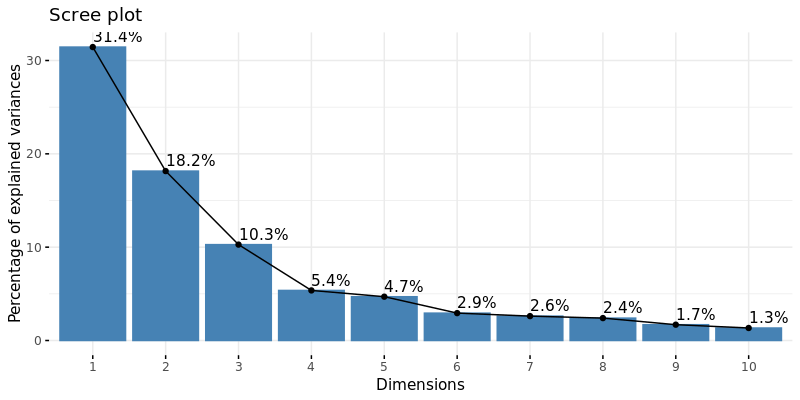

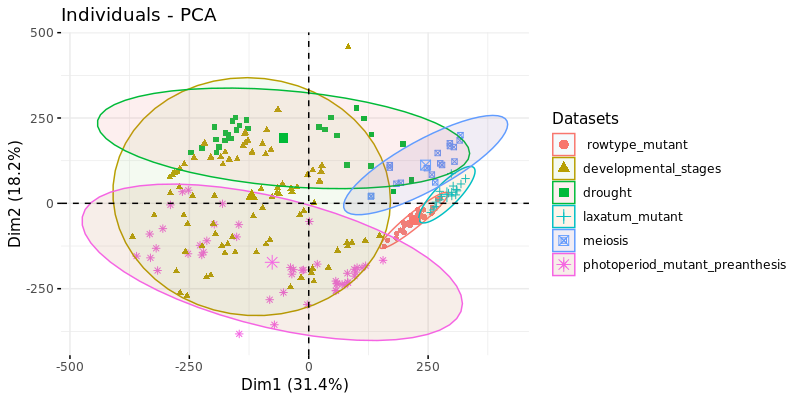

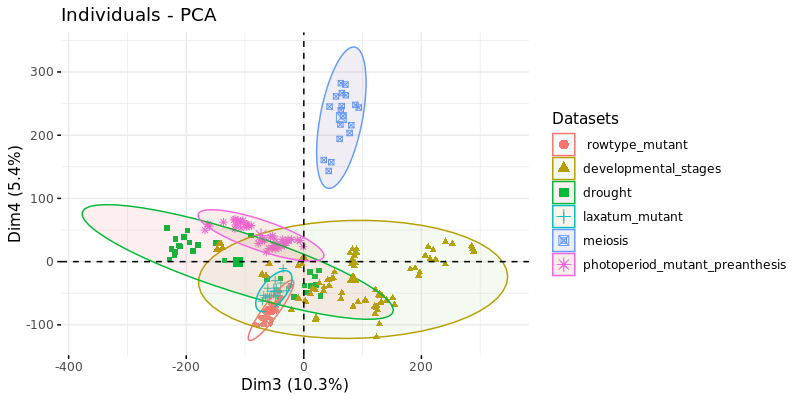

In [163]:
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 100)
# display eigenvalues
head(log2_pca$eig)
# display scree plot
fviz_eig(log2_pca, addlabels = TRUE)
# display individuals (samples) colored by technical variable
colourCount = length(unique(cnt_log_meta$dataset))
getPalette = colorRampPalette(brewer.pal(18, "Paired"))
fviz_pca_ind(X = log2_pca, label = "none", legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2), habillage = cnt_log_meta$dataset) +
                scale_fill_manual(values = getPalette(colourCount))
fviz_pca_ind(X = log2_pca, label = "none", legend.title = "Datasets", addEllipses = TRUE, axes = c(3, 4), habillage = cnt_log_meta$dataset) +
                scale_fill_manual(values = getPalette(colourCount))

In [166]:
# build comparism plot variables
a1 <- fviz_pca_ind(X = log2_pca, label = "none", legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2), habillage = cnt_log_meta$dataset) +
                scale_fill_manual(values = getPalette(colourCount))
a2 <- fviz_pca_ind(X = log2_pca, geom="point", axes = c(1, 2), legend.title = "Library type", habillage = cnt_log_meta$library)
a3 <- fviz_pca_ind(X = log2_pca, geom="point", axes = c(1, 2), legend.title = "Instrument", habillage = cnt_log_meta$instrument)
a4 <- fviz_pca_ind(X = log2_pca, geom="point", axes = c(1, 2), legend.title = "High level tissue", habillage = cnt_log_meta$high_level_tissue)
a5 <- fviz_pca_ind(X = log2_pca, geom="point", axes = c(1, 2), legend.title = "High level age", habillage = cnt_log_meta$high_level_age)

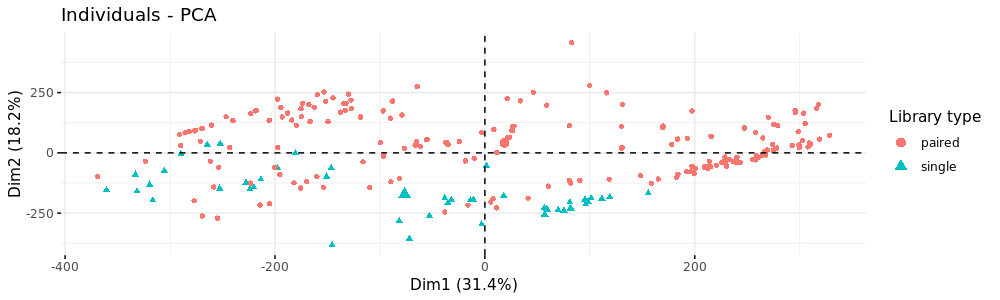

In [165]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 100)
fviz_pca_ind(X = log2_pca, geom="point", axes = c(1, 2), legend.title = "Library type", habillage = cnt_log_meta$library)

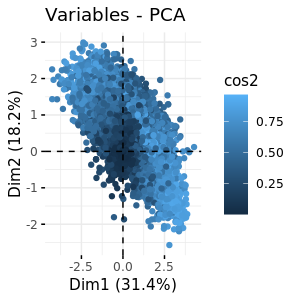

In [65]:
# display variables (genes) colored by quality
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 100)
fviz_pca_var(X = log2_pca, col.var = "cos2", axes = 1:2, label = "none", geom = "point")

# 1.4 **Scaled & centered** PCA on log2-transformed & filtered TPM counts

In [66]:
# scaling and centering data, here it has to happen before the log2 transformation!!
cnt_log2_scaled <- t(bcp_filtered)
cnt_log2_scaled <- as.data.frame(cnt_log2_scaled, stringsAsFactors = FALSE)

# scaling and centering
#cnt_log2_scaled <- cnt_log2_scaled+1

cnt_log2_scaled <- scale(cnt_log2_scaled, center = TRUE, scale = TRUE)
head(cnt_log2_scaled)

# log2
cnt_log2_scaled <- cnt_log2_scaled+2
cnt_log2_scaled <- log2(cnt_log2_scaled)
head(cnt_log2_scaled)
# adding rownames=ID as a column
cnt_log2_scaled <- as.data.frame(cnt_log2_scaled, stringsAsFactors = TRUE)
cnt_log2_scaled <- cbind(ID = rownames(cnt_log2_scaled), cnt_log2_scaled)
rownames(cnt_log2_scaled) <- cnt_log2_scaled$ID
dim(cnt_log2_scaled)
head(cnt_log2_scaled)

Horvu_MOREX_1H01G000100 Horvu_MOREX_1H01G000200
ERR781039 -0.9202234              -0.3781257             
ERR781040 -1.1285116              -0.3806276             
ERR781041 -1.1830169              -0.3806276             
ERR781042 -1.0448070              -0.3781257             
ERR781043 -0.9027038              -0.3781257             
ERR781044 -0.8073195              -0.3781257             
          Horvu_MOREX_1H01G000300 Horvu_MOREX_1H01G000400
ERR781039 -0.6177755              -0.3227338             
ERR781040 -0.7506979              -0.7678700             
ERR781041 -0.7750670              -0.8298971             
ERR781042 -0.6576522              -0.5647614             
ERR781043 -0.6354985              -0.3239500             
ERR781044 -0.5136529              -0.1925984             
          Horvu_MOREX_1H01G000500 Horvu_MOREX_1H01G000600
ERR781039 -0.7750775              -0.5040000             
ERR781040 -0.9855431              -0.9267391             
ERR781041 -1.0131362              -1.0347156             
ERR781042 -0.8692189              -0.8126660             
ERR781043 -0.7994244              -0.6313773             
ERR781044 -0.7323351              -0.4382280             
          Horvu_MOREX_1H01G000700 Horvu_MOREX_1H01G000800
ERR781039 -0.5984791              -0.9214822             
ERR781040 -0.8178056              -1.2359472             
ERR781041 -0.8727876              -1.3267342             
ERR781042 -0.7462358              -1.1451602             
ERR781043 -0.6324236              -0.9320082             
ERR781044 -0.5876623              -0.8806939             
          Horvu_MOREX_1H01G000900 Horvu_MOREX_1H01G001000 ⋯
ERR781039 -0.2988352              -0.7653323              ⋯
ERR781040 -0.6860706              -0.8704122              ⋯
ERR781041 -0.7530921              -0.8308527              ⋯
ERR781042 -0.5445807              -0.8123092              ⋯
ERR781043 -0.4775592              -0.7665685              ⋯
ERR781044 -0.3286226              -0.7356626              ⋯
          Horvu_MOREX_Un01G109600 Horvu_MOREX_Un01G109700
ERR781039 -0.1459607              -0.1986258             
ERR781040 -0.1459607              -0.1986258             
ERR781041 -0.1459607              -0.1986258             
ERR781042 -0.1459607               0.8417645             
ERR781043 -0.1459607              -0.1986258             
ERR781044 -0.1459607              -0.1986258             
          Horvu_MOREX_Un01G109800 Horvu_MOREX_Un01G109900
ERR781039 -0.17936337             -0.40951020            
ERR781040 -0.03651176             -0.40951020            
ERR781041 -0.30924954             -0.40951020            
ERR781042 -0.30924954              0.02647103            
ERR781043 -0.18135022              0.32660468            
ERR781044 -0.17001816             -0.40951020            
          Horvu_MOREX_Un01G110000 Horvu_MOREX_Un01G110100
ERR781039 -0.1418557              -0.2806781             
ERR781040 -0.1994620              -0.4545074             
ERR781041 -0.1994620              -0.3675927             
ERR781042 -0.1546405              -0.4545074             
ERR781043 -0.1667076              -0.4545074             
ERR781044 -0.1994620              -0.4545074             
          Horvu_MOREX_Un01G110300 Horvu_MOREX_Un01G110400
ERR781039 -0.2186038              -0.2122416             
ERR781040 -0.2423654              -0.2122416             
ERR781041 -0.2423654              -0.2122416             
ERR781042 -0.2423654              -0.2122416             
ERR781043 -0.2423654              -0.2122416             
ERR781044 -0.2423654              -0.2122416             
          Horvu_MOREX_Un01G110500 Horvu_MOREX_Un01G110600
ERR781039 -0.5770796              -0.16910644            
ERR781040  0.3982525              -0.02203944            
ERR781041 -0.6398697              -0.16910644            
ERR781042 -0.3035668              -0.16910644            
ERR781043 -0.3818001              -0.16910644       

Horvu_MOREX_1H01G000100 Horvu_MOREX_1H01G000200
ERR781039  0.11073289             0.6976620              
ERR781040 -0.19844657             0.6954348              
ERR781041 -0.29162183             0.6954348              
ERR781042 -0.06613578             0.6976620              
ERR781043  0.13395300             0.6976620              
ERR781044  0.25420762             0.6976620              
          Horvu_MOREX_1H01G000300 Horvu_MOREX_1H01G000400
ERR781039 0.4669920               0.7461117              
ERR781040 0.3211223               0.3011545              
ERR781041 0.2927028               0.2266354              
ERR781042 0.4247585               0.5212906              
ERR781043 0.4483740               0.7450651              
ERR781044 0.5717710               0.8539171              
          Horvu_MOREX_1H01G000500 Horvu_MOREX_1H01G000600
ERR781039  0.29269051              0.58111015            
ERR781040  0.02070761              0.10200084            
ERR781041 -0.01907718             -0.05097408            
ERR781042  0.17731968              0.24772583            
ERR781043  0.26372627              0.45272473            
ERR781044  0.34217344              0.64318389            
          Horvu_MOREX_1H01G000700 Horvu_MOREX_1H01G000800
ERR781039 0.4869932                0.10904998            
ERR781040 0.2414673               -0.38825576            
ERR781041 0.1727594               -0.57075184            
ERR781042 0.3262661               -0.22627408            
ERR781043 0.4516214                0.09490052            
ERR781044 0.4980851                0.16260468            
          Horvu_MOREX_1H01G000900 Horvu_MOREX_1H01G001000 ⋯
ERR781039 0.7665229               0.3041229               ⋯
ERR781040 0.3938878               0.1757964               ⋯
ERR781041 0.3183549               0.2254567               ⋯
ERR781042 0.5414348               0.2481593               ⋯
ERR781043 0.6063861               0.3026776               ⋯
ERR781044 0.7410376               0.3383815               ⋯
          Horvu_MOREX_Un01G109600 Horvu_MOREX_Un01G109700
ERR781039 0.8906718               0.8490979              
ERR781040 0.8906718               0.8490979              
ERR781041 0.8906718               0.8490979              
ERR781042 0.8906718               1.5067870              
ERR781043 0.8906718               0.8490979              
ERR781044 0.8906718               0.8490979              
          Horvu_MOREX_Un01G109800 Horvu_MOREX_Un01G109900
ERR781039 0.8644430               0.6694711              
ERR781040 0.9734190               0.6694711              
ERR781041 0.7576637               0.6694711              
ERR781042 0.7576637               1.0189695              
ERR781043 0.8628677               1.2182261              
ERR781044 0.8718293               0.6694711              
          Horvu_MOREX_Un01G110000 Horvu_MOREX_Un01G110100
ERR781039 0.8938625               0.7818397              
ERR781040 0.8484280               0.6280668              
ERR781041 0.8484280               0.7070010              
ERR781042 0.8839019               0.6280668              
ERR781043 0.8744369               0.6280668              
ERR781044 0.8484280               0.6280668              
          Horvu_MOREX_Un01G110300 Horvu_MOREX_Un01G110400
ERR781039 0.8330084               0.8381517              
ERR781040 0.8136352               0.8381517              
ERR781041 0.8136352               0.8381517              
ERR781042 0.8136352               0.8381517              
ERR781043 0.8136352               0.8381517              
ERR781044 0.8136352               0.8381517              
          Horvu_MOREX_Un01G110500 Horvu_MOREX_Un01G110600
ERR781039 0.5088550               0.8725479              
ERR781040 1.2619835               0.9840137              
ERR781041 0.4437448               0.8725479              
ERR781042 0.7625046               0.8725479              
ERR781043 0.6943898               0.8725479         

[1]   240 42776

ID        Horvu_MOREX_1H01G000100 Horvu_MOREX_1H01G000200
ERR781039 ERR781039  0.11073289             0.6976620              
ERR781040 ERR781040 -0.19844657             0.6954348              
ERR781041 ERR781041 -0.29162183             0.6954348              
ERR781042 ERR781042 -0.06613578             0.6976620              
ERR781043 ERR781043  0.13395300             0.6976620              
ERR781044 ERR781044  0.25420762             0.6976620              
          Horvu_MOREX_1H01G000300 Horvu_MOREX_1H01G000400
ERR781039 0.4669920               0.7461117              
ERR781040 0.3211223               0.3011545              
ERR781041 0.2927028               0.2266354              
ERR781042 0.4247585               0.5212906              
ERR781043 0.4483740               0.7450651              
ERR781044 0.5717710               0.8539171              
          Horvu_MOREX_1H01G000500 Horvu_MOREX_1H01G000600
ERR781039  0.29269051              0.58111015            
ERR781040  0.02070761              0.10200084            
ERR781041 -0.01907718             -0.05097408            
ERR781042  0.17731968              0.24772583            
ERR781043  0.26372627              0.45272473            
ERR781044  0.34217344              0.64318389            
          Horvu_MOREX_1H01G000700 Horvu_MOREX_1H01G000800
ERR781039 0.4869932                0.10904998            
ERR781040 0.2414673               -0.38825576            
ERR781041 0.1727594               -0.57075184            
ERR781042 0.3262661               -0.22627408            
ERR781043 0.4516214                0.09490052            
ERR781044 0.4980851                0.16260468            
          Horvu_MOREX_1H01G000900 ⋯ Horvu_MOREX_Un01G109600
ERR781039 0.7665229               ⋯ 0.8906718              
ERR781040 0.3938878               ⋯ 0.8906718              
ERR781041 0.3183549               ⋯ 0.8906718              
ERR781042 0.5414348               ⋯ 0.8906718              
ERR781043 0.6063861               ⋯ 0.8906718              
ERR781044 0.7410376               ⋯ 0.8906718              
          Horvu_MOREX_Un01G109700 Horvu_MOREX_Un01G109800
ERR781039 0.8490979               0.8644430              
ERR781040 0.8490979               0.9734190              
ERR781041 0.8490979               0.7576637              
ERR781042 1.5067870               0.7576637              
ERR781043 0.8490979               0.8628677              
ERR781044 0.8490979               0.8718293              
          Horvu_MOREX_Un01G109900 Horvu_MOREX_Un01G110000
ERR781039 0.6694711               0.8938625              
ERR781040 0.6694711               0.8484280              
ERR781041 0.6694711               0.8484280              
ERR781042 1.0189695               0.8839019              
ERR781043 1.2182261               0.8744369              
ERR781044 0.6694711               0.8484280              
          Horvu_MOREX_Un01G110100 Horvu_MOREX_Un01G110300
ERR781039 0.7818397               0.8330084              
ERR781040 0.6280668               0.8136352              
ERR781041 0.7070010               0.8136352              
ERR781042 0.6280668               0.8136352              
ERR781043 0.6280668               0.8136352              
ERR781044 0.6280668               0.8136352              
          Horvu_MOREX_Un01G110400 Horvu_MOREX_Un01G110500
ERR781039 0.8381517               0.5088550              
ERR781040 0.8381517               1.2619835              
ERR781041 0.8381517               0.4437448              
ERR781042 0.8381517               0.7625046              
ERR781043 0.8381517               0.6943898              
ERR781044 0.8381517               0.8690853              
          Horvu_MOREX_Un01G110600
ERR781039 0.8725479              
ERR781040 0.9840137              
ERR781041 0.8725479              
ERR781042 0.8725479              
ERR781043 0.8725479              
ERR781044 0.8725479

In [67]:
# include metadata table
cnt_meta_log2_scaled <- inner_join(barley_tech_meta, cnt_log2_scaled, by = "ID")
# add rownames again
rownames(cnt_meta_log2_scaled) <- cnt_meta_log2_scaled$ID
dim(cnt_meta_log2_scaled)
head(cnt_meta_log2_scaled)

[1]   240 42789

ID        dataset                        batch rna_extraction
ERR781039 ERR781039 photoperiod_mutant_preanthesis 1     trizol        
ERR781040 ERR781040 photoperiod_mutant_preanthesis 1     trizol        
ERR781041 ERR781041 photoperiod_mutant_preanthesis 1     trizol        
ERR781042 ERR781042 photoperiod_mutant_preanthesis 2     trizol        
ERR781043 ERR781043 photoperiod_mutant_preanthesis 2     trizol        
ERR781044 ERR781044 photoperiod_mutant_preanthesis 2     trizol        
          rna_enrichment         rna_input pcr_purification growth_condition
ERR781039 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781040 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781041 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781042 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781043 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781044 Rneasy_microkit_Qiagen unknown   unknown          incubator       
          day_night temp  ⋯ Horvu_MOREX_Un01G109600 Horvu_MOREX_Un01G109700
ERR781039 8_16      22_18 ⋯ 0.8906718               0.8490979              
ERR781040 8_16      22_18 ⋯ 0.8906718               0.8490979              
ERR781041 8_16      22_18 ⋯ 0.8906718               0.8490979              
ERR781042 16_8      22_18 ⋯ 0.8906718               1.5067870              
ERR781043 16_8      22_18 ⋯ 0.8906718               0.8490979              
ERR781044 16_8      22_18 ⋯ 0.8906718               0.8490979              
          Horvu_MOREX_Un01G109800 Horvu_MOREX_Un01G109900
ERR781039 0.8644430               0.6694711              
ERR781040 0.9734190               0.6694711              
ERR781041 0.7576637               0.6694711              
ERR781042 0.7576637               1.0189695              
ERR781043 0.8628677               1.2182261              
ERR781044 0.8718293               0.6694711              
          Horvu_MOREX_Un01G110000 Horvu_MOREX_Un01G110100
ERR781039 0.8938625               0.7818397              
ERR781040 0.8484280               0.6280668              
ERR781041 0.8484280               0.7070010              
ERR781042 0.8839019               0.6280668              
ERR781043 0.8744369               0.6280668              
ERR781044 0.8484280               0.6280668              
          Horvu_MOREX_Un01G110300 Horvu_MOREX_Un01G110400
ERR781039 0.8330084               0.8381517              
ERR781040 0.8136352               0.8381517              
ERR781041 0.8136352               0.8381517              
ERR781042 0.8136352               0.8381517              
ERR781043 0.8136352               0.8381517              
ERR781044 0.8136352               0.8381517              
          Horvu_MOREX_Un01G110500 Horvu_MOREX_Un01G110600
ERR781039 0.5088550               0.8725479              
ERR781040 1.2619835               0.9840137              
ERR781041 0.4437448               0.8725479              
ERR781042 0.7625046               0.8725479              
ERR781043 0.6943898               0.8725479              
ERR781044 0.8690853               0.8725479

In [68]:
# convert variables which are not factor into factor that they could be part of pca
cnt_meta_log2_scaled$rna_input<-factor(cnt_meta_log2_scaled$rna_input)
cnt_meta_log2_scaled$batch<-factor(cnt_meta_log2_scaled$batch)
class(cnt_meta_log2_scaled$rna_input)
class(cnt_meta_log2_scaled$batch)
# change factor levels where extra levels are present from single dataset: inf_dev & tf_q for dataset, 21 for temp
cnt_meta_log2_scaled <- droplevels(cnt_meta_log2_scaled)
# delete ID column to not have it as extra supplementary variable
cnt_meta_log2_scaled <- select(cnt_meta_log2_scaled, -ID)
head(cnt_meta_log2_scaled)

[1] "factor"

[1] "factor"

dataset                        batch rna_extraction
ERR781039 photoperiod_mutant_preanthesis 1     trizol        
ERR781040 photoperiod_mutant_preanthesis 1     trizol        
ERR781041 photoperiod_mutant_preanthesis 1     trizol        
ERR781042 photoperiod_mutant_preanthesis 2     trizol        
ERR781043 photoperiod_mutant_preanthesis 2     trizol        
ERR781044 photoperiod_mutant_preanthesis 2     trizol        
          rna_enrichment         rna_input pcr_purification growth_condition
ERR781039 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781040 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781041 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781042 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781043 Rneasy_microkit_Qiagen unknown   unknown          incubator       
ERR781044 Rneasy_microkit_Qiagen unknown   unknown          incubator       
          day_night temp  growth_location ⋯ Horvu_MOREX_Un01G109600
ERR781039 8_16      22_18 Germany         ⋯ 0.8906718              
ERR781040 8_16      22_18 Germany         ⋯ 0.8906718              
ERR781041 8_16      22_18 Germany         ⋯ 0.8906718              
ERR781042 16_8      22_18 Germany         ⋯ 0.8906718              
ERR781043 16_8      22_18 Germany         ⋯ 0.8906718              
ERR781044 16_8      22_18 Germany         ⋯ 0.8906718              
          Horvu_MOREX_Un01G109700 Horvu_MOREX_Un01G109800
ERR781039 0.8490979               0.8644430              
ERR781040 0.8490979               0.9734190              
ERR781041 0.8490979               0.7576637              
ERR781042 1.5067870               0.7576637              
ERR781043 0.8490979               0.8628677              
ERR781044 0.8490979               0.8718293              
          Horvu_MOREX_Un01G109900 Horvu_MOREX_Un01G110000
ERR781039 0.6694711               0.8938625              
ERR781040 0.6694711               0.8484280              
ERR781041 0.6694711               0.8484280              
ERR781042 1.0189695               0.8839019              
ERR781043 1.2182261               0.8744369              
ERR781044 0.6694711               0.8484280              
          Horvu_MOREX_Un01G110100 Horvu_MOREX_Un01G110300
ERR781039 0.7818397               0.8330084              
ERR781040 0.6280668               0.8136352              
ERR781041 0.7070010               0.8136352              
ERR781042 0.6280668               0.8136352              
ERR781043 0.6280668               0.8136352              
ERR781044 0.6280668               0.8136352              
          Horvu_MOREX_Un01G110400 Horvu_MOREX_Un01G110500
ERR781039 0.8381517               0.5088550              
ERR781040 0.8381517               1.2619835              
ERR781041 0.8381517               0.4437448              
ERR781042 0.8381517               0.7625046              
ERR781043 0.8381517               0.6943898              
ERR781044 0.8381517               0.8690853              
          Horvu_MOREX_Un01G110600
ERR781039 0.8725479              
ERR781040 0.9840137              
ERR781041 0.8725479              
ERR781042 0.8725479              
ERR781043 0.8725479              
ERR781044 0.8725479

In [69]:
log2_pca_scaled <- PCA(X = cnt_meta_log2_scaled, scale.unit = FALSE, ncp = 4, quali.sup = c(1:13), graph = F)
#summary(log2_pca_scaled)

eigenvalue percentage of variance cumulative percentage of variance
comp 1 3511.8127  37.244662              37.24466                         
comp 2 1043.5796  11.067723              48.31239                         
comp 3  661.0605   7.010903              55.32329                         
comp 4  449.3523   4.765623              60.08891                         
comp 5  296.2268   3.141645              63.23056                         
comp 6  209.2932   2.219667              65.45022

Warning message in brewer.pal(18, "Paired"):
“n too large, allowed maximum for palette Paired is 12
Returning the palette you asked for with that many colors
”

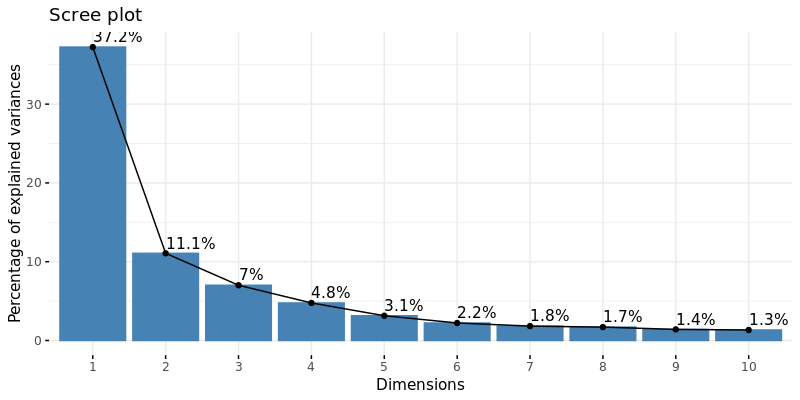

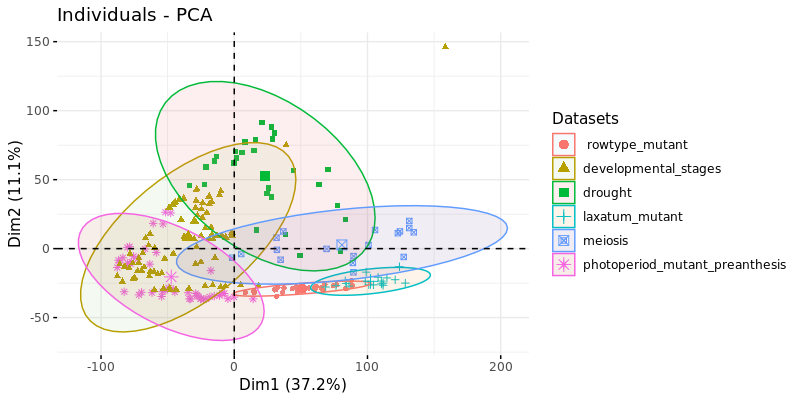

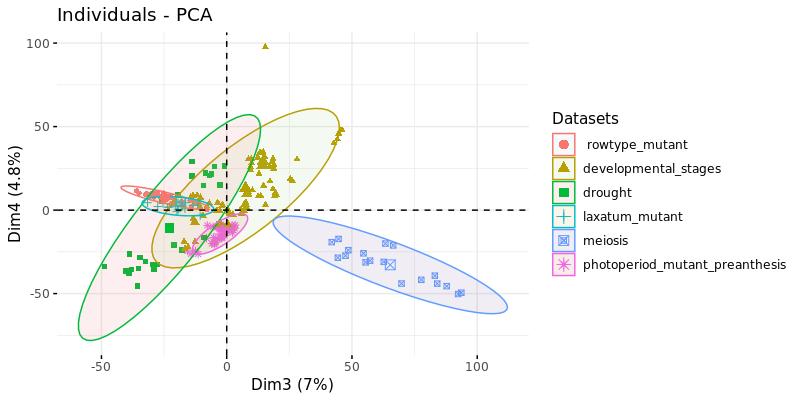

In [70]:
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 100)
# display eigenvalues
head(log2_pca_scaled$eig)
# display scree plot
fviz_eig(log2_pca_scaled, addlabels = TRUE)
# display individuals (samples) colored by technical variable
colourCount = length(unique(cnt_log_meta$dataset))
getPalette = colorRampPalette(brewer.pal(18, "Paired"))
fviz_pca_ind(X = log2_pca_scaled, label = "none", legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2), habillage = cnt_meta_log2_scaled$dataset) +
                scale_fill_manual(values = getPalette(colourCount))
fviz_pca_ind(X = log2_pca_scaled, label = "none", legend.title = "Datasets", addEllipses = TRUE, axes = c(3, 4), habillage = cnt_meta_log2_scaled$dataset) +
                scale_fill_manual(values = getPalette(colourCount))

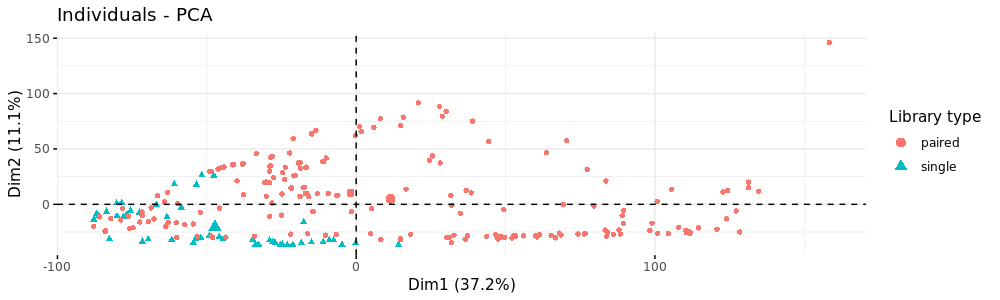

In [71]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 100)
fviz_pca_ind(X = log2_pca_scaled, geom="point", axes = c(1, 2), legend.title = "Library type", habillage = cnt_meta$library)

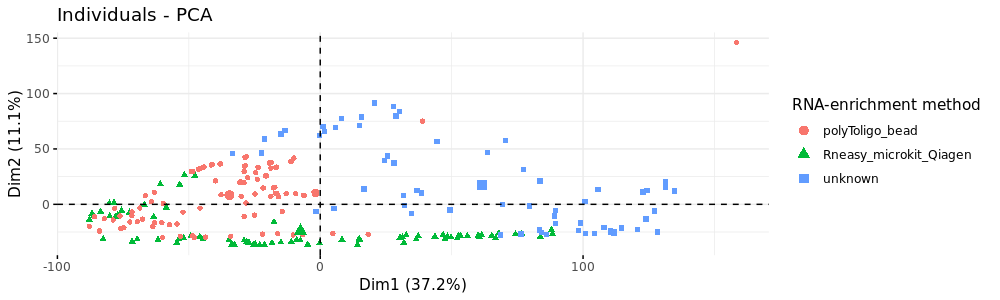

In [72]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 100)
fviz_pca_ind(X = log2_pca_scaled, geom="point", axes = c(1, 2), legend.title = "RNA-enrichment method", habillage = cnt_meta_log2_scaled$rna_enrichment)

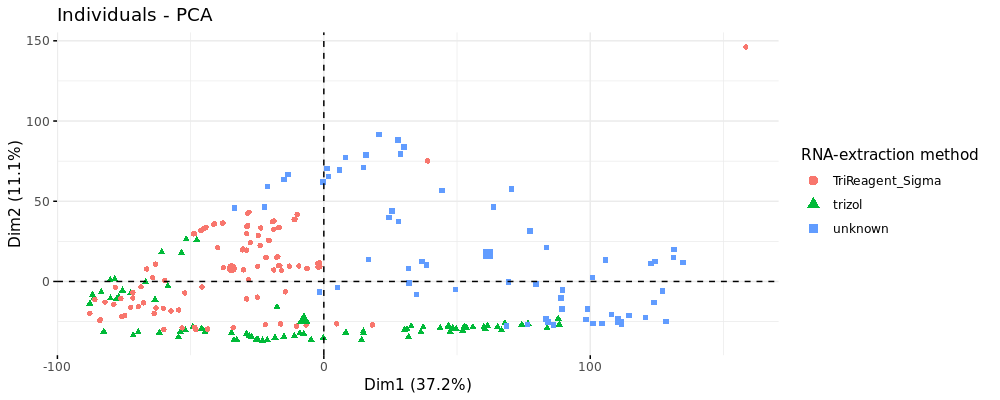

In [73]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 100)
fviz_pca_ind(X = log2_pca_scaled, geom="point", axes = c(1, 2), legend.title = "RNA-extraction method", habillage = cnt_meta_log2_scaled$rna_extraction)

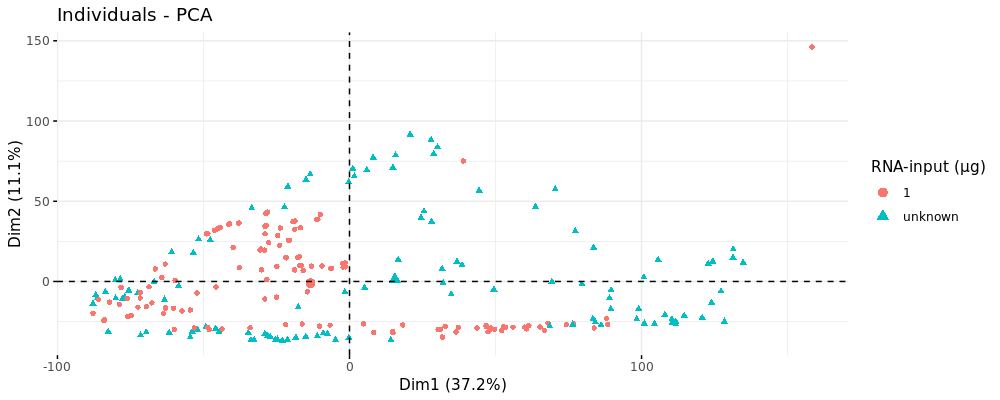

In [74]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 100)
fviz_pca_ind(X = log2_pca_scaled, geom="point", axes = c(1,2), legend.title = "RNA-input (μg)", habillage = cnt_meta_log2_scaled$rna_input)

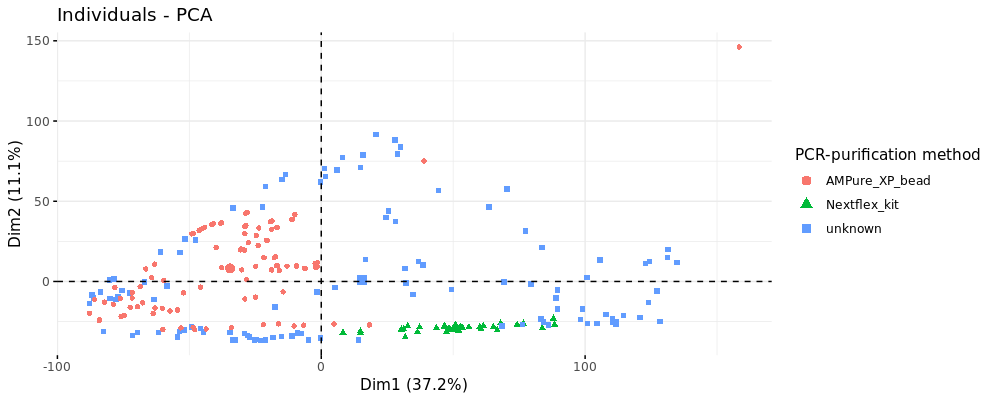

In [75]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 100)
fviz_pca_ind(X = log2_pca_scaled, geom="point", axes = c(1, 2), legend.title = "PCR-purification method", habillage = cnt_meta_log2_scaled$pcr_purification)

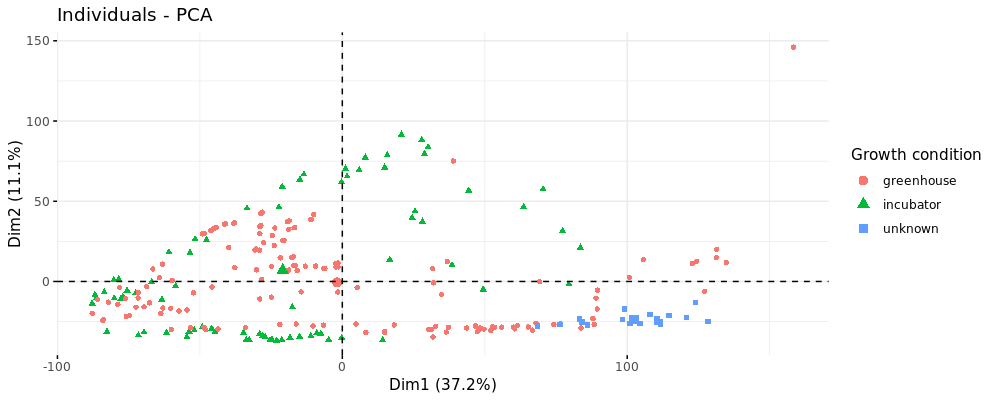

In [76]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 100)
fviz_pca_ind(X = log2_pca_scaled, geom="point", axes = c(1,2), legend.title = "Growth condition", habillage = cnt_meta_log2_scaled$growth_condition)

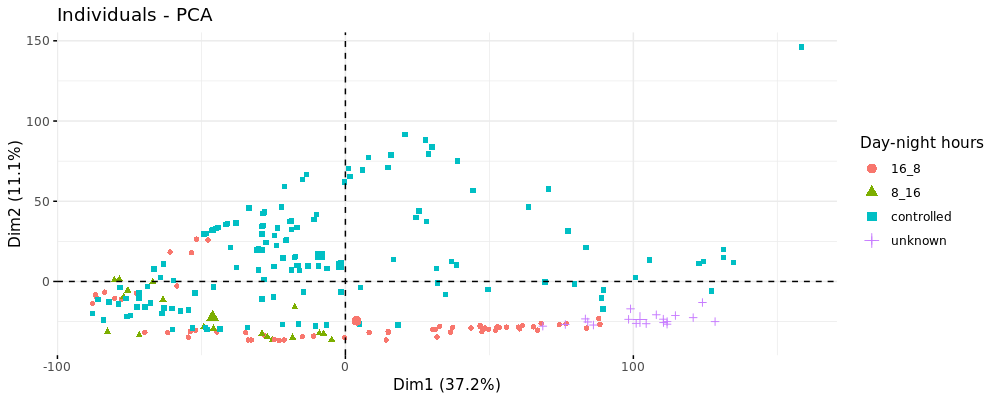

In [77]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 100)
fviz_pca_ind(X = log2_pca_scaled, geom="point", axes = c(1,2), legend.title = "Day-night hours", habillage = cnt_meta_log2_scaled$day_night)

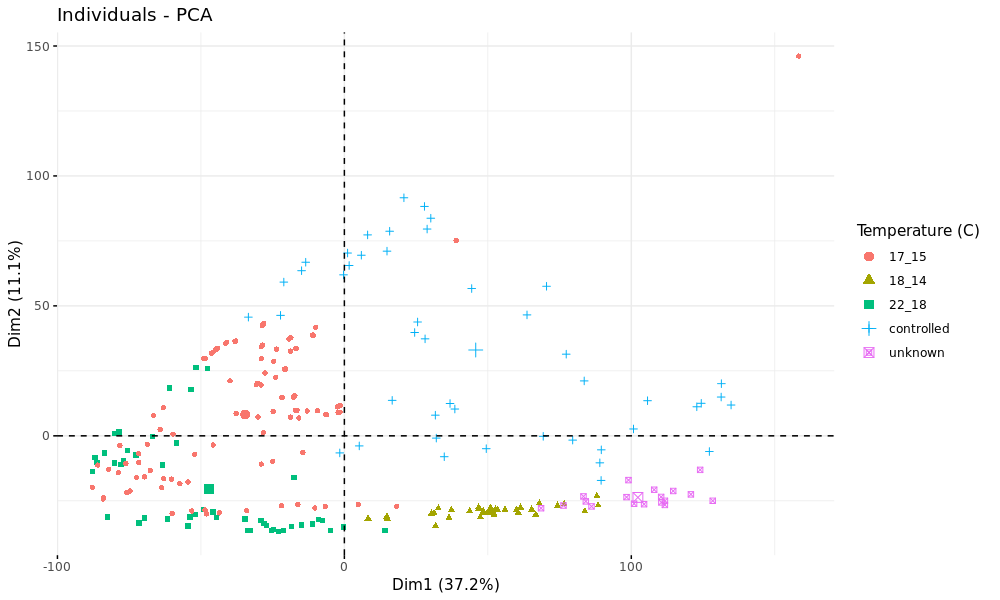

In [78]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_ind(X = log2_pca_scaled, geom="point", axes = c(1,2), legend.title = "Temperature (C)", habillage = cnt_meta_log2_scaled$temp)

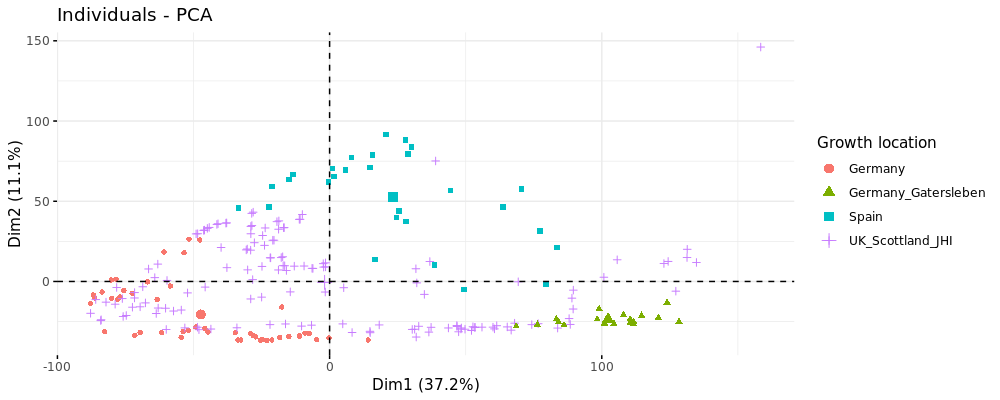

In [79]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 100)
fviz_pca_ind(X = log2_pca_scaled, geom="point", axes = c(1,2), legend.title = "Growth location", habillage = cnt_meta_log2_scaled$growth_location)

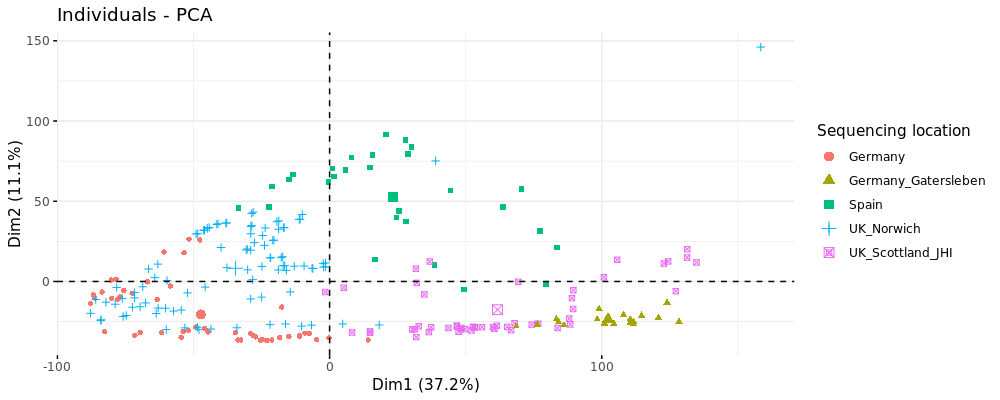

In [80]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 100)
fviz_pca_ind(X = log2_pca_scaled, geom="point", axes= c(1,2), legend.title = "Sequencing location", habillage = cnt_meta_log2_scaled$seq_location)

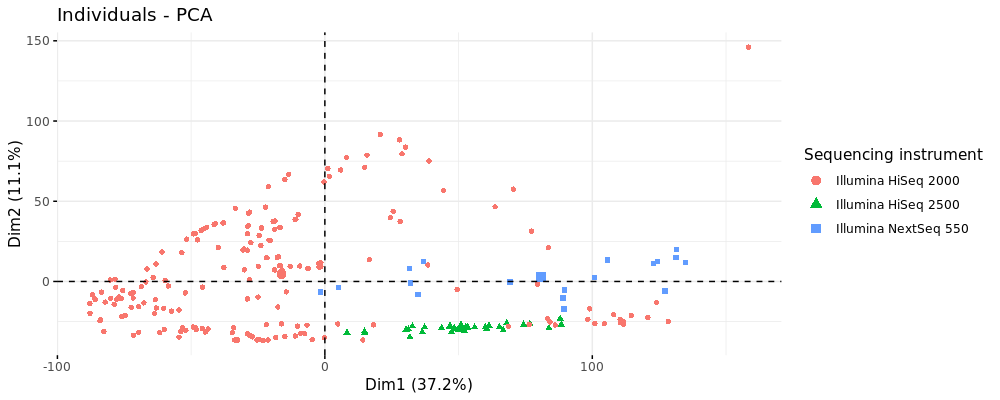

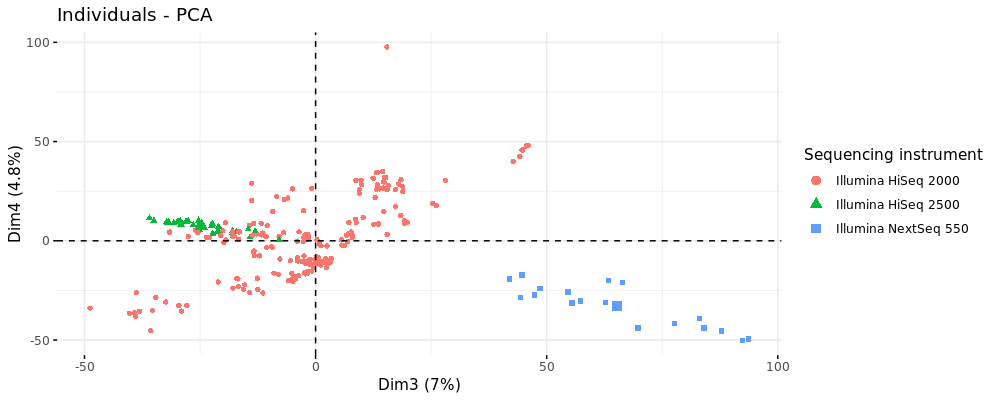

In [81]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 100)
fviz_pca_ind(X = log2_pca_scaled, geom="point", axes = c(1,2), legend.title = "Sequencing instrument", habillage = cnt_meta_log2_scaled$instrument)
fviz_pca_ind(X = log2_pca_scaled, geom="point", axes = c(3,4), legend.title = "Sequencing instrument", habillage = cnt_meta_log2_scaled$instrument)

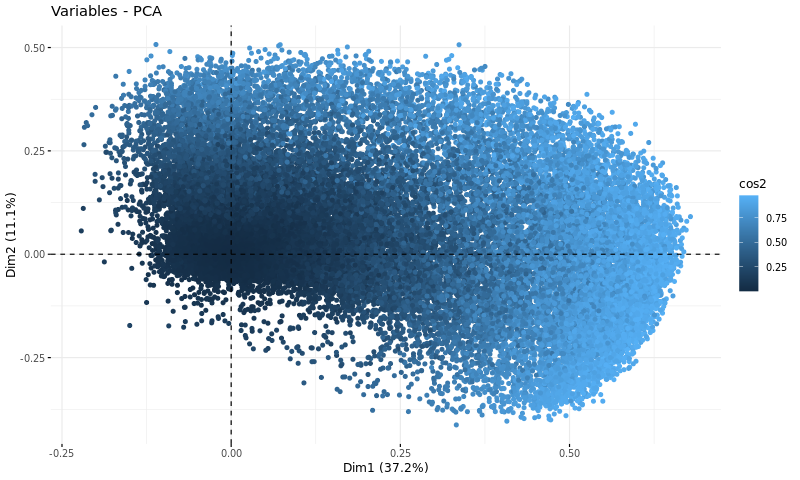

In [82]:
# display variables (genes) colored by quality
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 80)
fviz_pca_var(X = log2_pca_scaled, col.var = "cos2", axes = 1:2, label = "none", geom = "point")

# 1.5 Summarizing all PCA plots

Warning message in brewer.pal(18, "Paired"):
“n too large, allowed maximum for palette Paired is 12
Returning the palette you asked for with that many colors
”

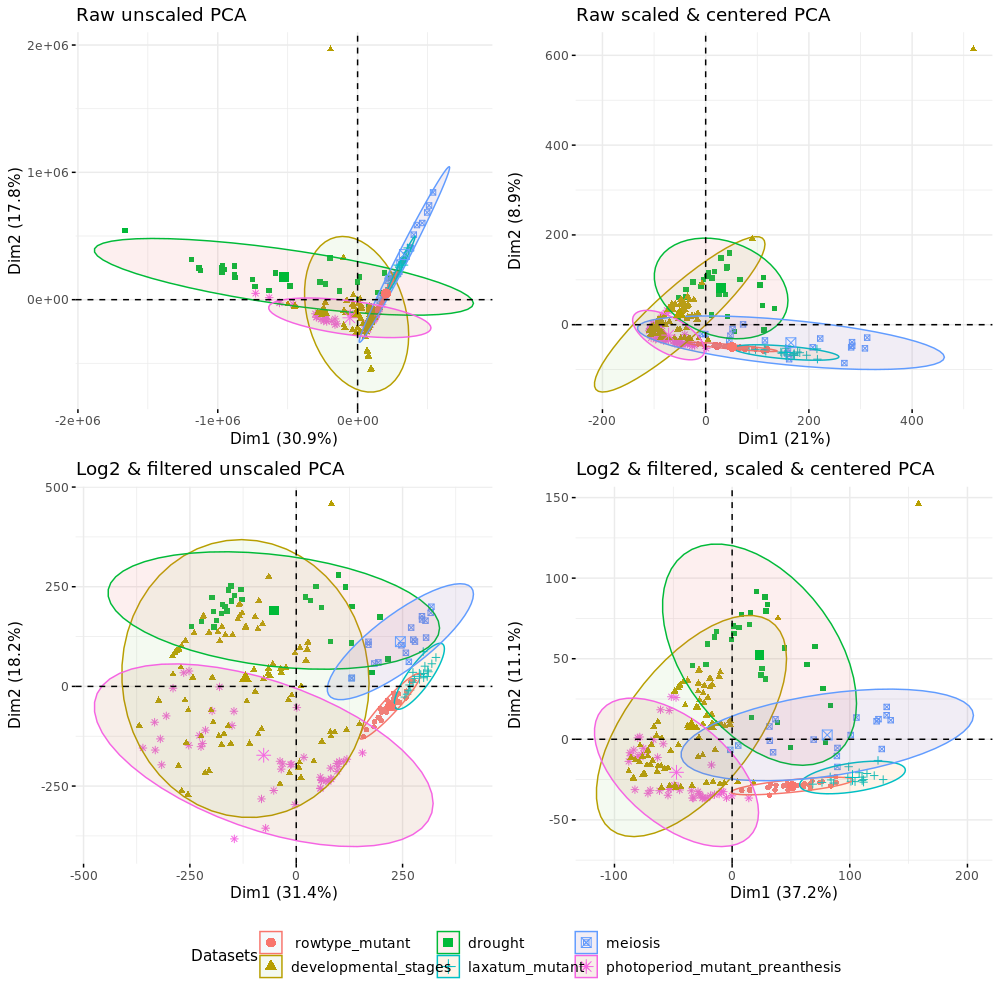

In [83]:
colourCount = length(unique(cnt_log_meta$dataset))
getPalette = colorRampPalette(brewer.pal(18, "Paired"))

options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 100)


p1 <- fviz_pca_ind(X = raw_pca, label = "none", legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2), habillage = cnt_log_meta$dataset) +
                scale_fill_manual(values = getPalette(colourCount)) 

p2 <- fviz_pca_ind(X = raw_pca_scaled, label = "none", legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2), habillage = cnt_log_meta$dataset) +
                scale_fill_manual(values = getPalette(colourCount))

p3 <- fviz_pca_ind(X = log2_pca, label = "none", legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2), habillage = cnt_log_meta$dataset) +
                scale_fill_manual(values = getPalette(colourCount)) 

p4 <- fviz_pca_ind(X = log2_pca_scaled, label = "none", legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2), habillage = cnt_log_meta$dataset) +
                scale_fill_manual(values = getPalette(colourCount))


prow <- plot_grid(p1 + ggtitle("Raw unscaled PCA") + theme(legend.position="none"),
                  p2 + ggtitle("Raw scaled & centered PCA") + theme(legend.position="none"),
                  p3 + ggtitle("Log2 & filtered unscaled PCA") + theme(legend.position="none"),
                  p4 + ggtitle("Log2 & filtered, scaled & centered PCA") + theme(legend.position="none"),
                  align = 'vh', hjust = -1, nrow = 2)

legend <- get_legend(p1 + guides(color = guide_legend(nrow = 2)) + theme(legend.position = "bottom", legend.text=element_text(size=10)))

cowplot::plot_grid(prow, legend, ncol = 1, rel_heights = c(1, .1))

# 2. Defining expression level categories (ELC-analysis)

In [219]:
head(h)
setwd("~/floral_development_thesis_vm/")
saveRDS(h, "tpm_beforeVS_barley.rds")

ERR781039 ERR781040 ERR781041 ERR781042 ERR781043
Horvu_MOREX_1H01G000100 336.0000  122.0000   66.0000  208.0000  354.000  
Horvu_MOREX_1H01G000200   1.0000    0.0000    0.0000    1.0000    1.000  
Horvu_MOREX_1H01G000300 116.0000   56.0000   45.0000   98.0000  108.000  
Horvu_MOREX_1H01G000400 550.0000  184.0000  133.0000  351.0000  549.000  
Horvu_MOREX_1H01G000500 556.0000  167.0000  116.0000  382.0000  511.000  
Horvu_MOREX_1H01G000600 707.3084  260.5543  146.4439  381.1077  572.695  
                        ERR781044 ERR781045 ERR781046 ERR781047 ERR781048 ⋯
Horvu_MOREX_1H01G000100 452.0000  388.0000  405.0000  359.0000   657.000  ⋯
Horvu_MOREX_1H01G000200   1.0000    1.0000    0.0000    0.0000     1.000  ⋯
Horvu_MOREX_1H01G000300 163.0000  160.0000  133.0000  117.0000   284.000  ⋯
Horvu_MOREX_1H01G000400 657.0000  577.0000  605.0000  540.0000  1183.000  ⋯
Horvu_MOREX_1H01G000500 635.0000  772.0000  607.0000  630.0000  1166.000  ⋯
Horvu_MOREX_1H01G000600 776.8168  827.0809  874.5452  566.1862  1397.799  ⋯
                        ERR515188 ERR515189 ERR515190 ERR515191 ERR515192
Horvu_MOREX_1H01G000100 1232.000  2237.000  1503.000  1833.000  1695.000 
Horvu_MOREX_1H01G000200    1.000     3.000    10.000     1.000     2.000 
Horvu_MOREX_1H01G000300  428.000   610.000   519.000   466.000   492.000 
Horvu_MOREX_1H01G000400  971.000  1640.000  1312.000  1160.000  2093.000 
Horvu_MOREX_1H01G000500 3656.000  4336.000  4734.000  4469.000  2296.000 
Horvu_MOREX_1H01G000600 2808.661  3316.393  2766.549  2833.275  2984.255 
                        ERR515193 ERR515194 ERR515195 ERR515196 ERR515197
Horvu_MOREX_1H01G000100 2477.000  2265.000  2578.000  2468.000  2317.000 
Horvu_MOREX_1H01G000200    8.000     6.000     0.000     2.000     2.000 
Horvu_MOREX_1H01G000300  652.000   569.000   677.000   710.000   584.000 
Horvu_MOREX_1H01G000400 2738.000  2795.000  3687.000  3044.000  3045.000 
Horvu_MOREX_1H01G000500 2418.000  2349.000  3908.000  3340.000  3221.000 
Horvu_MOREX_1H01G000600 4250.868  3915.629  4172.974  4106.843  4045.146

In [85]:
non.expr.cutoff=0.5

get_elc=function(x,cut) {
    s=h
    sx=x[x>cut]
    k=kmeans(log(sx+cut),4)
    kk=ordered(k$cluster,levels=order(k$centers))
    levels(kk)=paste("E",1:4,sep="")
    so=ordered(rep("E0",nrow(s)),levels=paste("E",0:4,sep=""))
    so[x>cut]=kk
    so
}
h_elc=apply(h,2,get_elc,non.expr.cutoff)
colnames(h_elc)=colnames(h)
rownames(h_elc)=rownames(h)
head(h_elc)

ERR781039 ERR781040 ERR781041 ERR781042 ERR781043
Horvu_MOREX_1H01G000100 E3        E3        E3        E3        E3       
Horvu_MOREX_1H01G000200 E1        E0        E0        E1        E1       
Horvu_MOREX_1H01G000300 E3        E3        E3        E3        E3       
Horvu_MOREX_1H01G000400 E4        E3        E3        E4        E4       
Horvu_MOREX_1H01G000500 E4        E3        E3        E4        E4       
Horvu_MOREX_1H01G000600 E4        E4        E4        E4        E4       
                        ERR781044 ERR781045 ERR781046 ERR781047 ERR781048 ⋯
Horvu_MOREX_1H01G000100 E3        E3        E3        E3        E3        ⋯
Horvu_MOREX_1H01G000200 E1        E1        E0        E0        E1        ⋯
Horvu_MOREX_1H01G000300 E3        E3        E3        E3        E3        ⋯
Horvu_MOREX_1H01G000400 E4        E4        E4        E4        E4        ⋯
Horvu_MOREX_1H01G000500 E4        E4        E4        E4        E4        ⋯
Horvu_MOREX_1H01G000600 E4        E4        E4        E4        E4        ⋯
                        ERR515188 ERR515189 ERR515190 ERR515191 ERR515192
Horvu_MOREX_1H01G000100 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000200 E1        E1        E1        E1        E1       
Horvu_MOREX_1H01G000300 E3        E3        E3        E3        E3       
Horvu_MOREX_1H01G000400 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000500 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000600 E4        E4        E4        E4        E4       
                        ERR515193 ERR515194 ERR515195 ERR515196 ERR515197
Horvu_MOREX_1H01G000100 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000200 E1        E1        E0        E1        E1       
Horvu_MOREX_1H01G000300 E3        E3        E3        E3        E3       
Horvu_MOREX_1H01G000400 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000500 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000600 E4        E4        E4        E4        E4

In [86]:
elc_df <- as.data.frame(h_elc, stringsAsFactors = FALSE)
elc_df <- pivot_longer(elc_df, cols = c(1:240), names_to = "sample", values_to = "ELC")
glimpse(elc_df)

Rows: 11,827,440
Columns: 2
$ sample <chr> "ERR781039", "ERR781040", "ERR781041", "ERR781042", "ERR781043…
$ ELC    <chr> "E3", "E3", "E3", "E3", "E3", "E3", "E3", "E3", "E3", "E3", "E…


In [87]:
barley_meta_elc <- select(barley_metadata, Run.ID, Dataset, Batch, Cultivar, GM, Zadok_scale, Intermediate_age, High_level_age, Intermediate_tissue, High_level_tissue, Treatment, RNA_extraction, RNA_enrichment, RNA_input..microg., PCR_purification, Growth_condition, Day_night_condition, Temperature_day_night_c, Growth_location, Seq_location, Instrument, Library.layout)
colnames(barley_meta_elc) <- c("sample", "dataset", "batch", "cultivar", "gm", "zadoc_scale", "intermediate_age", "high_level_age", "intermediate_tissue", "high_level_tissue", "treatment", "rna_extraction", "rna_enrichment", "rna_input", "pcr_purification", "growth_condition", "day_night", "temp", "growth_location", "seq_location", "instrument", "library")

elc <- elc_df %>% select(sample, ELC) %>%
                dplyr::group_by(sample) %>%
                dplyr::summarise(total = n(), E0 = sum(ELC=="E0"), E1 = sum(ELC=="E1"), E2 = sum(ELC=="E2"), E3 = sum(ELC=="E3"), E4 = sum(ELC=="E4"))

elc_0 <- elc %>% select(sample, E0, E1, E2, E3, E4) %>%
                pivot_longer(-sample, names_to = "ELC", values_to = "ELC_value")

elc_meta <- inner_join(barley_meta_elc, elc_0, by = "sample")
glimpse(elc)
glimpse(elc_0)
glimpse(elc_meta)

Warning message:
“Column `sample` joining factor and character vector, coercing into character vector”

Rows: 240
Columns: 7
$ sample <chr> "ERR1248084", "ERR1248085", "ERR1248086", "ERR1248087", "ERR12…
$ total  <int> 49281, 49281, 49281, 49281, 49281, 49281, 49281, 49281, 49281,…
$ E0     <int> 22318, 19781, 21225, 20287, 23226, 21089, 26194, 23532, 24795,…
$ E1     <int> 5606, 6678, 6329, 6725, 6281, 6544, 5189, 6404, 5648, 5736, 54…
$ E2     <int> 6246, 6782, 6569, 6676, 5524, 6343, 5467, 6046, 5775, 5775, 59…
$ E3     <int> 8262, 8587, 8556, 8582, 7431, 8206, 7153, 7651, 7620, 7410, 78…
$ E4     <int> 6849, 7453, 6602, 7011, 6819, 7099, 5278, 5648, 5443, 5847, 54…
Rows: 1,200
Columns: 3
$ sample    <chr> "ERR1248084", "ERR1248084", "ERR1248084", "ERR1248084", "ER…
$ ELC       <chr> "E0", "E1", "E2", "E3", "E4", "E0", "E1", "E2", "E3", "E4",…
$ ELC_value <int> 22318, 5606, 6246, 8262, 6849, 19781, 6678, 6782, 8587, 745…
Rows: 1,200
Columns: 24
$ sample              <chr> "ERR781039", "ERR781039", "ERR781039", "ERR781039…
$ dataset             <fct> photoperiod_mutant_preanthesis, pho

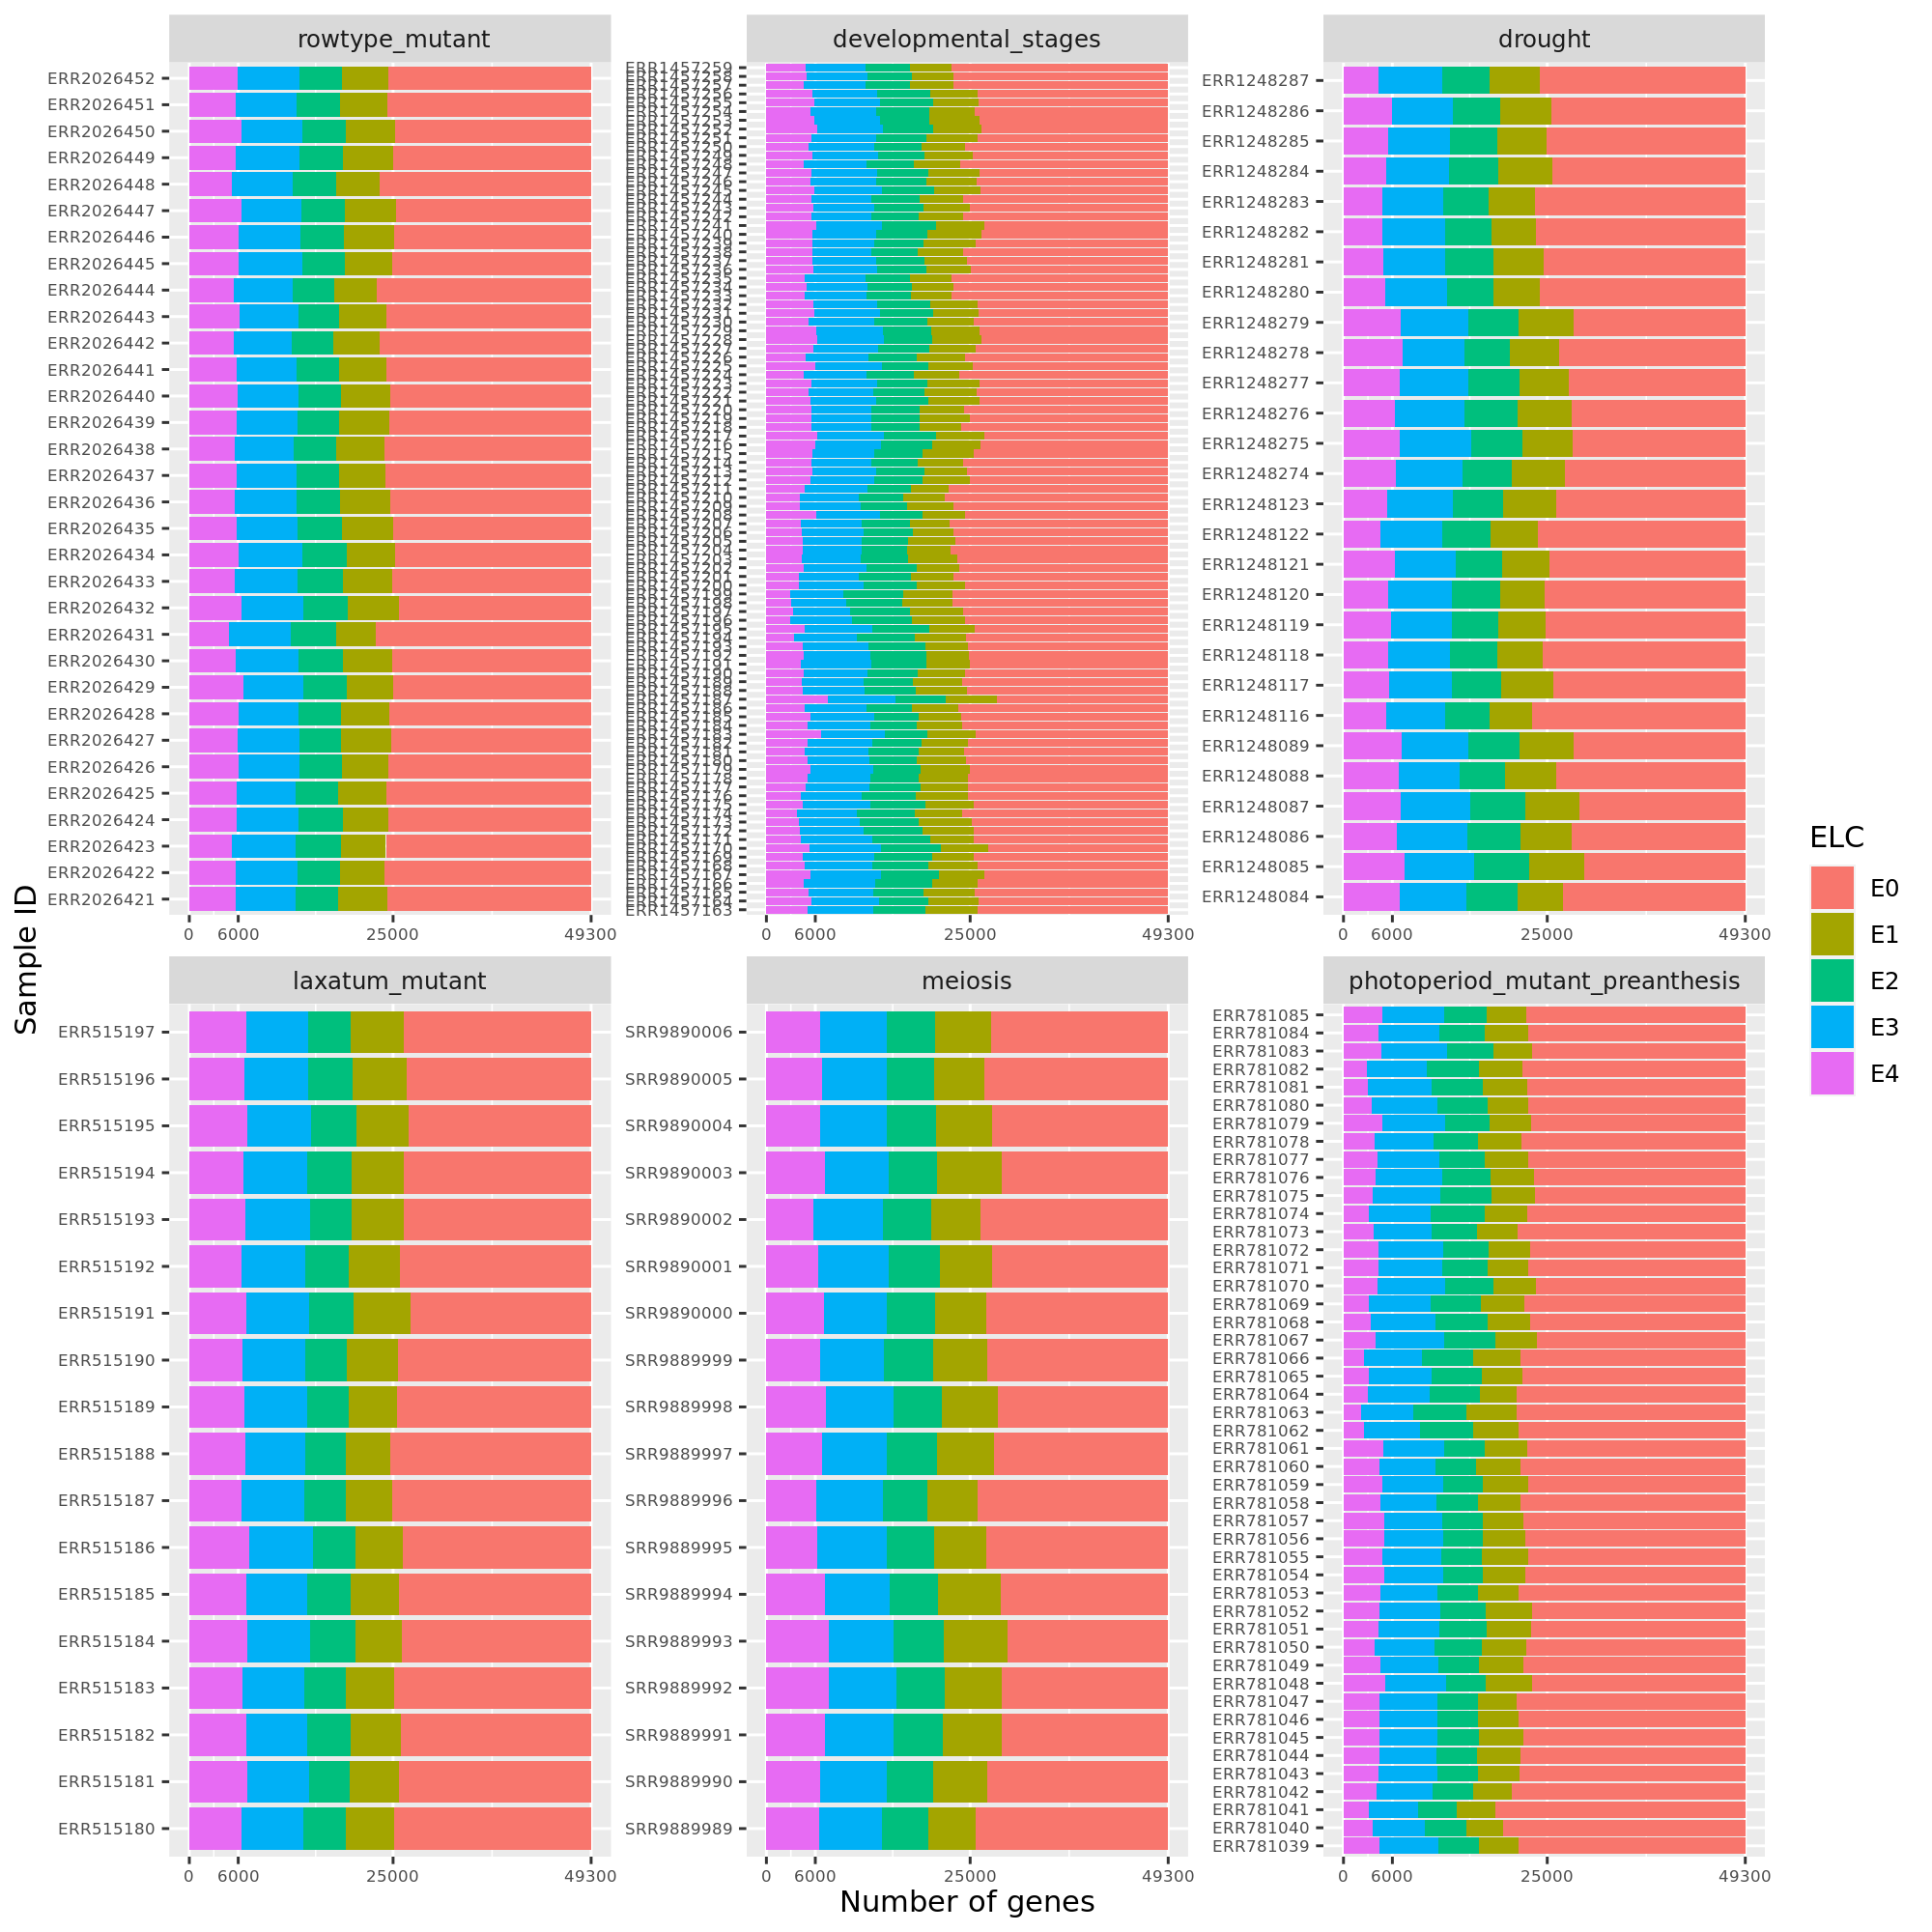

In [88]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200)

elc_meta %>% 
    ggplot(aes(fill = ELC, y = ELC_value, x = sample)) +
        geom_col(position = "stack") +
        coord_flip() +
        labs(x = "Sample ID", y = "Number of genes") +
        scale_y_continuous(breaks =c(0, 6000, 25000, 49300)) +
        facet_wrap( ~ dataset, scales= "free", ncol = 3) +
        theme(axis.text = element_text(size=6))

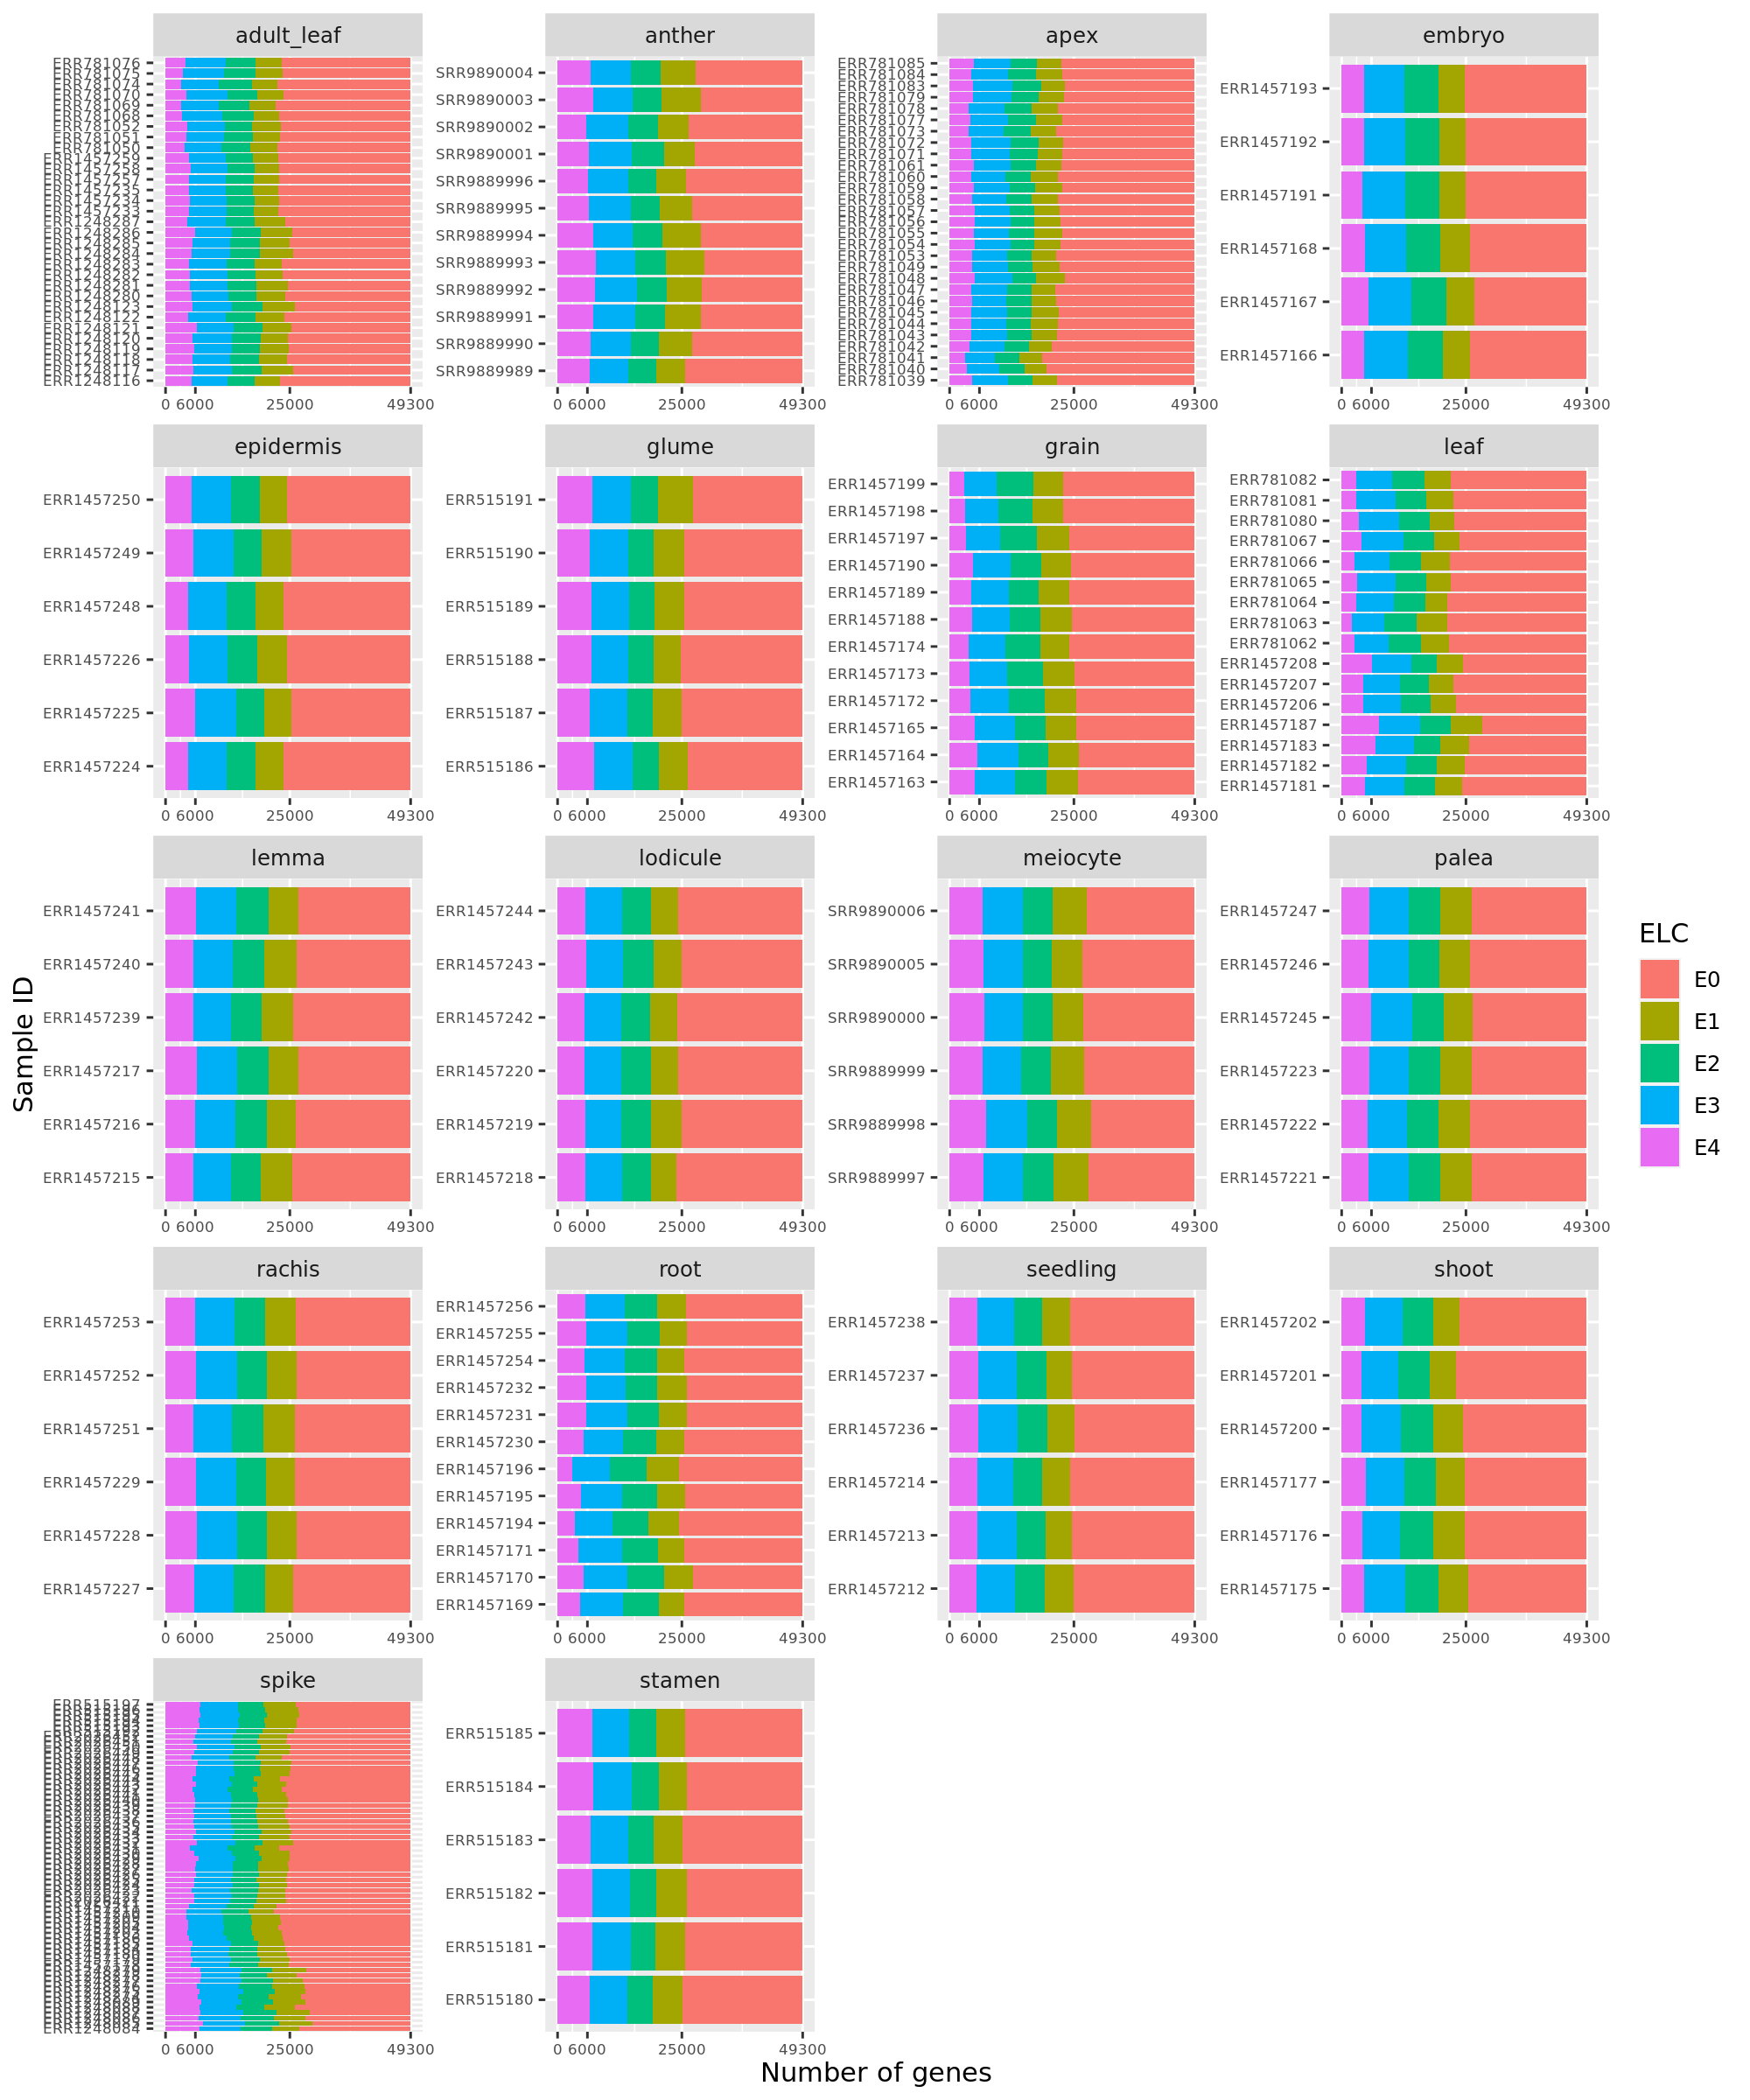

In [89]:
options(repr.plot.width = 10, repr.plot.height = 12, repr.plot.res = 200)

elc_meta %>% 
    ggplot(aes(fill = ELC, y = ELC_value, x = sample)) +
        geom_col(position = "stack") +
        coord_flip() +
        labs(x = "Sample ID", y = "Number of genes") +
        scale_y_continuous(breaks =c(0, 6000, 25000, 49300)) +
        facet_wrap( ~ intermediate_tissue, scales= "free", ncol = 4) +
        theme(axis.text = element_text(size=6))

## 2.1 PCAs on ELCs

In [90]:
elc_pca <- elc %>% transmute(sample = sample, E0 = E0/total, E1 = E1/total, E2 = E2/total, E3 = E3/total, E4 = E4/total)
elc_pca_meta <- inner_join(elc_pca, barley_meta_elc, by = "sample")
elc_pca_meta <- as.data.frame(elc_pca_meta, stringsAsFactors = TRUE)
rownames(elc_pca_meta) <- elc_pca_meta$sample
elc_pca_meta <- select(elc_pca_meta, -sample)
head(elc_pca_meta)

Warning message:
“Column `sample` joining character vector and factor, coercing into character vector”

E0        E1        E2        E3        E4        dataset batch
ERR1248084 0.4528723 0.1137558 0.1267426 0.1676508 0.1389785 drought 17   
ERR1248085 0.4013920 0.1355086 0.1376190 0.1742457 0.1512348 drought 17   
ERR1248086 0.4306934 0.1284268 0.1332968 0.1736166 0.1339664 drought 18   
ERR1248087 0.4116597 0.1364623 0.1354680 0.1741442 0.1422658 drought 18   
ERR1248088 0.4712973 0.1274528 0.1120919 0.1507883 0.1383698 drought 19   
ERR1248089 0.4279337 0.1327895 0.1287109 0.1665145 0.1440515 drought 19   
           cultivar gm zadoc_scale ⋯ rna_enrichment rna_input pcr_purification
ERR1248084 Scarlett wt 41          ⋯ unknown        unknown   unknown         
ERR1248085 Scarlett wt 41          ⋯ unknown        unknown   unknown         
ERR1248086 Scarlett wt 41          ⋯ unknown        unknown   unknown         
ERR1248087 Scarlett wt 41          ⋯ unknown        unknown   unknown         
ERR1248088 Scarlett wt 41          ⋯ unknown        unknown   unknown         
ERR1248089 Scarlett wt 41          ⋯ unknown        unknown   unknown         
           growth_condition day_night  temp       growth_location seq_location
ERR1248084 incubator        controlled controlled Spain           Spain       
ERR1248085 incubator        controlled controlled Spain           Spain       
ERR1248086 incubator        controlled controlled Spain           Spain       
ERR1248087 incubator        controlled controlled Spain           Spain       
ERR1248088 incubator        controlled controlled Spain           Spain       
ERR1248089 incubator        controlled controlled Spain           Spain       
           instrument          library
ERR1248084 Illumina HiSeq 2000 paired 
ERR1248085 Illumina HiSeq 2000 paired 
ERR1248086 Illumina HiSeq 2000 paired 
ERR1248087 Illumina HiSeq 2000 paired 
ERR1248088 Illumina HiSeq 2000 paired 
ERR1248089 Illumina HiSeq 2000 paired

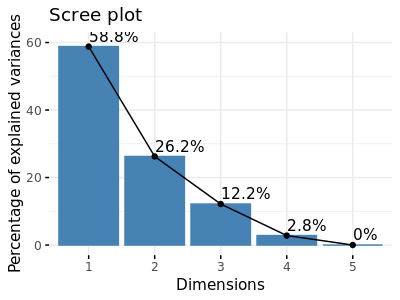

In [91]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 100)

elc_pca <- PCA(elc_pca_meta,quali.sup=6:26,graph=F)
fviz_screeplot(elc_pca, addlabels = TRUE, ylim = c(0, 60))

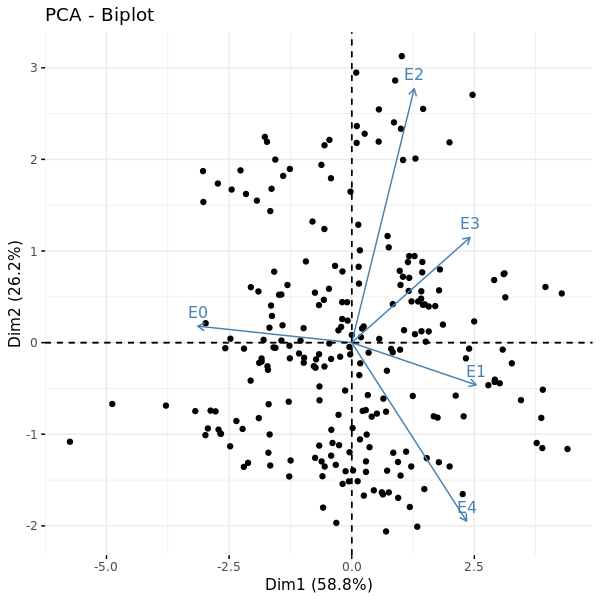

In [92]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_biplot(elc_pca, repel = FALSE,geom="point")

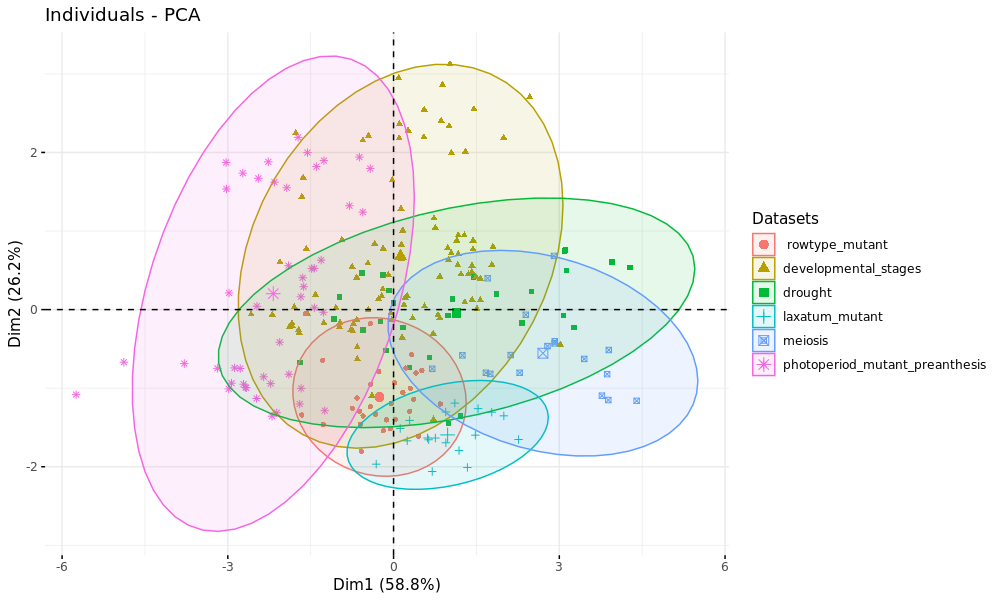

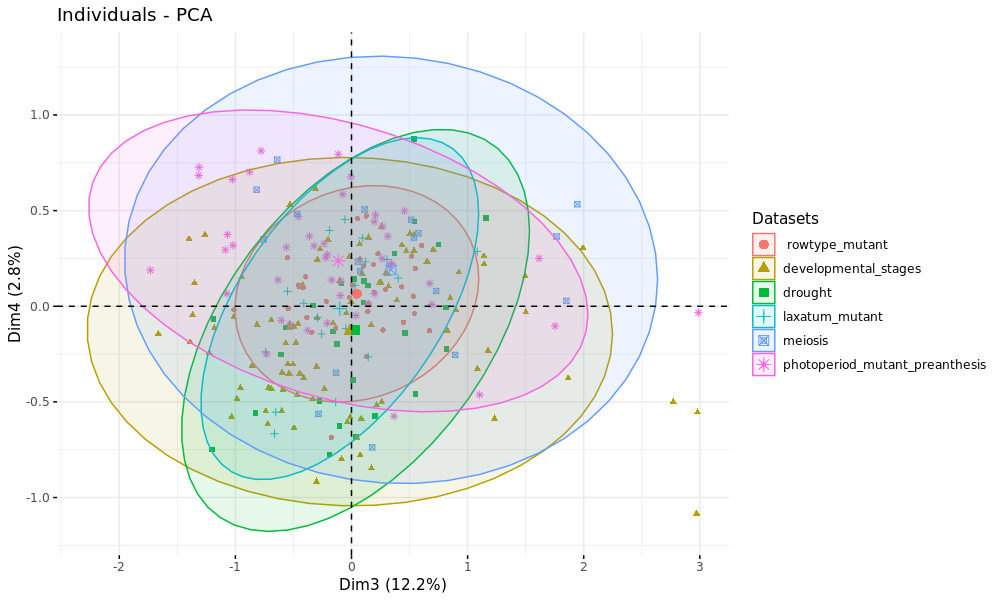

In [93]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_ind(elc_pca, label = "none", habillage = elc_pca_meta$dataset, legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2))
fviz_pca_ind(elc_pca, label = "none", habillage = elc_pca_meta$dataset, legend.title = "Datasets", addEllipses = TRUE, axes = c(3, 4))

In [167]:
# build comparism plot variables
b1 <- fviz_pca_ind(X = elc_pca, label = "none", legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2), habillage = elc_pca_meta$dataset) +
                scale_fill_manual(values = getPalette(colourCount))
b2 <- fviz_pca_ind(X = elc_pca, geom="point", axes = c(1, 2), legend.title = "Library type", habillage = elc_pca_meta$library)
b3 <- fviz_pca_ind(X = elc_pca, geom="point", axes = c(1, 2), legend.title = "Instrument", habillage = elc_pca_meta$instrument)
b4 <- fviz_pca_ind(X = elc_pca, geom="point", axes = c(1, 2), legend.title = "High level tissue", habillage = elc_pca_meta$high_level_tissue)
b5 <- fviz_pca_ind(X = elc_pca, geom="point", axes = c(1, 2), legend.title = "High level age", habillage = elc_pca_meta$high_level_age)

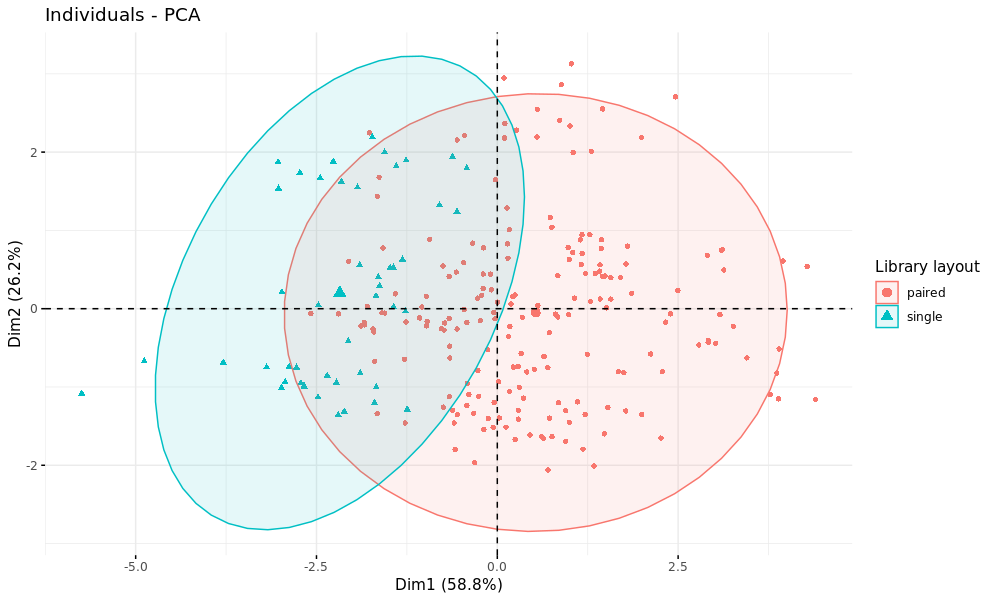

In [94]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_ind(elc_pca, label = "none", habillage = elc_pca_meta$library, legend.title = "Library layout", addEllipses = TRUE, axes = c(1, 2))

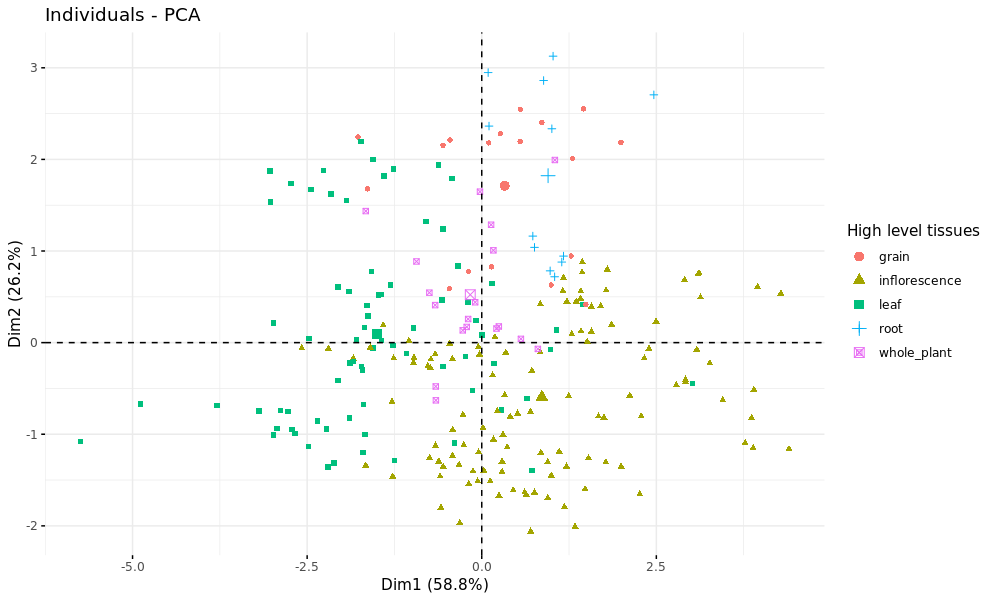

In [95]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_ind(elc_pca, label = "none", habillage = elc_pca_meta$high_level_tissue, legend.title = "High level tissues", axes = c(1, 2))

Dim.1     Dim.2       Dim.3        Dim.4       Dim.5       
E0 0.9915354 0.003256842 3.153607e-06 0.005204599 2.519552e-30
E1 0.6470456 0.021431860 3.021800e-01 0.029342529 2.324387e-31
E2 0.1632293 0.772487864 2.960098e-02 0.034681823 2.433489e-31
E3 0.5858005 0.132716136 2.445397e-01 0.036943718 1.386209e-31
E4 0.5523293 0.382001177 3.127833e-02 0.034391233 9.088246e-31

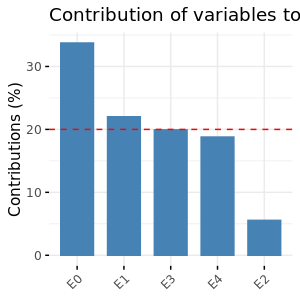

In [96]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 100)
get_pca_var(elc_pca)$cos2
fviz_contrib(elc_pca,"var",top=20,axis=1)

# 3. Library size & log10 counts plots
### 3.1 Quality control: Create long-tables and see log10-transform counts
* here we check how comparable the TPMs are across experiments by making a boxplot of log10-transformed tpm normalized counts
* we have to add a value to avoid log(0), which is 1

In [97]:
# create table of gene_length
length_barley <-data.frame(hord$length)
length_barley <- cbind(geneid = rownames(length_barley), length_barley)
#to remove original rownames:
row.names(length_barley) <- NULL
# for switching between wide and long table formats use "pivotlonger"
long_length_b <- pivot_longer(length_barley, -geneid, names_to = "samples", values_to = "length")
dim(length_barley)
head(length_barley)
head(long_length_b)

[1] 49281   241

geneid                  ERR781039 ERR781040 ERR781041 ERR781042 ERR781043
1 Horvu_MOREX_1H01G000100 3689.0025 3651.8054 3635.7592 3665.6306 3684.3519
2 Horvu_MOREX_1H01G000200 1731.8344 1595.2497 1595.2497 1696.8488 1730.7998
3 Horvu_MOREX_1H01G000300 1290.0993 1282.9072 1294.2130 1281.7899 1287.0755
4 Horvu_MOREX_1H01G000400 2046.4959 1993.5407 1959.2683 2008.9173 2050.0688
5 Horvu_MOREX_1H01G000500  313.4013  303.0055  297.9331  307.9038  310.7067
6 Horvu_MOREX_1H01G000600 2100.0926 2116.8430 2136.8307 2108.0259 2093.3599
  ERR781044 ERR781045 ERR781046 ERR781047 ⋯ ERR515188 ERR515189 ERR515190
1 3665.9270 3654.7407 3671.964  3675.0120 ⋯ 3528.4293 3538.413  3533.5154
2 1678.9842 1675.0597 1595.250  1595.2497 ⋯ 1488.5907 1517.169  1498.8222
3 1289.7471 1275.7873 1290.714  1286.9053 ⋯ 1149.2655 1156.752  1146.5112
4 2002.4680 2003.4146 2019.840  2020.5666 ⋯ 1784.5880 1815.076  1798.6040
5  300.2521  304.2554  305.878   308.3598 ⋯  190.1842  194.778   186.2449
6 2123.6432 2105.0441 2114.484  2107.2312 ⋯ 2057.6173 2053.383  2045.8827
  ERR515191 ERR515192 ERR515193 ERR515194 ERR515195 ERR515196 ERR515197
1 3540.3010 3553.4312 3546.6205 3536.765  3537.0755 3530.3447 3548.3398
2 1491.3869 1554.6326 1534.8636 1512.966  1595.2497 1510.0324 1533.6788
3 1144.9956 1174.6506 1160.3280 1157.042  1162.0225 1140.3119 1158.9743
4 1785.4986 1853.1662 1833.1979 1815.881  1818.7908 1794.9887 1822.8988
5  183.4847  207.4277  195.4666  188.188   195.4046  182.3936  190.1588
6 2059.3659 2057.8005 2044.5578 2038.401  2047.0638 2038.1282 2040.1078

geneid                  samples   length  
1 Horvu_MOREX_1H01G000100 ERR781039 3689.003
2 Horvu_MOREX_1H01G000100 ERR781040 3651.805
3 Horvu_MOREX_1H01G000100 ERR781041 3635.759
4 Horvu_MOREX_1H01G000100 ERR781042 3665.631
5 Horvu_MOREX_1H01G000100 ERR781043 3684.352
6 Horvu_MOREX_1H01G000100 ERR781044 3665.927

In [98]:
#convert filtered count matrix into dataframe
cnt_barley_df <- data.frame(geneid = rownames(bcp_filtered), bcp_filtered, stringsAsFactors = TRUE)
#cnt <- cbind(GeneID = rownames(cnt), cnt)
#to remove original rownames:
row.names(cnt_barley_df) <- NULL
dim(cnt_barley_df)
head(cnt_barley_df)
long_cnt_b <- pivot_longer(cnt_barley_df, -geneid, names_to = "samples", values_to = "count")
head(long_cnt_b)

[1] 42775   241

geneid                  ERR781039 ERR781040 ERR781041 ERR781042 ERR781043
1 Horvu_MOREX_1H01G000100 336.0000  122.0000   66.0000  208.0000  354.000  
2 Horvu_MOREX_1H01G000200   1.0000    0.0000    0.0000    1.0000    1.000  
3 Horvu_MOREX_1H01G000300 116.0000   56.0000   45.0000   98.0000  108.000  
4 Horvu_MOREX_1H01G000400 550.0000  184.0000  133.0000  351.0000  549.000  
5 Horvu_MOREX_1H01G000500 556.0000  167.0000  116.0000  382.0000  511.000  
6 Horvu_MOREX_1H01G000600 707.3084  260.5543  146.4439  381.1077  572.695  
  ERR781044 ERR781045 ERR781046 ERR781047 ⋯ ERR515188 ERR515189 ERR515190
1 452.0000  388.0000  405.0000  359.0000  ⋯ 1232.000  2237.000  1503.000 
2   1.0000    1.0000    0.0000    0.0000  ⋯    1.000     3.000    10.000 
3 163.0000  160.0000  133.0000  117.0000  ⋯  428.000   610.000   519.000 
4 657.0000  577.0000  605.0000  540.0000  ⋯  971.000  1640.000  1312.000 
5 635.0000  772.0000  607.0000  630.0000  ⋯ 3656.000  4336.000  4734.000 
6 776.8168  827.0809  874.5452  566.1862  ⋯ 2808.661  3316.393  2766.549 
  ERR515191 ERR515192 ERR515193 ERR515194 ERR515195 ERR515196 ERR515197
1 1833.000  1695.000  2477.000  2265.000  2578.000  2468.000  2317.000 
2    1.000     2.000     8.000     6.000     0.000     2.000     2.000 
3  466.000   492.000   652.000   569.000   677.000   710.000   584.000 
4 1160.000  2093.000  2738.000  2795.000  3687.000  3044.000  3045.000 
5 4469.000  2296.000  2418.000  2349.000  3908.000  3340.000  3221.000 
6 2833.275  2984.255  4250.868  3915.629  4172.974  4106.843  4045.146

geneid                  samples   count
1 Horvu_MOREX_1H01G000100 ERR781039 336  
2 Horvu_MOREX_1H01G000100 ERR781040 122  
3 Horvu_MOREX_1H01G000100 ERR781041  66  
4 Horvu_MOREX_1H01G000100 ERR781042 208  
5 Horvu_MOREX_1H01G000100 ERR781043 354  
6 Horvu_MOREX_1H01G000100 ERR781044 452

In [99]:
logtransform <- semi_join(long_cnt_b, long_length_b, by = "geneid")
dim(logtransform)

Warning message:
“Column `geneid` joining factors with different levels, coercing to character vector”

[1] 10266000        3

In [100]:
logtransform <- logtransform %>% dplyr::mutate(minTPM = min(count[count>0]), log10TPM = log10(count+1))
head(logtransform)

geneid                  samples   count minTPM       log10TPM
1 Horvu_MOREX_1H01G000100 ERR781039 336   9.650079e-09 2.527630
2 Horvu_MOREX_1H01G000100 ERR781040 122   9.650079e-09 2.089905
3 Horvu_MOREX_1H01G000100 ERR781041  66   9.650079e-09 1.826075
4 Horvu_MOREX_1H01G000100 ERR781042 208   9.650079e-09 2.320146
5 Horvu_MOREX_1H01G000100 ERR781043 354   9.650079e-09 2.550228
6 Horvu_MOREX_1H01G000100 ERR781044 452   9.650079e-09 2.656098

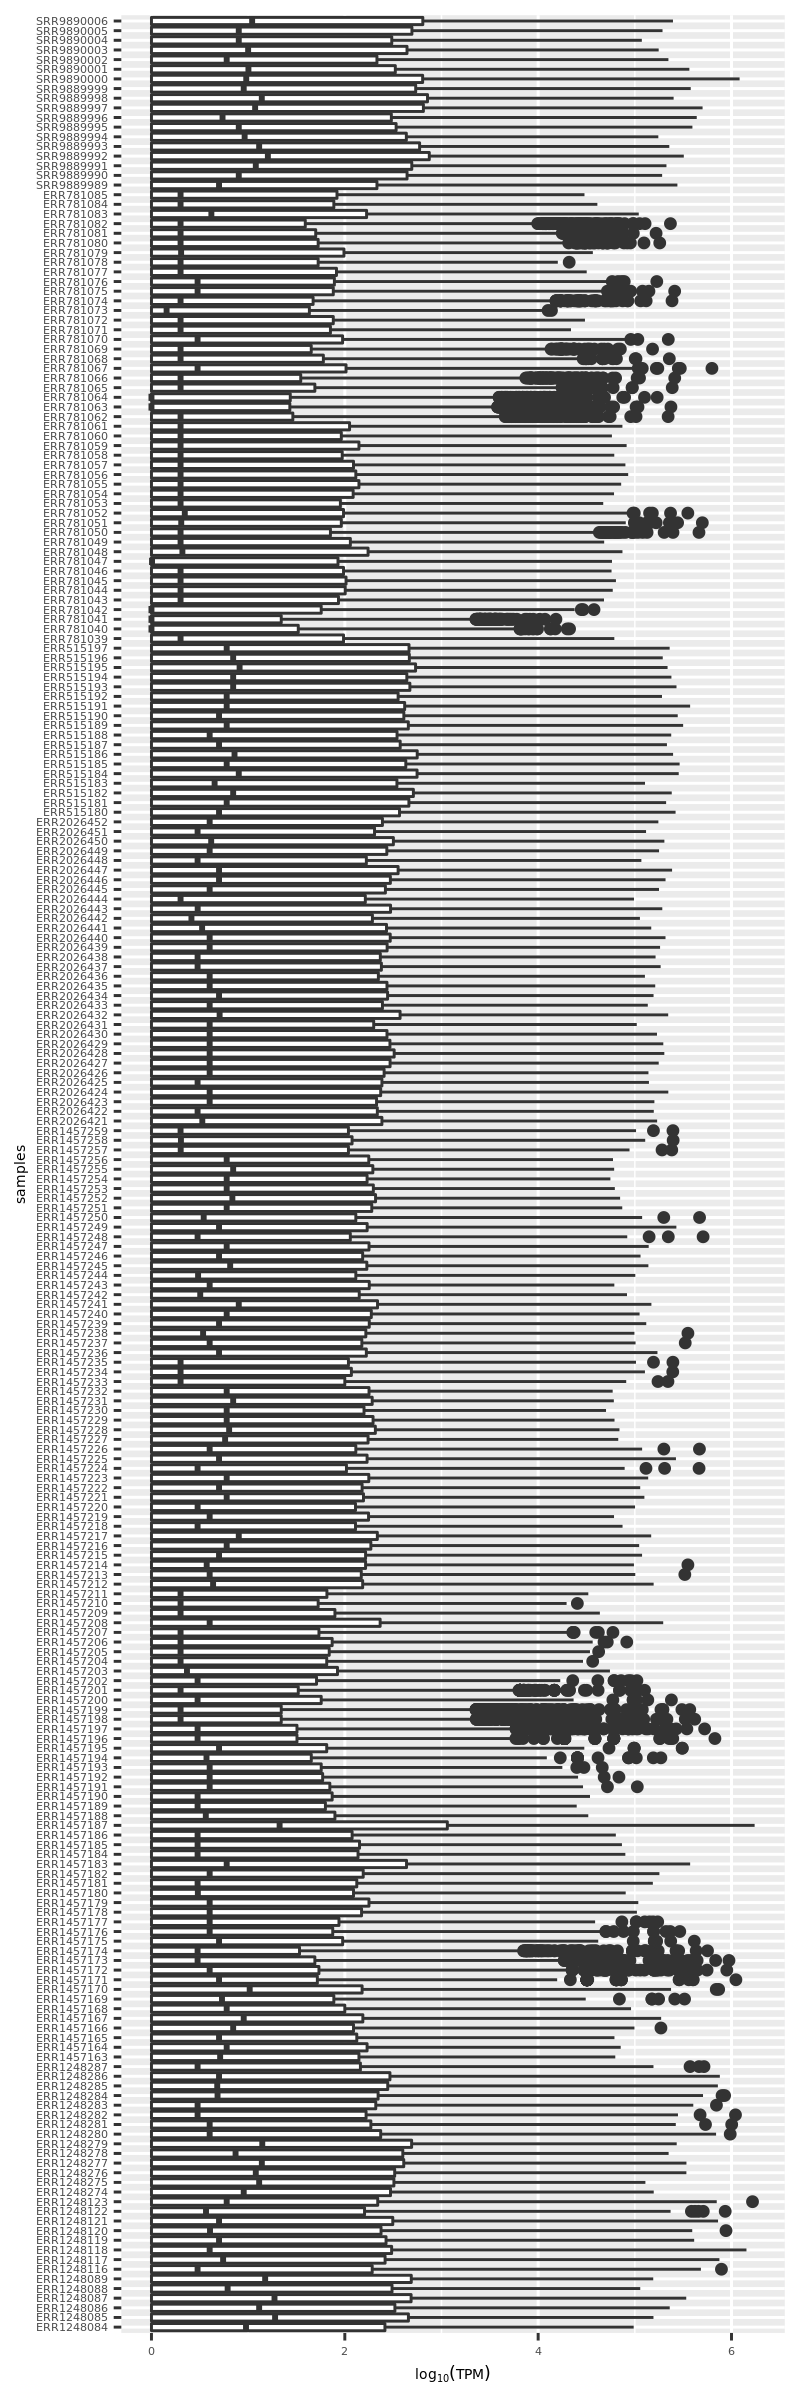

In [41]:
options(repr.plot.width = 4, repr.plot.height = 12, repr.plot.res = 200)
ggplot(logtransform, aes(x=samples, y=log10TPM)) + geom_boxplot() + coord_flip() + ylab(expression(log[10](TPM))) + theme(text = element_text(size = 5))

## 3.2 Plot library size differences

Warning message:
“Column `ID` joining factor and character vector, coercing into character vector”

ID        dataset                        instrument          library
1 ERR781039 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
2 ERR781040 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
3 ERR781041 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
4 ERR781042 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
5 ERR781043 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
6 ERR781044 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
  intermediate_age high_level_age intermediate_tissue high_level_tissue
1 Germination      Seedling       apex                leaf             
2 Germination      Seedling       apex                leaf             
3 Germination      Seedling       apex                leaf             
4 Leaf_development Seedling       apex                leaf             
5 Leaf_development Seedling       apex                leaf             
6 Leaf_development Seedling       apex                leaf             
  n       
1 44898393
2 44588570
3 44524255
4 44629928
5 44858498
6 44881329

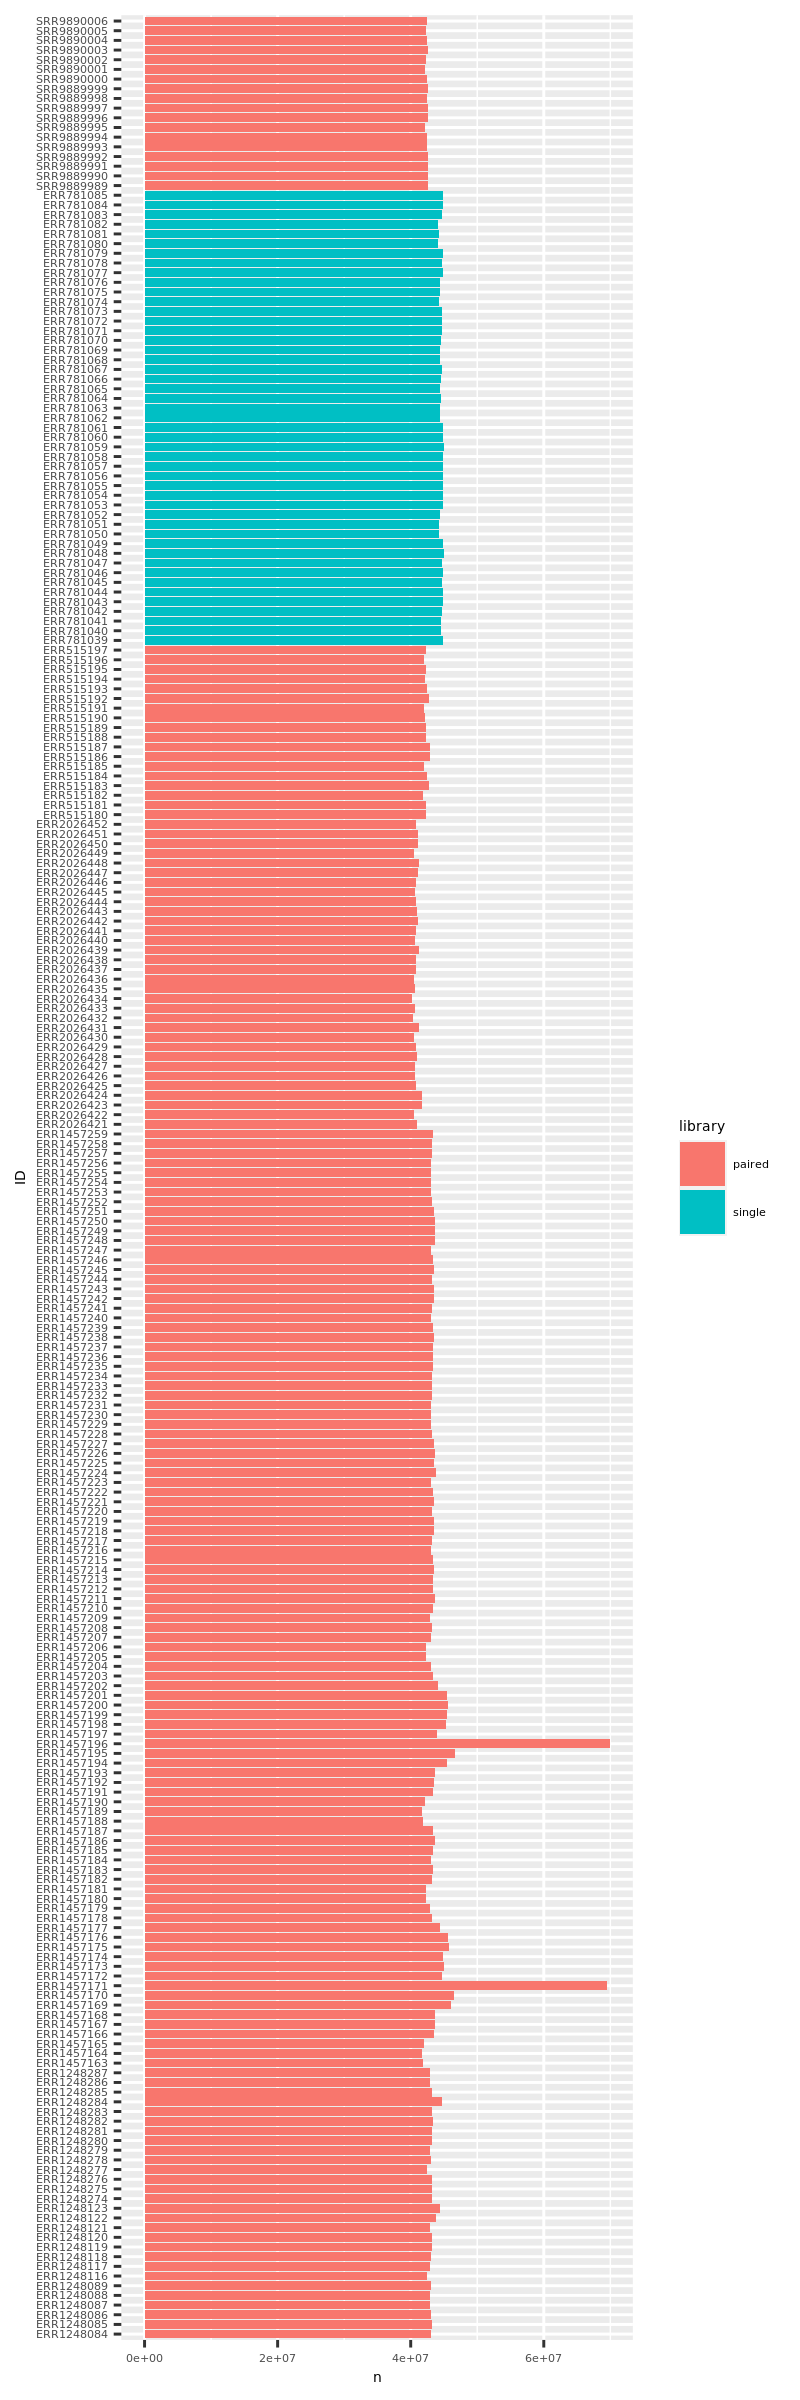

In [158]:
options(repr.plot.width = 4, repr.plot.height = 12, repr.plot.res = 200)
lib <- as.data.frame(length_barley, stringsAsFactors = FALSE)
libsize <- lib %>% select(-geneid) %>% mutate_each(funs(sum)) %>% slice(1) %>% gather("ID", "n", 1:240)
#libsize$n <- log2(libsize$n)
libsize <- inner_join(barley_mix_meta, libsize, by = "ID")
head(libsize)
libsize %>% ggplot(aes(x = ID, y = n, fill =library)) + geom_col() + coord_flip() + theme(text = element_text(size = 5))

# 4. Normalization with `r-sleuth`
## 4.1 Variance Stabilization on raw TPM counts
* based on all the exploratory analysis 2(+1) main technical variables are majorly responsible for the clustering of the counts: `dataset`, `library` and `instrument`
* these 3 variables has to go to the design matrix: as their numbering and division borders are the same, `dataset` alone covers for all of them, and including all would cause linearity in the model
* source: https://pachterlab.github.io/sleuth/about
* 

In [187]:
library(sleuth)

In [206]:
# load tx2gene object for mRNA mapping information
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
m <- read.delim("barley_tx2gene.tsv",stringsAsFactors=FALSE)
colnames(m) <- c("target_id", "gene")
head(m)

target_id                 gene                   
1 Horvu_MOREX_1H01G000100.1 Horvu_MOREX_1H01G000100
2 Horvu_MOREX_1H01G000200.1 Horvu_MOREX_1H01G000200
3 Horvu_MOREX_1H01G000300.1 Horvu_MOREX_1H01G000300
4 Horvu_MOREX_1H01G000700.1 Horvu_MOREX_1H01G000700
5 Horvu_MOREX_1H01G000800.1 Horvu_MOREX_1H01G000800
6 Horvu_MOREX_1H01G001400.1 Horvu_MOREX_1H01G001400

In [211]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", barley_meta$ID, "abundance.h5")
names(files) <- paste0(barley_meta$ID)
head(files)
all(file.exists(files))

ERR781039 
"../04_Kallisto_allreads_symlinked/ERR781039/abundance.h5" 
                                                 ERR781040 
"../04_Kallisto_allreads_symlinked/ERR781040/abundance.h5" 
                                                 ERR781041 
"../04_Kallisto_allreads_symlinked/ERR781041/abundance.h5" 
                                                 ERR781042 
"../04_Kallisto_allreads_symlinked/ERR781042/abundance.h5" 
                                                 ERR781043 
"../04_Kallisto_allreads_symlinked/ERR781043/abundance.h5" 
                                                 ERR781044 
"../04_Kallisto_allreads_symlinked/ERR781044/abundance.h5"

[1] TRUE

In [215]:
s2c <- mutate(barley_mix_meta, path = files, sample = ID)
head (s2c)

ID        dataset                        instrument          library
1 ERR781039 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
2 ERR781040 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
3 ERR781041 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
4 ERR781042 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
5 ERR781043 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
6 ERR781044 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
  intermediate_age high_level_age intermediate_tissue high_level_tissue
1 Germination      Seedling       apex                leaf             
2 Germination      Seedling       apex                leaf             
3 Germination      Seedling       apex                leaf             
4 Leaf_development Seedling       apex                leaf             
5 Leaf_development Seedling       apex                leaf             
6 Leaf_development Seedling       apex                leaf             
  path                                                     sample   
1 ../04_Kallisto_allreads_symlinked/ERR781039/abundance.h5 ERR781039
2 ../04_Kallisto_allreads_symlinked/ERR781040/abundance.h5 ERR781040
3 ../04_Kallisto_allreads_symlinked/ERR781041/abundance.h5 ERR781041
4 ../04_Kallisto_allreads_symlinked/ERR781042/abundance.h5 ERR781042
5 ../04_Kallisto_allreads_symlinked/ERR781043/abundance.h5 ERR781043
6 ../04_Kallisto_allreads_symlinked/ERR781044/abundance.h5 ERR781044

In [217]:
# construct the sleuth-object
so <- sleuth_prep(sample_to_covariates = s2c, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
................................................................................................................................................................................................................................................
normalizing est_counts
20174 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
20174 genes passed the filter
summarizing bootstraps
.................................................
..................................................
..................................................
..................................................
.........................................


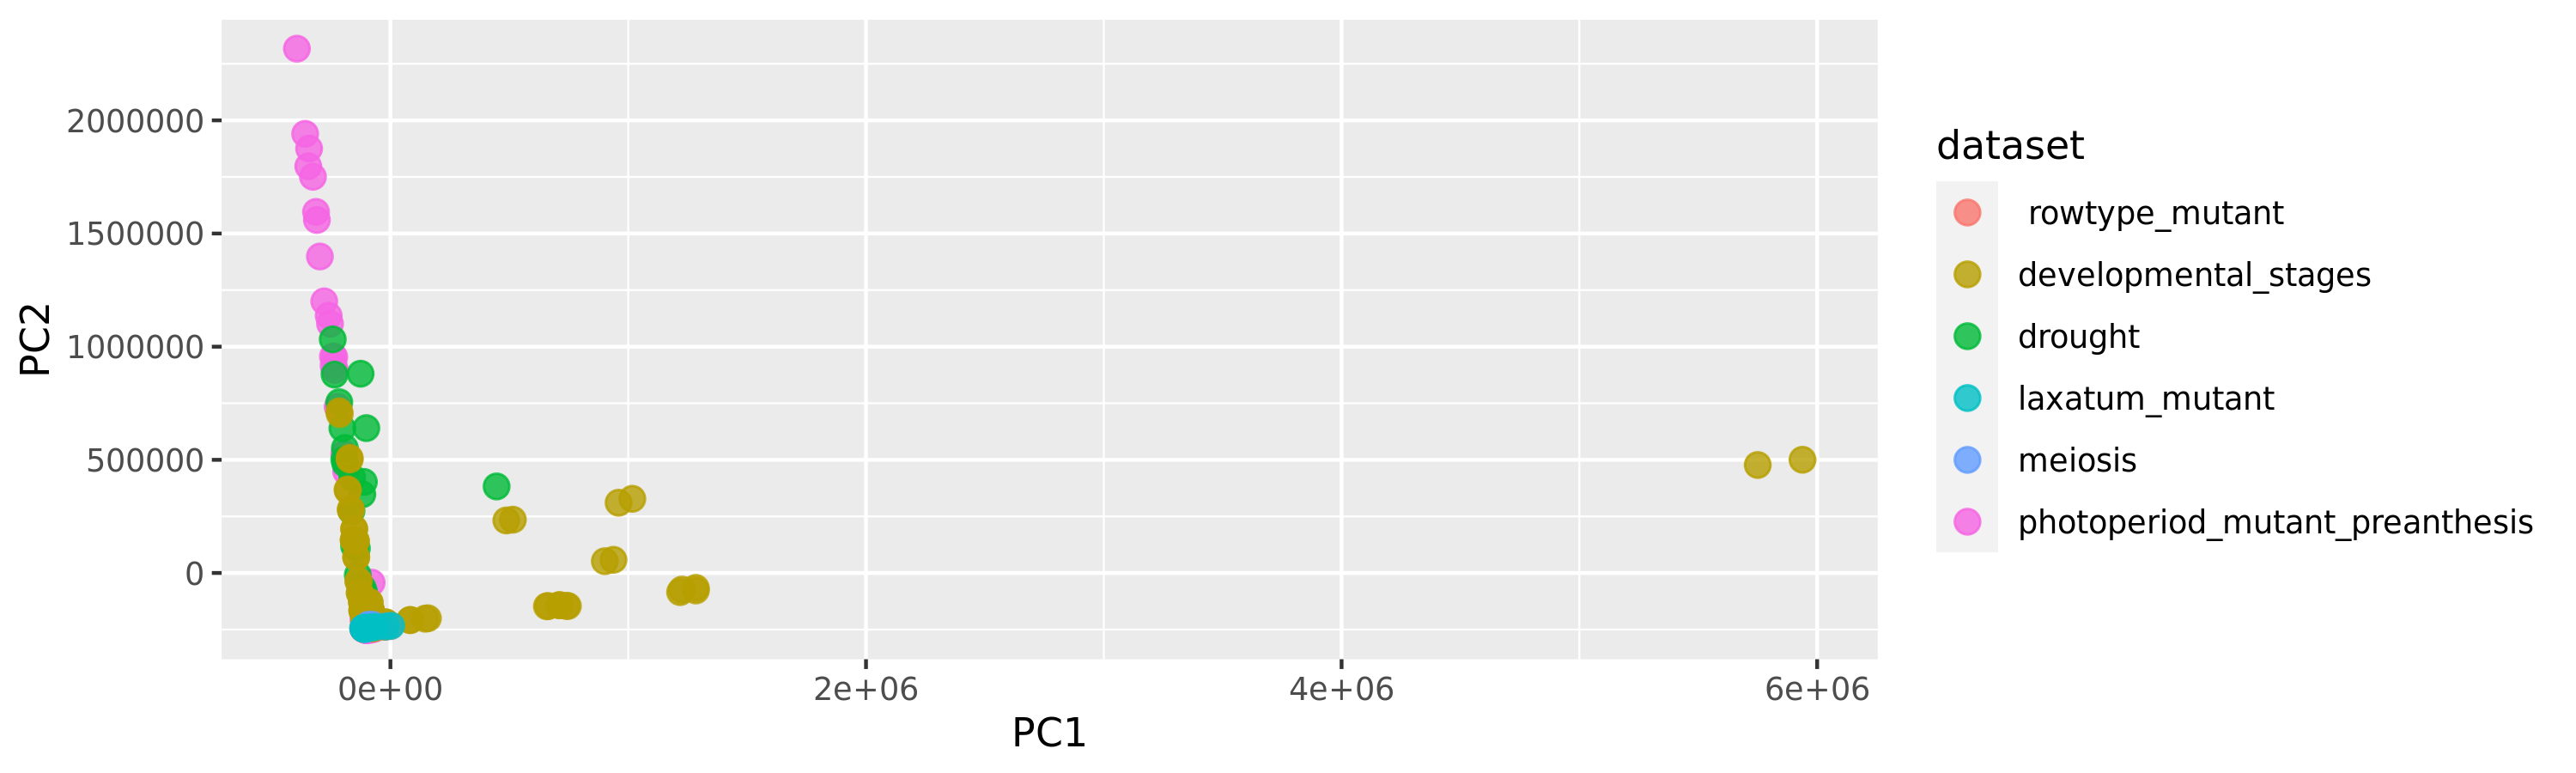

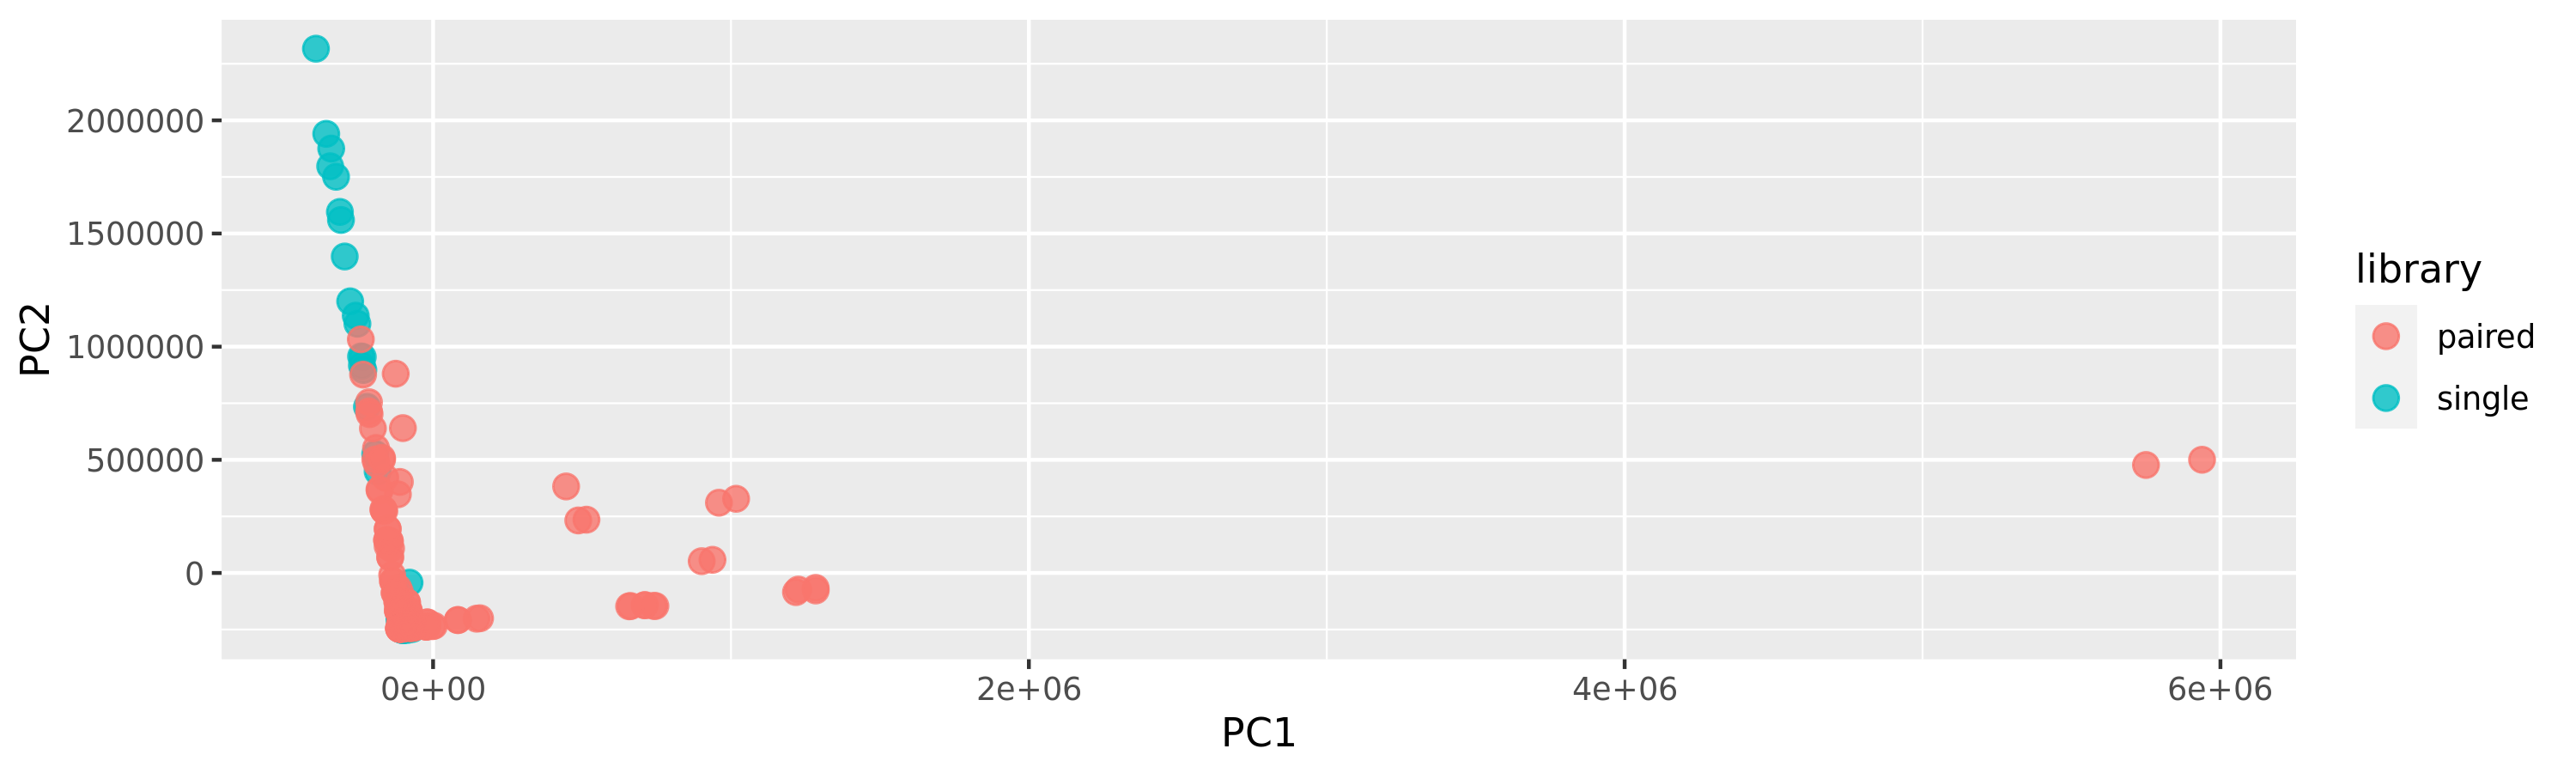

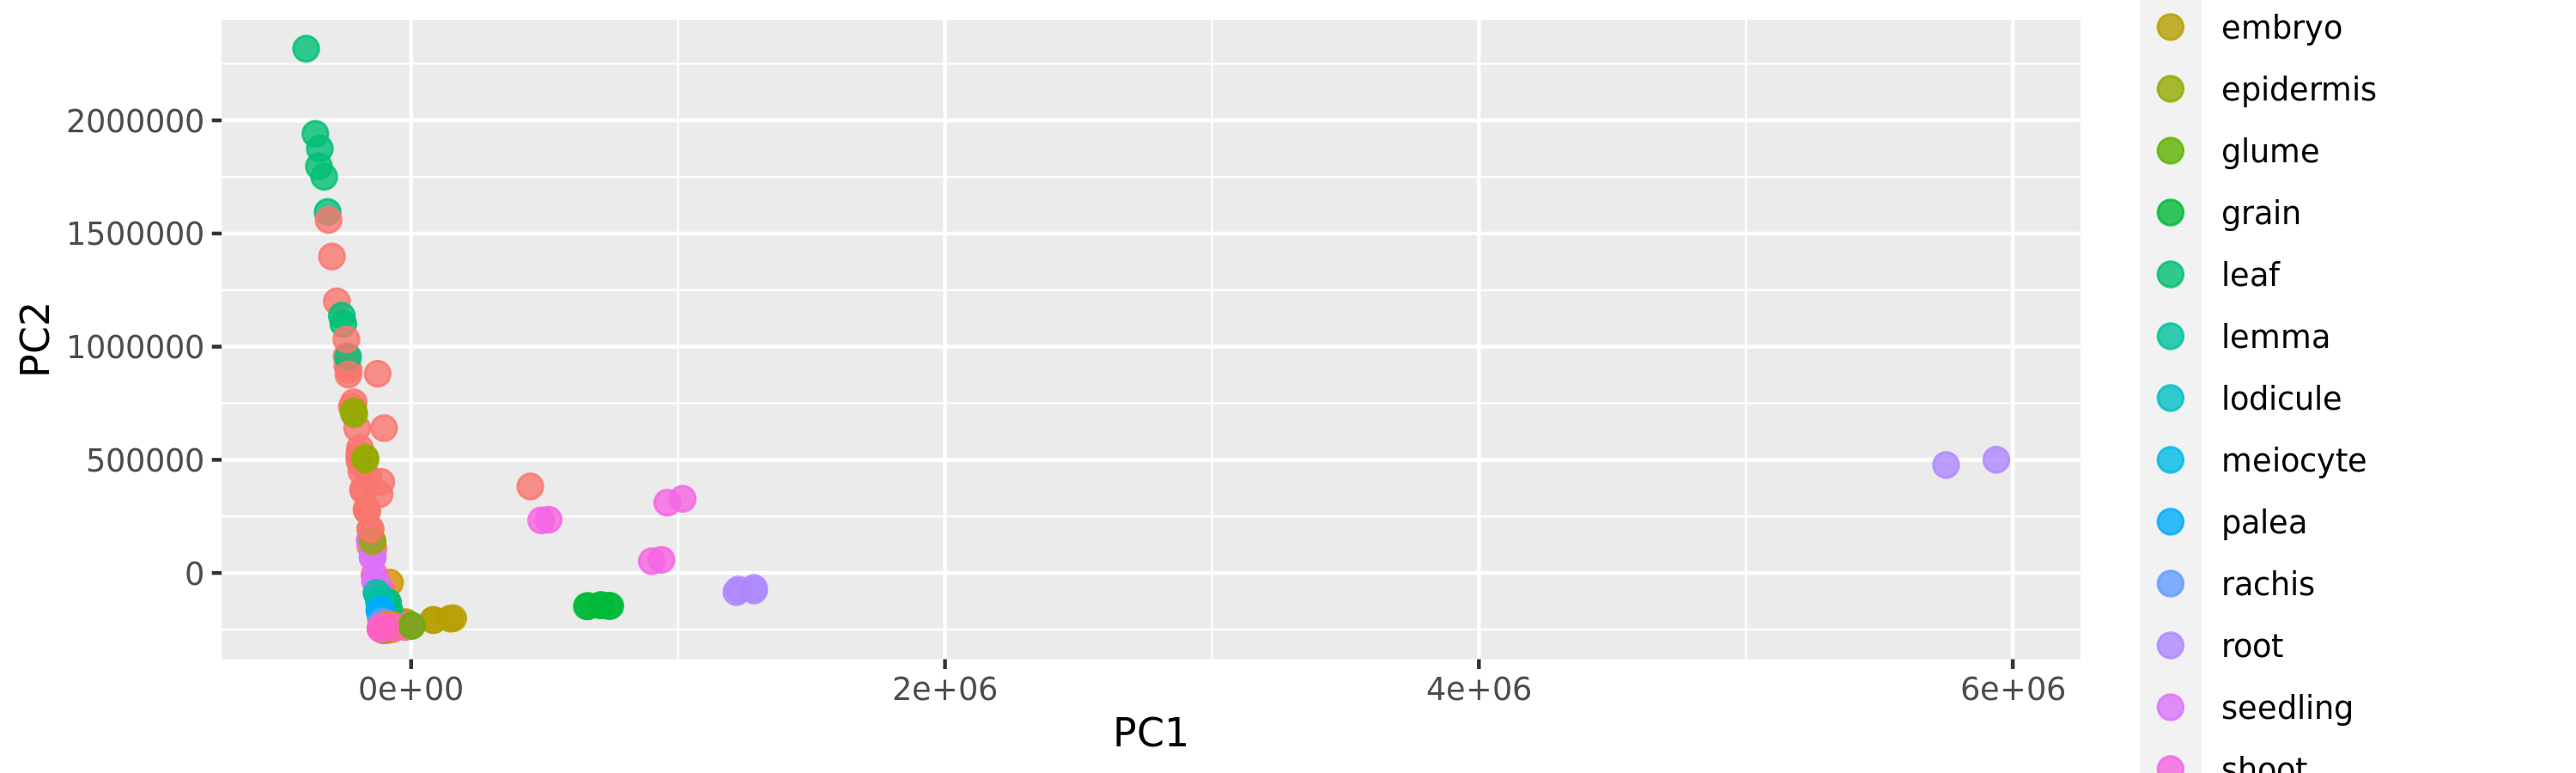

In [223]:
# check for pca
plot_pca(so, color_by = 'dataset',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so, color_by = 'library',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so, color_by = 'intermediate_tissue',text_labels = FALSE,units='scaled_reads_per_base')

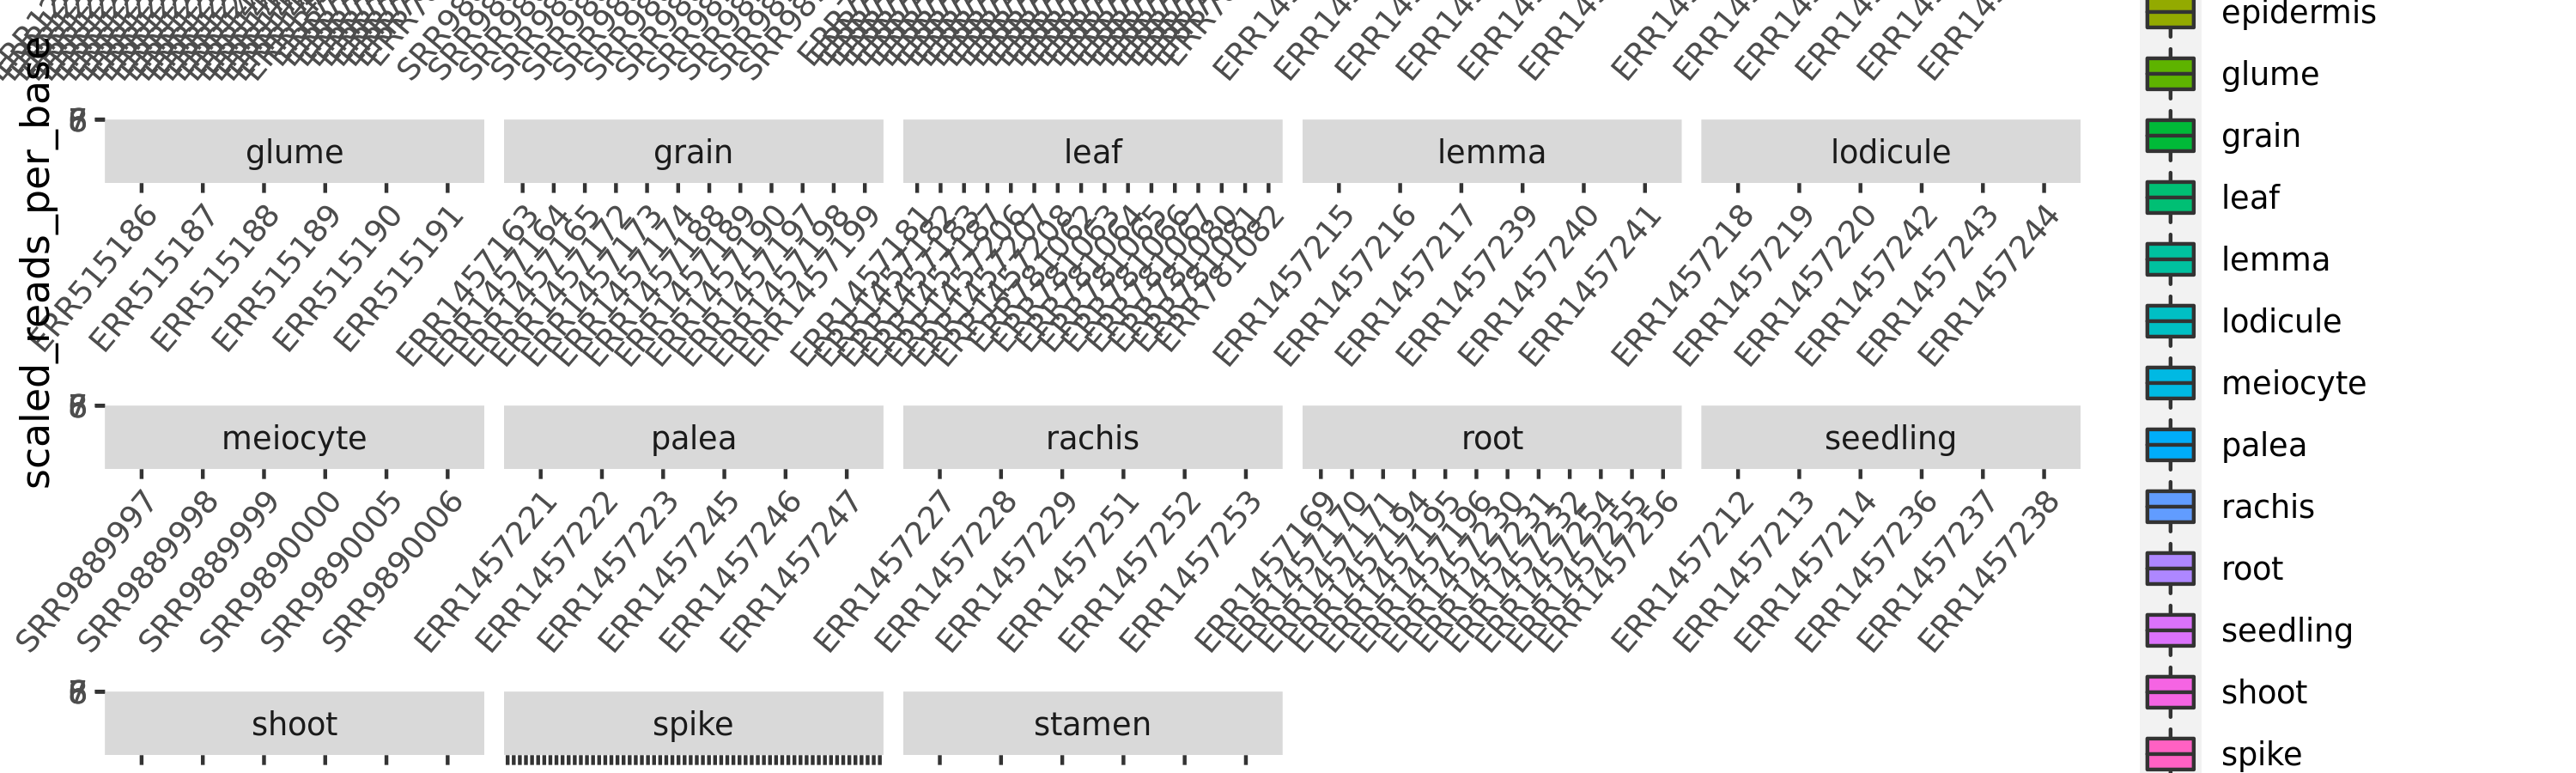

In [225]:
# check for bootstrapping
plot_bootstrap(so, 'Horvu_MOREX_1H01G000100', color_by = 'intermediate_tissue',units='scaled_reads_per_base')

In [ ]:
# fit the full model
so <- sleuth_fit(so, ~dataset, 'full')
full_design = model.matrix(formula(~ dataset),data=D)
reduced_design = model.matrix(formula(~ 1),data=D)

In [ ]:
# fit the reduced model
so <- sleuth_fit(so, ~1, 'reduced')

# 5. Confirming normalization efficiency with PCAs on VS & log2-transformed counts

In [221]:
dim(vsdMat_barley) # this is a matrix with log2 transformed & variance stabilized tpm counts
head(vsdMat_barley)
setwd("~/floral_development_thesis_vm/")
saveRDS(vsdMat_barley, "tpm_afterVS_barley.rds")

[1] 42706   240

ERR781039 ERR781040  ERR781041 ERR781042 ERR781043
Horvu_MOREX_1H01G000100  8.971205  9.0915053 8.8603373 9.088455  9.251617 
Horvu_MOREX_1H01G000200  2.032568  0.7690516 0.7690516 2.417079  2.119921 
Horvu_MOREX_1H01G000300  7.392429  7.9090290 8.2240799 7.949748  7.495719 
Horvu_MOREX_1H01G000400  9.633976  9.6600084 9.8631971 9.812757  9.833075 
Horvu_MOREX_1H01G000500  9.209902  9.0920873 9.2371056 9.493164  9.305107 
Horvu_MOREX_1H01G000600 10.040565 10.1591207 9.9553844 9.944255  9.947375 
                        ERR781044 ERR781045 ERR781046  ERR781047 ERR781048 ⋯
Horvu_MOREX_1H01G000100  9.273224  9.107799  9.1918150 9.2295198  9.073098 ⋯
Horvu_MOREX_1H01G000200  1.996646  2.018025  0.7690516 0.7690516  1.718469 ⋯
Horvu_MOREX_1H01G000300  7.744141  7.781908  7.5321793 7.5639975  7.809411 ⋯
Horvu_MOREX_1H01G000400  9.788147  9.650166  9.7358363 9.7842084  9.872906 ⋯
Horvu_MOREX_1H01G000500  9.329708  9.640423  9.3168378 9.5706457  9.402129 ⋯
Horvu_MOREX_1H01G000600 10.027684 10.179341 10.2834250 9.8742546 10.164439 ⋯
                        ERR515188 ERR515189 ERR515190 ERR515191 ERR515192
Horvu_MOREX_1H01G000100  8.814588  9.334160  8.897559  9.111361  9.416545
Horvu_MOREX_1H01G000200  1.443195  1.787491  2.635639  1.383437  1.743979
Horvu_MOREX_1H01G000300  7.347209  7.512144  7.425992  7.208823  7.666285
Horvu_MOREX_1H01G000400  8.562007  8.956992  8.781917  8.548428  9.763854
Horvu_MOREX_1H01G000500 10.546183 10.424536 10.747563 10.617897  9.907260
Horvu_MOREX_1H01G000600  9.964155  9.873234  9.750279  9.706618 10.206053
                        ERR515193 ERR515194 ERR515195  ERR515196 ERR515197
Horvu_MOREX_1H01G000100  9.498462  9.491989  9.4454356  9.468640  9.420817
Horvu_MOREX_1H01G000200  2.384026  2.248940  0.7690516  1.605307  1.613222
Horvu_MOREX_1H01G000300  7.623178  7.550687  7.5616247  7.737956  7.487454
Horvu_MOREX_1H01G000400  9.699532  9.860888 10.0242175  9.850826  9.879299
Horvu_MOREX_1H01G000500  9.601091  9.732085 10.1772478 10.133684 10.071750
Horvu_MOREX_1H01G000600 10.258014 10.262496 10.1151201 10.181710 10.208648

In [109]:
# switching rows to columns
vs <- t(vsdMat_barley)
vs <- as.data.frame(vs, stringsAsFactors = TRUE)
# adding rownames=ID as a column
vs <- cbind(ID = rownames(vs), vs)
rownames(vs) <- vs$ID
dim(vs)
# include metadata table
vs_meta <- inner_join(barley_mix_meta, vs, by = "ID")
# add rownames again
rownames(vs_meta) <- vs_meta$ID
# convert variables which are not factor into factor that they could be part of pca
# this part depends on the used metadata-variables
#vs_meta$rna_input<-factor(vs_meta$rna_input)
#vs_meta$batch<-factor(vs_meta$batch)
#class(vs_meta$rna_input)
#class(vs_meta$batch)
# change factor levels where extra levels are present from single dataset: inf_dev & tf_q for dataset, 21 for temp
vs_meta <- droplevels(vs_meta)
# delete ID column to not have it as extra supplementary variable
vs_meta <- select(vs_meta, -ID)
# create classes to check on class types -> pca can handle supplementary variables only as factors!
classes <- sapply(X = vs_meta, FUN = class)
table(classes)
which(classes == 'factor')
dim(vs_meta)
head(vs_meta)

[1]   240 42707

classes
 factor numeric 
      7   42706 

dataset          instrument             library    intermediate_age 
                  1                   2                   3                   4 
     high_level_age intermediate_tissue   high_level_tissue 
                  5                   6                   7

[1]   240 42713

dataset                        instrument          library
ERR781039 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
ERR781040 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
ERR781041 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
ERR781042 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
ERR781043 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
ERR781044 photoperiod_mutant_preanthesis Illumina HiSeq 2000 single 
          intermediate_age high_level_age intermediate_tissue high_level_tissue
ERR781039 Germination      Seedling       apex                leaf             
ERR781040 Germination      Seedling       apex                leaf             
ERR781041 Germination      Seedling       apex                leaf             
ERR781042 Leaf_development Seedling       apex                leaf             
ERR781043 Leaf_development Seedling       apex                leaf             
ERR781044 Leaf_development Seedling       apex                leaf             
          Horvu_MOREX_1H01G000100 Horvu_MOREX_1H01G000200
ERR781039 8.971205                2.0325681              
ERR781040 9.091505                0.7690516              
ERR781041 8.860337                0.7690516              
ERR781042 9.088455                2.4170793              
ERR781043 9.251617                2.1199213              
ERR781044 9.273224                1.9966460              
          Horvu_MOREX_1H01G000300 ⋯ Horvu_MOREX_Un01G109600
ERR781039 7.392429                ⋯ 0.7690516              
ERR781040 7.909029                ⋯ 0.7690516              
ERR781041 8.224080                ⋯ 0.7690516              
ERR781042 7.949748                ⋯ 0.7690516              
ERR781043 7.495719                ⋯ 0.7690516              
ERR781044 7.744141                ⋯ 0.7690516              
          Horvu_MOREX_Un01G109700 Horvu_MOREX_Un01G109800
ERR781039 0.7690516               2.6279634              
ERR781040 0.7690516               4.5471741              
ERR781041 0.7690516               0.7690516              
ERR781042 2.3610908               0.7690516              
ERR781043 0.7690516               2.7508079              
ERR781044 0.7690516               2.5687895              
          Horvu_MOREX_Un01G109900 Horvu_MOREX_Un01G110000
ERR781039 0.7690516               3.2669183              
ERR781040 0.7690516               0.7690516              
ERR781041 0.7690516               0.7690516              
ERR781042 2.6427499               3.5455882              
ERR781043 2.5887584               2.7515742              
ERR781044 0.7690516               0.7690516              
          Horvu_MOREX_Un01G110100 Horvu_MOREX_Un01G110300
ERR781039 2.1471080               1.8973878              
ERR781040 0.7690516               0.7690516              
ERR781041 2.7822711               0.7690516              
ERR781042 0.7690516               0.7690516              
ERR781043 0.7690516               0.7690516              
ERR781044 0.7690516               0.7690516              
          Horvu_MOREX_Un01G110400 Horvu_MOREX_Un01G110500
ERR781039 0.7690516               0.7690516              
ERR781040 0.7690516               3.3911169              
ERR781041 0.7690516               0.7690516              
ERR781042 0.7690516               2.3034971              
ERR781043 0.7690516               2.0326540              
ERR781044 0.7690516               1.9056168              
          Horvu_MOREX_Un01G110600
ERR781039 0.7690516              
ERR781040 0.7690516              
ERR781041 0.7690516              
ERR781042 0.7690516              
ERR781043 0.7690516              
ERR781044 0.7690516

In [112]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 100)
vs_pca <- PCA(X = vs_meta, scale.unit = FALSE, ncp = 4, quali.sup = c(1:7), graph = F)
#summary(raw_pca)

eigenvalue percentage of variance cumulative percentage of variance
comp 1 27011.744  32.496635              32.49663                         
comp 2 11717.474  14.096775              46.59341                         
comp 3  5993.409   7.210406              53.80382                         
comp 4  4491.110   5.403056              59.20687                         
comp 5  3946.441   4.747789              63.95466                         
comp 6  3582.051   4.309407              68.26407

Warning message in brewer.pal(18, "Paired"):
“n too large, allowed maximum for palette Paired is 12
Returning the palette you asked for with that many colors
”

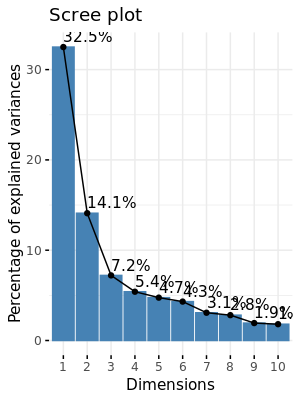

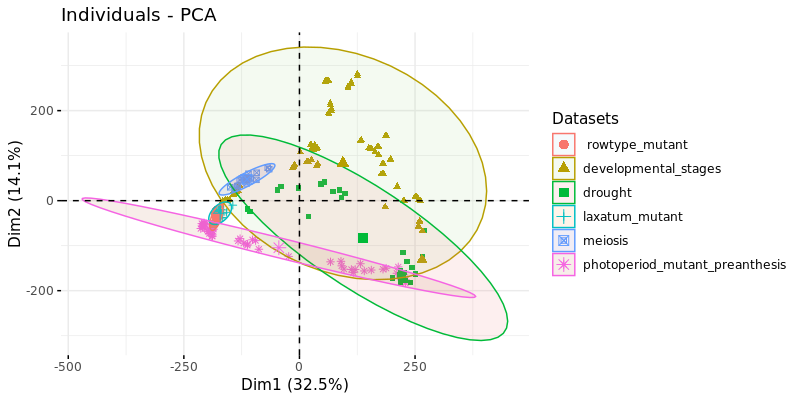

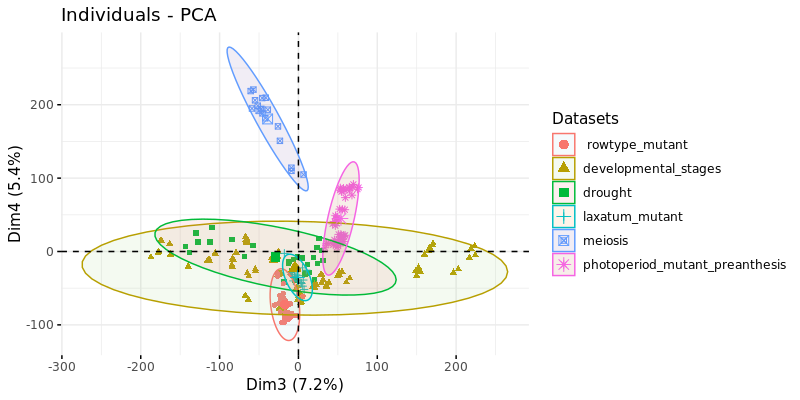

In [113]:
options(repr.plot.width = 3, repr.plot.height = 4, repr.plot.res = 100)
# display eigenvalues
head(vs_pca$eig)
# display scree plot
fviz_eig(vs_pca, addlabels = TRUE)
# display individuals (samples) colored by technical variable
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 100)
colourCount = length(unique(vs_meta$dataset))
getPalette = colorRampPalette(brewer.pal(18, "Paired"))
fviz_pca_ind(X = vs_pca, label = "none", legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2), habillage = vs_meta$dataset) +
                scale_fill_manual(values = getPalette(colourCount))
fviz_pca_ind(X = vs_pca, label = "none", legend.title = "Datasets", addEllipses = TRUE, axes = c(3, 4), habillage = vs_meta$dataset) +
                scale_fill_manual(values = getPalette(colourCount))

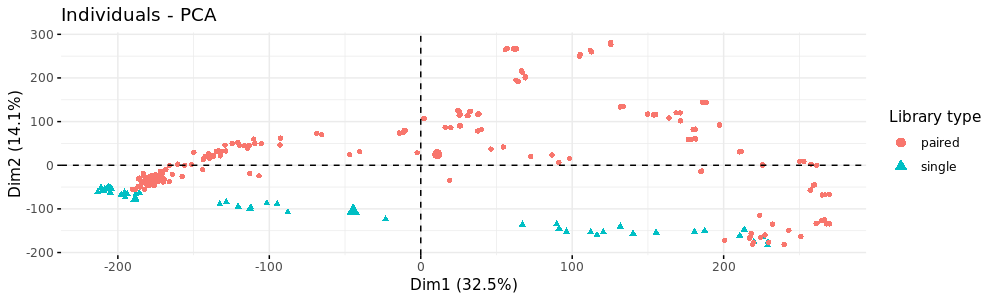

In [114]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 100)
fviz_pca_ind(X = vs_pca, geom="point", axes = c(1, 2), legend.title = "Library type", habillage = vs_meta$library)

In [168]:
# build comparism plot variables
c1 <- fviz_pca_ind(X = vs_pca, label = "none", legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2), habillage = vs_meta$dataset) +
                scale_fill_manual(values = getPalette(colourCount))
c2 <- fviz_pca_ind(X = vs_pca, geom="point", axes = c(1, 2), legend.title = "Library type", habillage = vs_meta$library)
c3 <- fviz_pca_ind(X = vs_pca, geom="point", axes = c(1, 2), legend.title = "Instrument", habillage = vs_meta$instrument)
c4 <- fviz_pca_ind(X = vs_pca, geom="point", axes = c(1, 2), legend.title = "High level tissue", habillage = vs_meta$high_level_tissue)
c5 <- fviz_pca_ind(X = vs_pca, geom="point", axes = c(1, 2), legend.title = "High level age", habillage = vs_meta$high_level_age)

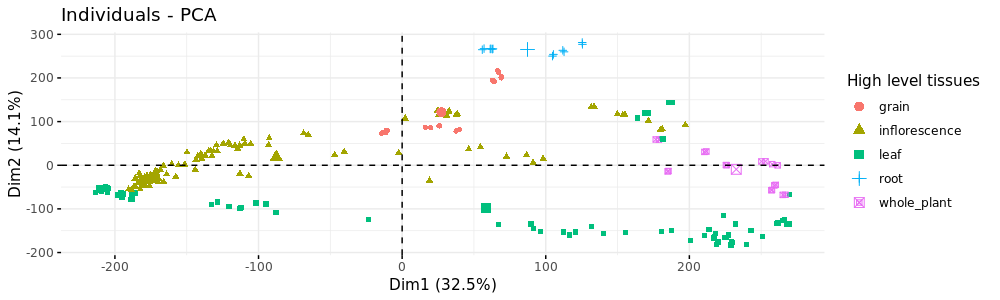

In [115]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 100)
fviz_pca_ind(X = vs_pca, geom="point", axes = c(1, 2), legend.title = "High level tissues", habillage = vs_meta$high_level_tissue)

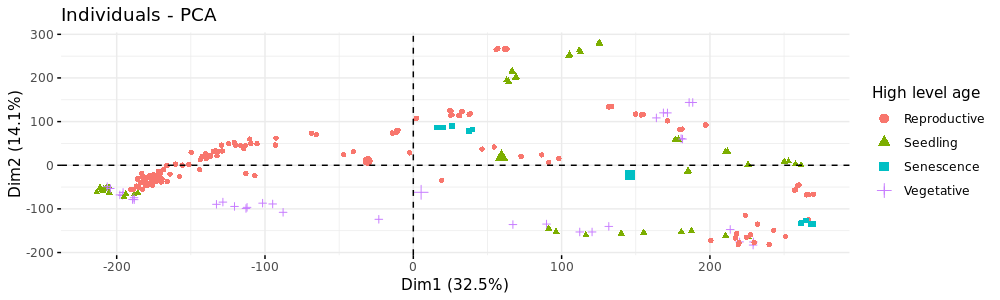

In [116]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 100)
fviz_pca_ind(X = vs_pca, geom="point", axes = c(1, 2), legend.title = "High level age", habillage = vs_meta$high_level_age)

# 6. Confirming normalization efficiency with ELC-analysis & PCAs

In [117]:
non.expr.cutoff=0.5

get_elc=function(x,cut) {
    s=vsdMat_barley
    sx=x[x>cut]
    k=kmeans(log(sx+cut),4)
    kk=ordered(k$cluster,levels=order(k$centers))
    levels(kk)=paste("E",1:4,sep="")
    so=ordered(rep("E0",nrow(s)),levels=paste("E",0:4,sep=""))
    so[x>cut]=kk
    so
}
vs_elc=apply(vsdMat_barley,2,get_elc,non.expr.cutoff)
colnames(vs_elc)=colnames(vsdMat_barley)
rownames(vs_elc)=rownames(vsdMat_barley)
head(vs_elc)

ERR781039 ERR781040 ERR781041 ERR781042 ERR781043
Horvu_MOREX_1H01G000100 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000200 E2        E1        E1        E2        E2       
Horvu_MOREX_1H01G000300 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000400 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000500 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000600 E4        E4        E4        E4        E4       
                        ERR781044 ERR781045 ERR781046 ERR781047 ERR781048 ⋯
Horvu_MOREX_1H01G000100 E4        E4        E4        E4        E4        ⋯
Horvu_MOREX_1H01G000200 E2        E2        E1        E1        E2        ⋯
Horvu_MOREX_1H01G000300 E4        E4        E4        E4        E4        ⋯
Horvu_MOREX_1H01G000400 E4        E4        E4        E4        E4        ⋯
Horvu_MOREX_1H01G000500 E4        E4        E4        E4        E4        ⋯
Horvu_MOREX_1H01G000600 E4        E4        E4        E4        E4        ⋯
                        ERR515188 ERR515189 ERR515190 ERR515191 ERR515192
Horvu_MOREX_1H01G000100 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000200 E2        E2        E2        E2        E2       
Horvu_MOREX_1H01G000300 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000400 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000500 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000600 E4        E4        E4        E4        E4       
                        ERR515193 ERR515194 ERR515195 ERR515196 ERR515197
Horvu_MOREX_1H01G000100 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000200 E2        E2        E1        E2        E2       
Horvu_MOREX_1H01G000300 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000400 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000500 E4        E4        E4        E4        E4       
Horvu_MOREX_1H01G000600 E4        E4        E4        E4        E4

In [120]:
vs_df <- as.data.frame(vs_elc, stringsAsFactors = FALSE)
vs_df <- pivot_longer(vs_df, cols = c(1:240), names_to = "ID", values_to = "ELC")

elc_vs <- vs_df %>% select(ID, ELC) %>%
                dplyr::group_by(ID) %>%
                dplyr::summarise(total = n(), E0 = sum(ELC=="E0"), E1 = sum(ELC=="E1"), E2 = sum(ELC=="E2"), E3 = sum(ELC=="E3"), E4 = sum(ELC=="E4"))
vs_elc_pca <- elc_vs %>% transmute(ID = ID, E0 = E0/total, E1 = E1/total, E2 = E2/total, E3 = E3/total, E4 = E4/total)
vs_elc_pca_meta <- inner_join(vs_elc_pca, barley_mix_meta, by = "ID")
vs_elc_pca_meta <- as.data.frame(vs_elc_pca_meta, stringsAsFactors = TRUE)
rownames(vs_elc_pca_meta) <- vs_elc_pca_meta$ID
vs_elc_pca_meta <- select(vs_elc_pca_meta, -ID)
head(vs_elc_pca_meta)

Warning message:
“Column `ID` joining character vector and factor, coercing into character vector”

E0 E1        E2        E3        E4        dataset
ERR1248084 0  0.3692690 0.1411043 0.1740973 0.3155294 drought
ERR1248085 0  0.3108697 0.1686882 0.1830188 0.3374233 drought
ERR1248086 0  0.3434880 0.1504238 0.1789444 0.3271437 drought
ERR1248087 0  0.3214537 0.1650588 0.1829954 0.3304922 drought
ERR1248088 0  0.3901091 0.1529762 0.1562076 0.3007072 drought
ERR1248089 0  0.3403269 0.1595560 0.1704210 0.3296961 drought
           instrument          library intermediate_age high_level_age
ERR1248084 Illumina HiSeq 2000 paired  Booting          Reproductive  
ERR1248085 Illumina HiSeq 2000 paired  Booting          Reproductive  
ERR1248086 Illumina HiSeq 2000 paired  Booting          Reproductive  
ERR1248087 Illumina HiSeq 2000 paired  Booting          Reproductive  
ERR1248088 Illumina HiSeq 2000 paired  Booting          Reproductive  
ERR1248089 Illumina HiSeq 2000 paired  Booting          Reproductive  
           intermediate_tissue high_level_tissue
ERR1248084 spike               inflorescence    
ERR1248085 spike               inflorescence    
ERR1248086 spike               inflorescence    
ERR1248087 spike               inflorescence    
ERR1248088 spike               inflorescence    
ERR1248089 spike               inflorescence

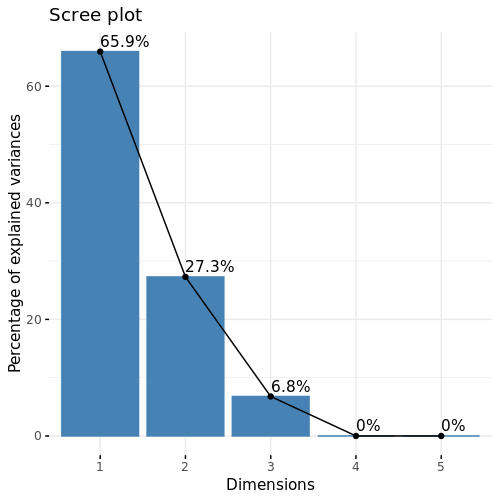

In [126]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 100)

vs_elc_pca <- PCA(vs_elc_pca_meta,quali.sup=c(6:12),graph=F)
fviz_screeplot(vs_elc_pca, addlabels = TRUE)

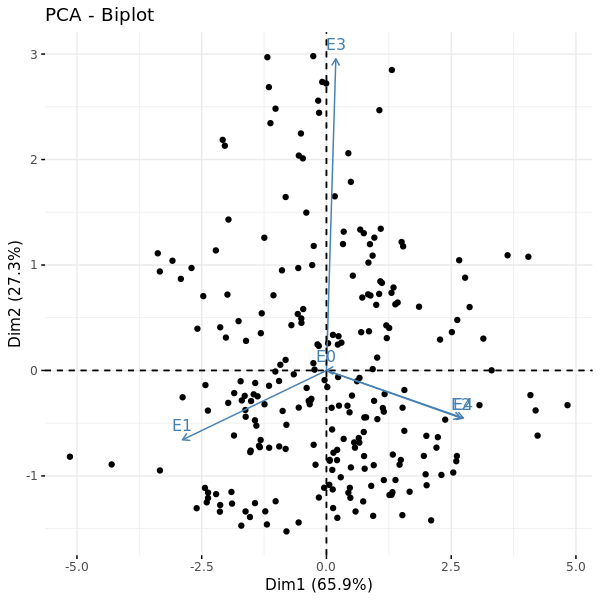

In [127]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_biplot(vs_elc_pca, repel = FALSE,geom="point")

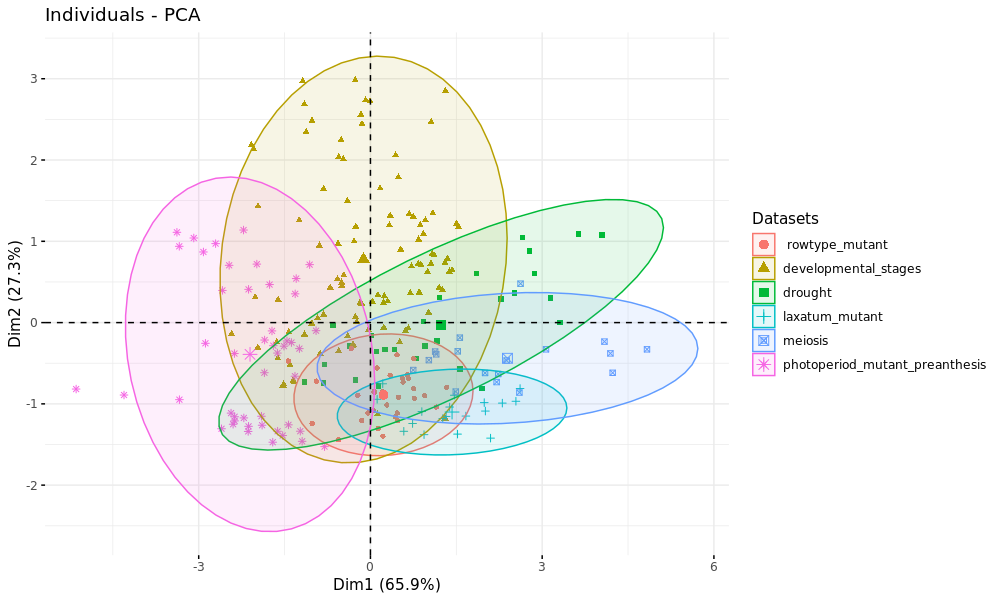

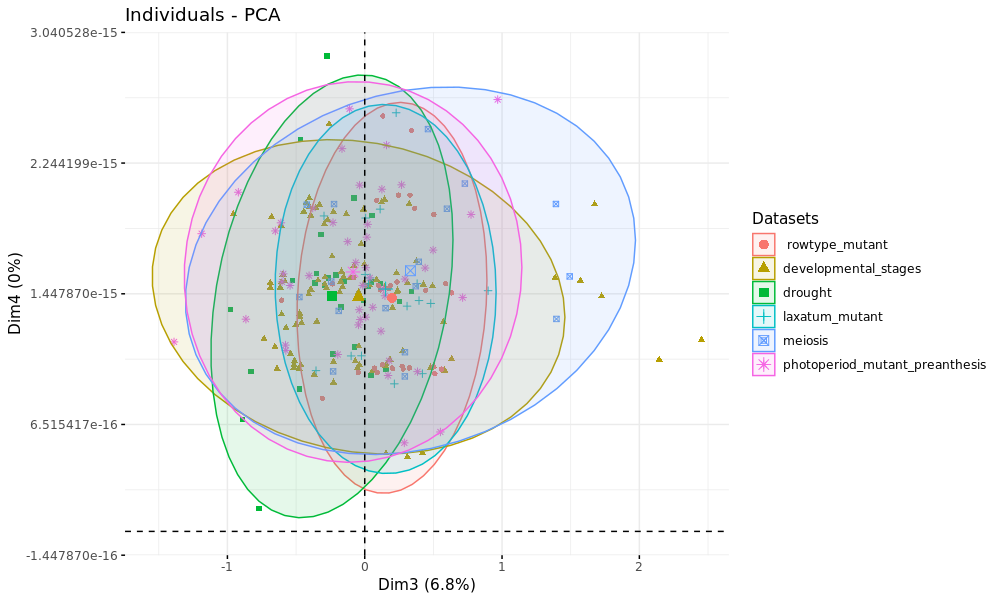

In [128]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_ind(vs_elc_pca, label = "none", habillage = vs_elc_pca_meta$dataset, legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2))
fviz_pca_ind(vs_elc_pca, label = "none", habillage = vs_elc_pca_meta$dataset, legend.title = "Datasets", addEllipses = TRUE, axes = c(3, 4))

In [169]:
# build comparism plot variables
d1 <- fviz_pca_ind(X = vs_elc_pca, label = "none", legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2), habillage = vs_elc_pca_meta$dataset) +
                scale_fill_manual(values = getPalette(colourCount))
d2 <- fviz_pca_ind(X = vs_elc_pca, geom="point", axes = c(1, 2), legend.title = "Library type", habillage = vs_elc_pca_meta$library)
d3 <- fviz_pca_ind(X = vs_elc_pca, geom="point", axes = c(1, 2), legend.title = "Instrument", habillage = vs_elc_pca_meta$instrument)
d4 <- fviz_pca_ind(X = vs_elc_pca, geom="point", axes = c(1, 2), legend.title = "High level tissue", habillage = vs_elc_pca_meta$high_level_tissue)
d5 <- fviz_pca_ind(X = vs_elc_pca, geom="point", axes = c(1, 2), legend.title = "High level age", habillage = vs_elc_pca_meta$high_level_age)

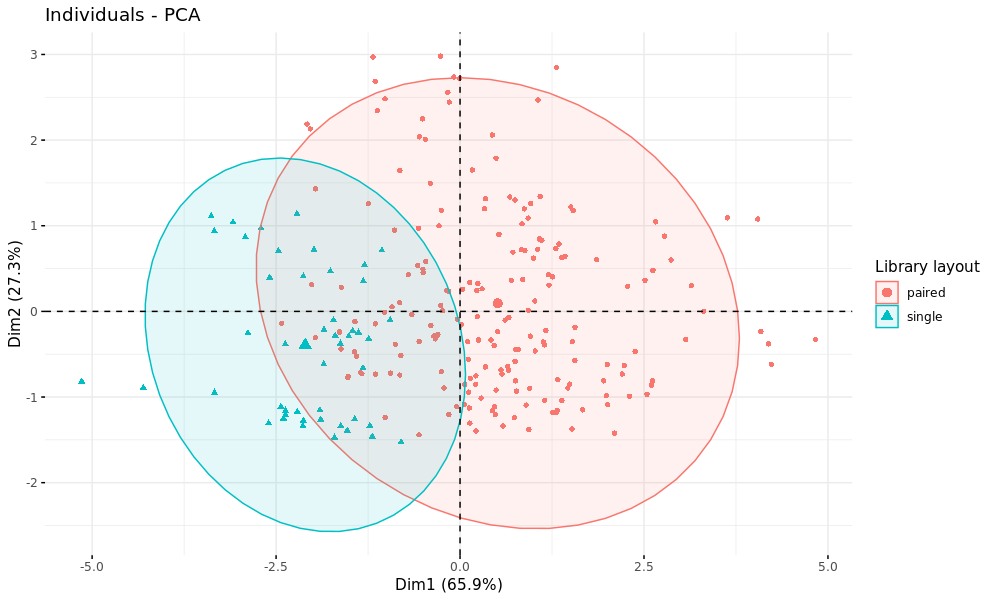

In [129]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_ind(vs_elc_pca, label = "none", habillage = vs_elc_pca_meta$library, legend.title = "Library layout", addEllipses = TRUE, axes = c(1, 2))

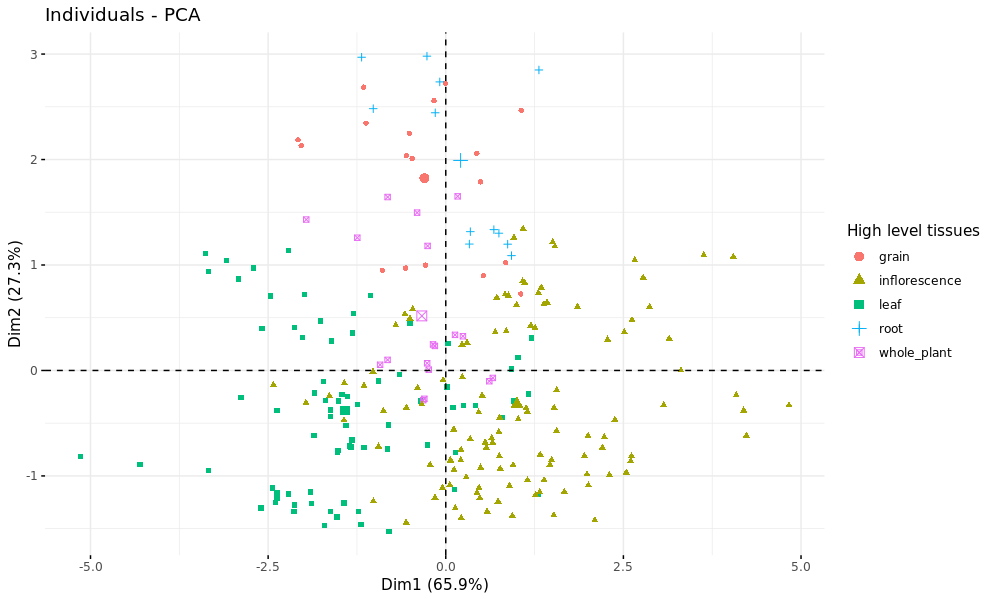

In [130]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_ind(vs_elc_pca, label = "none", habillage = vs_elc_pca_meta$high_level_tissue, legend.title = "High level tissues", axes = c(1, 2))

Dim.1       Dim.2      Dim.3        Dim.4        Dim.5
E0         NaN        NaN          NaN          NaN NaN  
E1 0.949262474 0.04925825 0.0014792713 1.391361e-30   0  
E2 0.824972939 0.02312567 0.1519013873 2.487112e-31   0  
E3 0.004025928 0.99573111 0.0002429588 2.011441e-31   0  
E4 0.859419655 0.02327424 0.1173061093 5.189379e-31   0

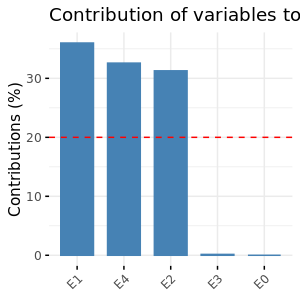

In [131]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 100)
get_pca_var(vs_elc_pca)$cos2
fviz_contrib(vs_elc_pca,"var",top=20,axis=1)

# 7. Summarizing comparism figures

In [182]:
# figure about why variance stabilization is necessary
setwd("/home/vanda.marosi/floral_development_thesis_vm/figures/")
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 300)

prow1 <- plot_grid(a1 + ggtitle("log2 TPM before VS") + theme(legend.position="none"), 
                  c1 + ggtitle("log2 TPM after VS") + theme(legend.position="none"), 
                  b1 + ggtitle("ELC before VS") + theme(legend.position="none"), 
                  d1 + ggtitle("ELC after VS") + theme(legend.position="none"), 
                   align = 'vh', hjust = -1, nrow = 1)
legend1 <- get_legend(a1 + theme(legend.box.margin = margin(0, 0, 0, 12)))

prow2 <- plot_grid(a2 + ggtitle("log2 TPM before VS") + theme(legend.position="none"), 
                  c2 + ggtitle("log2 TPM after VS") + theme(legend.position="none"), 
                  b2 + ggtitle("ELC before VS") + theme(legend.position="none"), 
                  d2 + ggtitle("ELC after VS") + theme(legend.position="none"), 
                   align = 'vh', hjust = -1, nrow = 1)
legend2 <- get_legend(a2 + theme(legend.box.margin = margin(0, 0, 0, 12)))

prow3 <- plot_grid(a3 + ggtitle("log2 TPM before VS") + theme(legend.position="none"), 
                  c3 + ggtitle("log2 TPM after VS") + theme(legend.position="none"), 
                  b3 + ggtitle("ELC before VS") + theme(legend.position="none"), 
                  d3 + ggtitle("ELC after VS") + theme(legend.position="none"), 
                   align = 'vh', hjust = -1, nrow = 1)
legend3 <- get_legend(a3 + theme(legend.box.margin = margin(0, 0, 0, 12)))

prow4 <- plot_grid(a4 + ggtitle("log2 TPM before VS") + theme(legend.position="none"), 
                  c4 + ggtitle("log2 TPM after VS") + theme(legend.position="none"), 
                  b4 + ggtitle("ELC before VS") + theme(legend.position="none"), 
                  d4 + ggtitle("ELC after VS") + theme(legend.position="none"), 
                   align = 'vh', hjust = -1, nrow = 1)
legend4 <- get_legend(a4 + theme(legend.box.margin = margin(0, 0, 0, 12)))

prow5 <- plot_grid(a5 + ggtitle("log2 TPM before VS") + theme(legend.position="none"), 
                  c5 + ggtitle("log2 TPM after VS") + theme(legend.position="none"), 
                  b5 + ggtitle("ELC before VS") + theme(legend.position="none"), 
                  d5 + ggtitle("ELC after VS") + theme(legend.position="none"), 
                   align = 'vh', hjust = -1, nrow = 1)
legend5 <- get_legend(a5 + theme(legend.box.margin = margin(0, 0, 0, 12)))
# to save as a png
#png("stabilized_counts.png", units="in", width=10, height=4, res=300)
#cowplot::plot_grid(p1$gg + ggtitle("TPM") + scale_x_continuous(breaks =c(0, 25000, 75000, 125000)), p2$gg + ggtitle("log10(TPM)"), p3$gg + ggtitle("Variance Stabilized counts"), ncol = 3)
#dev.off()

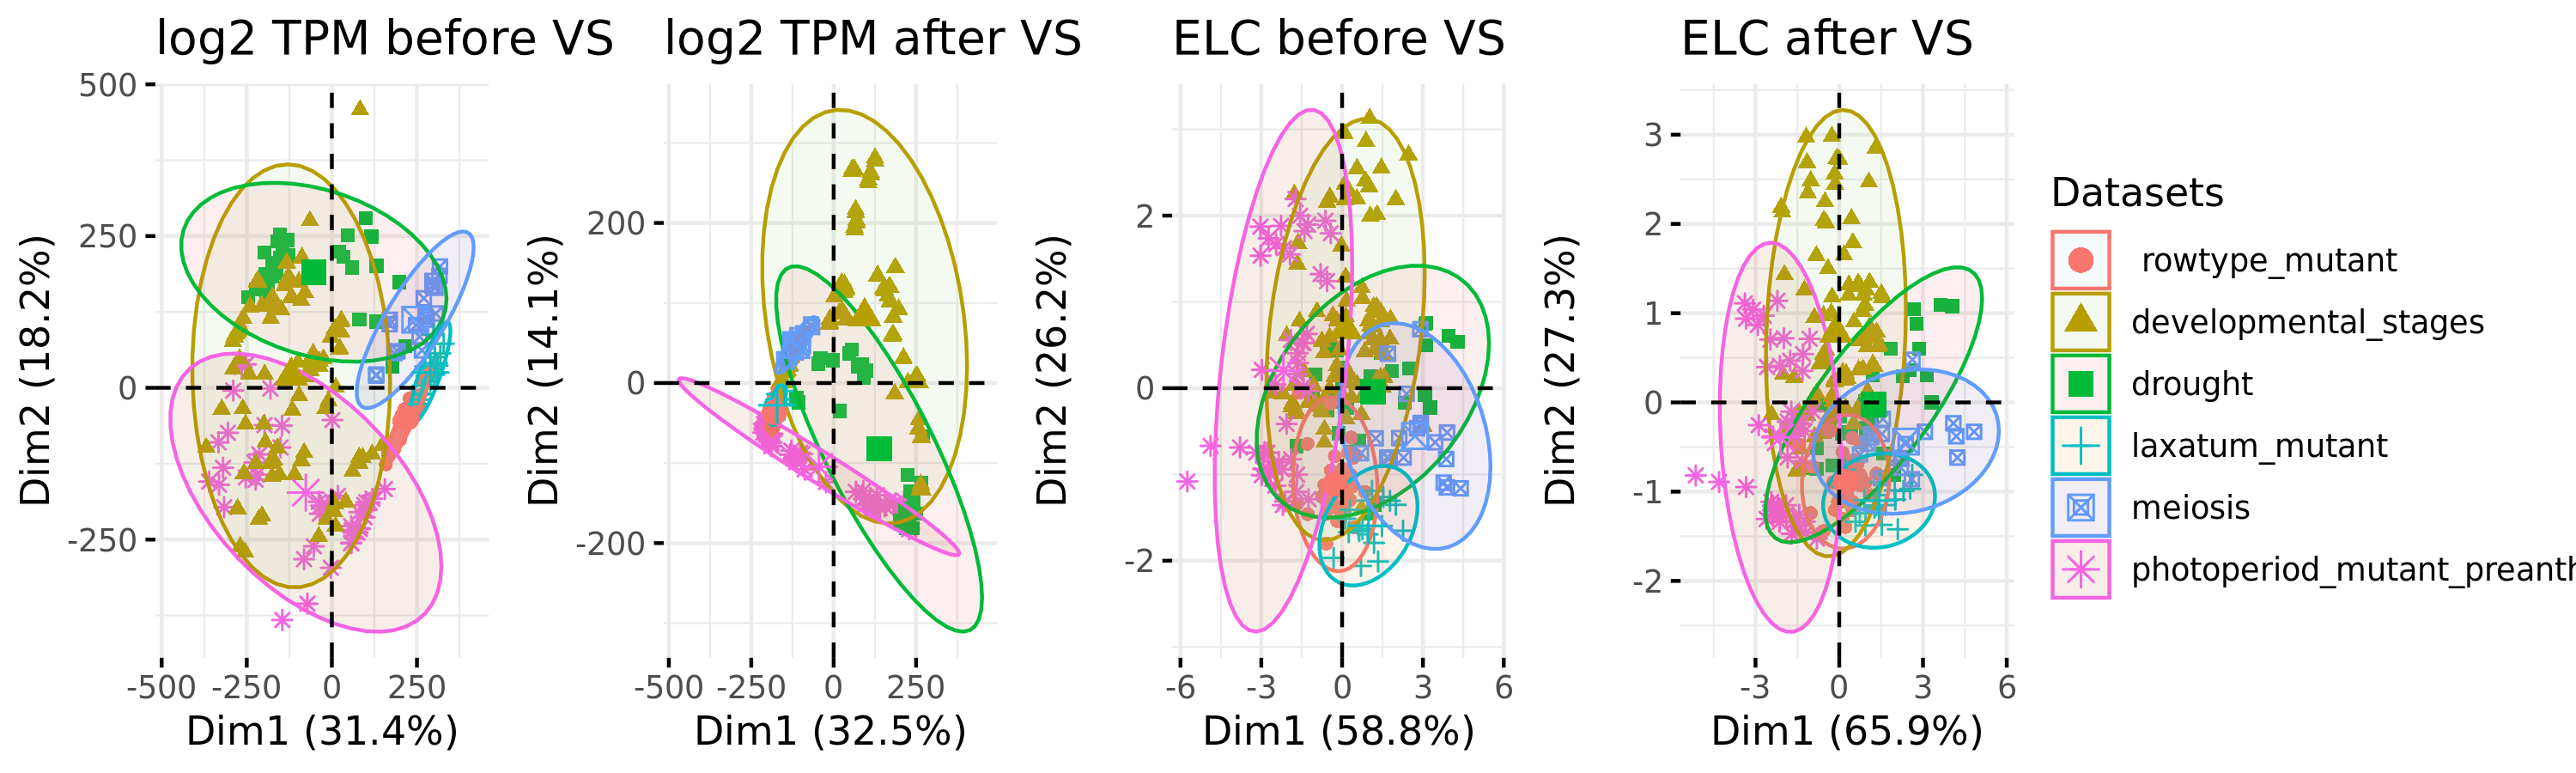

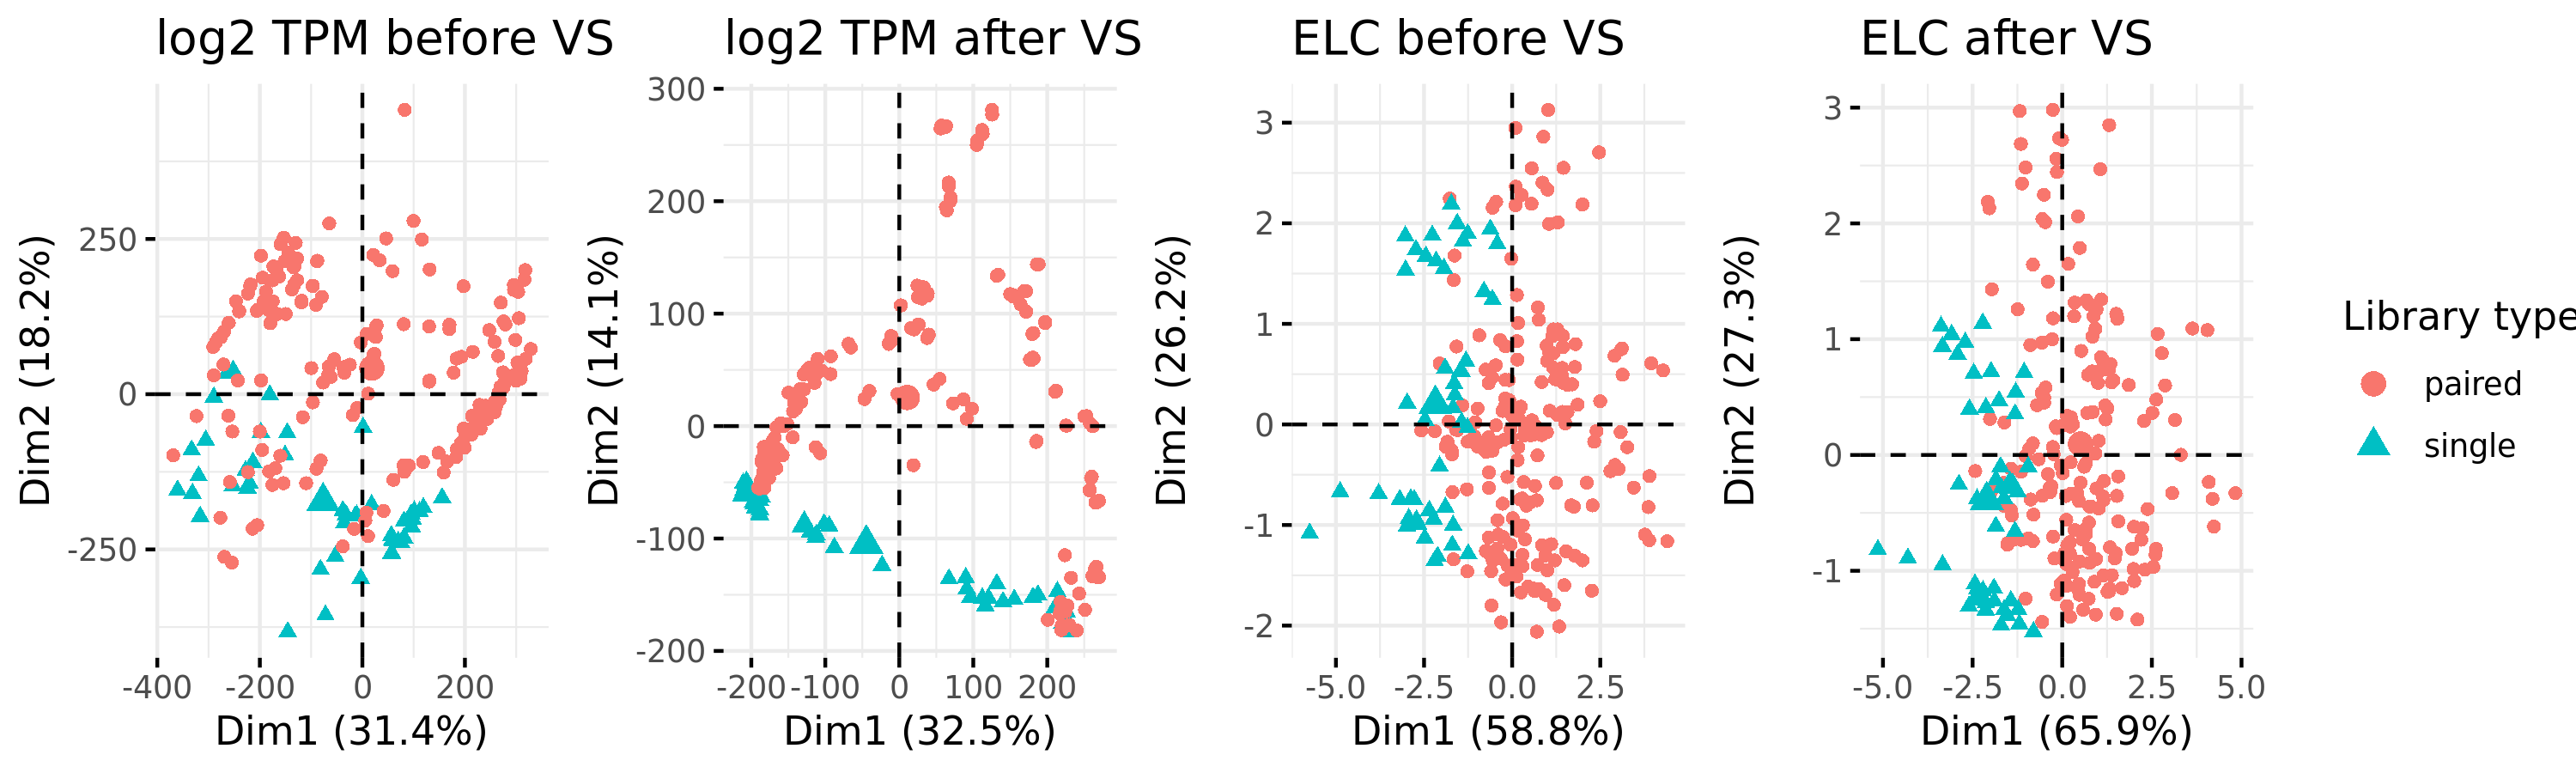

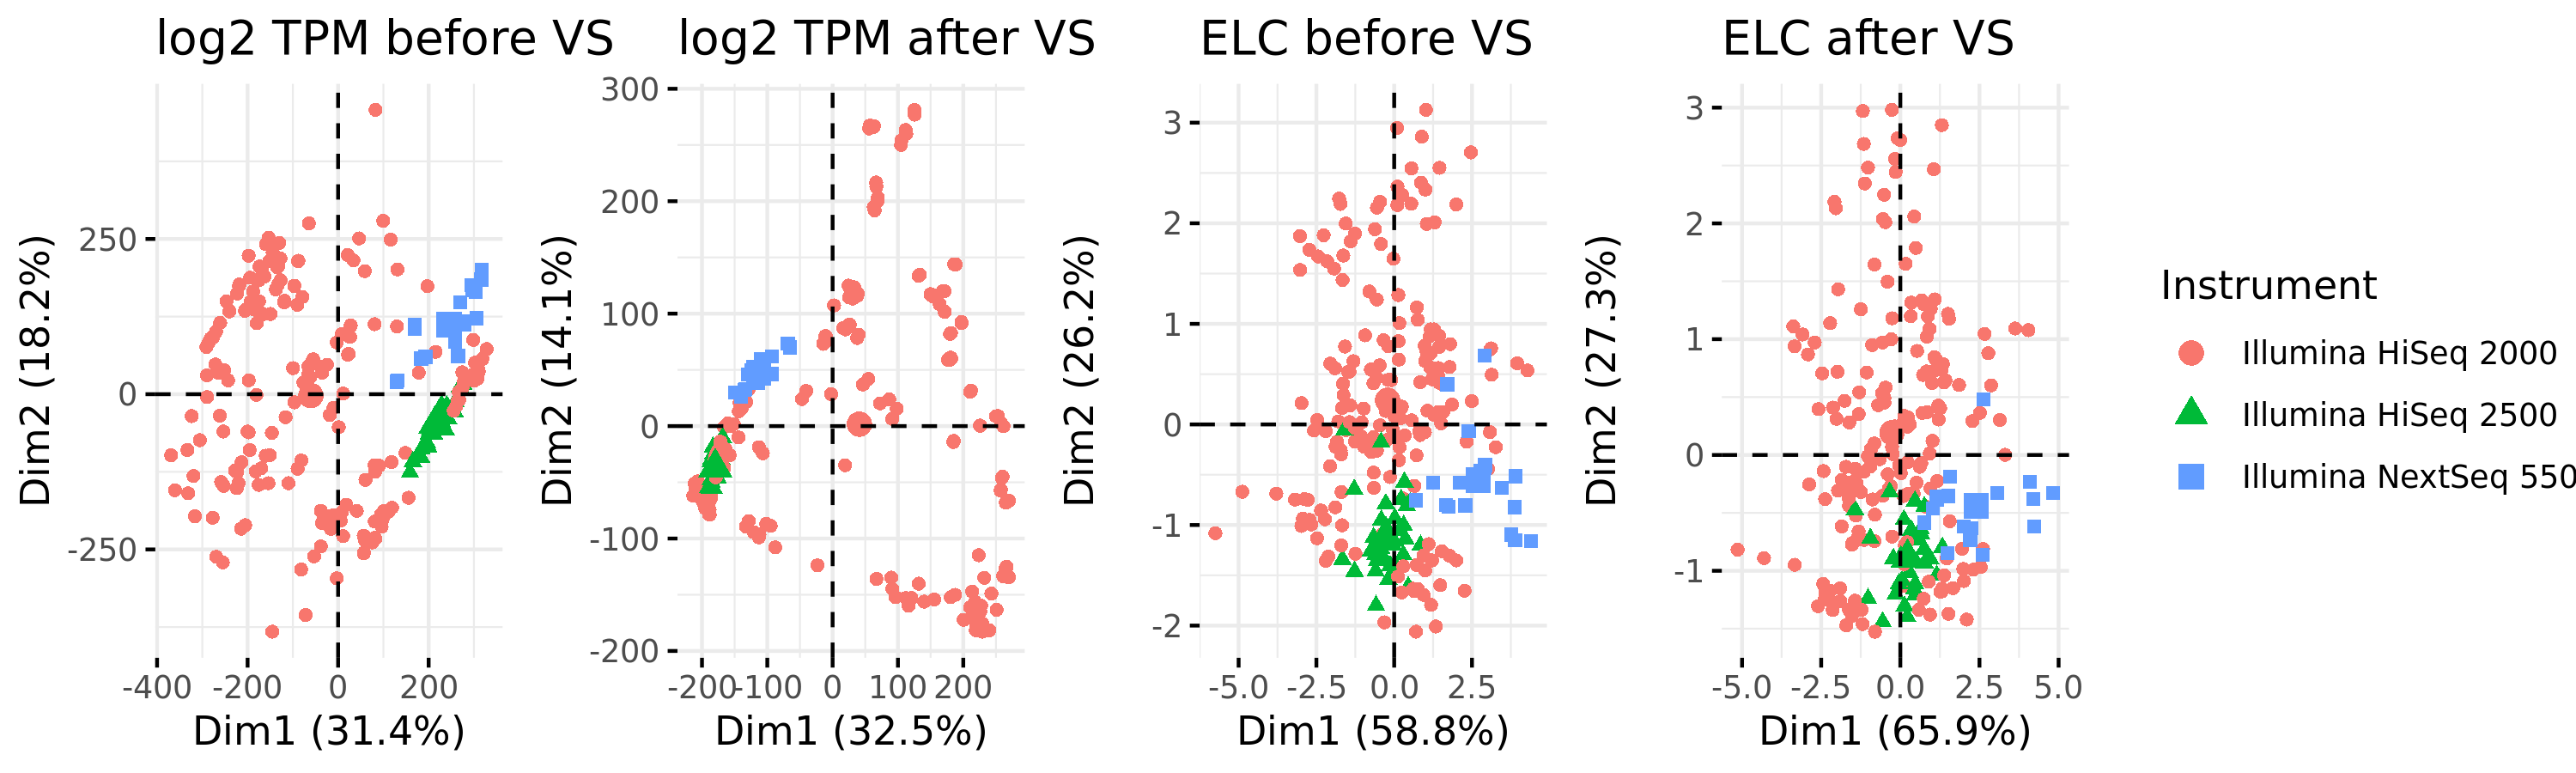

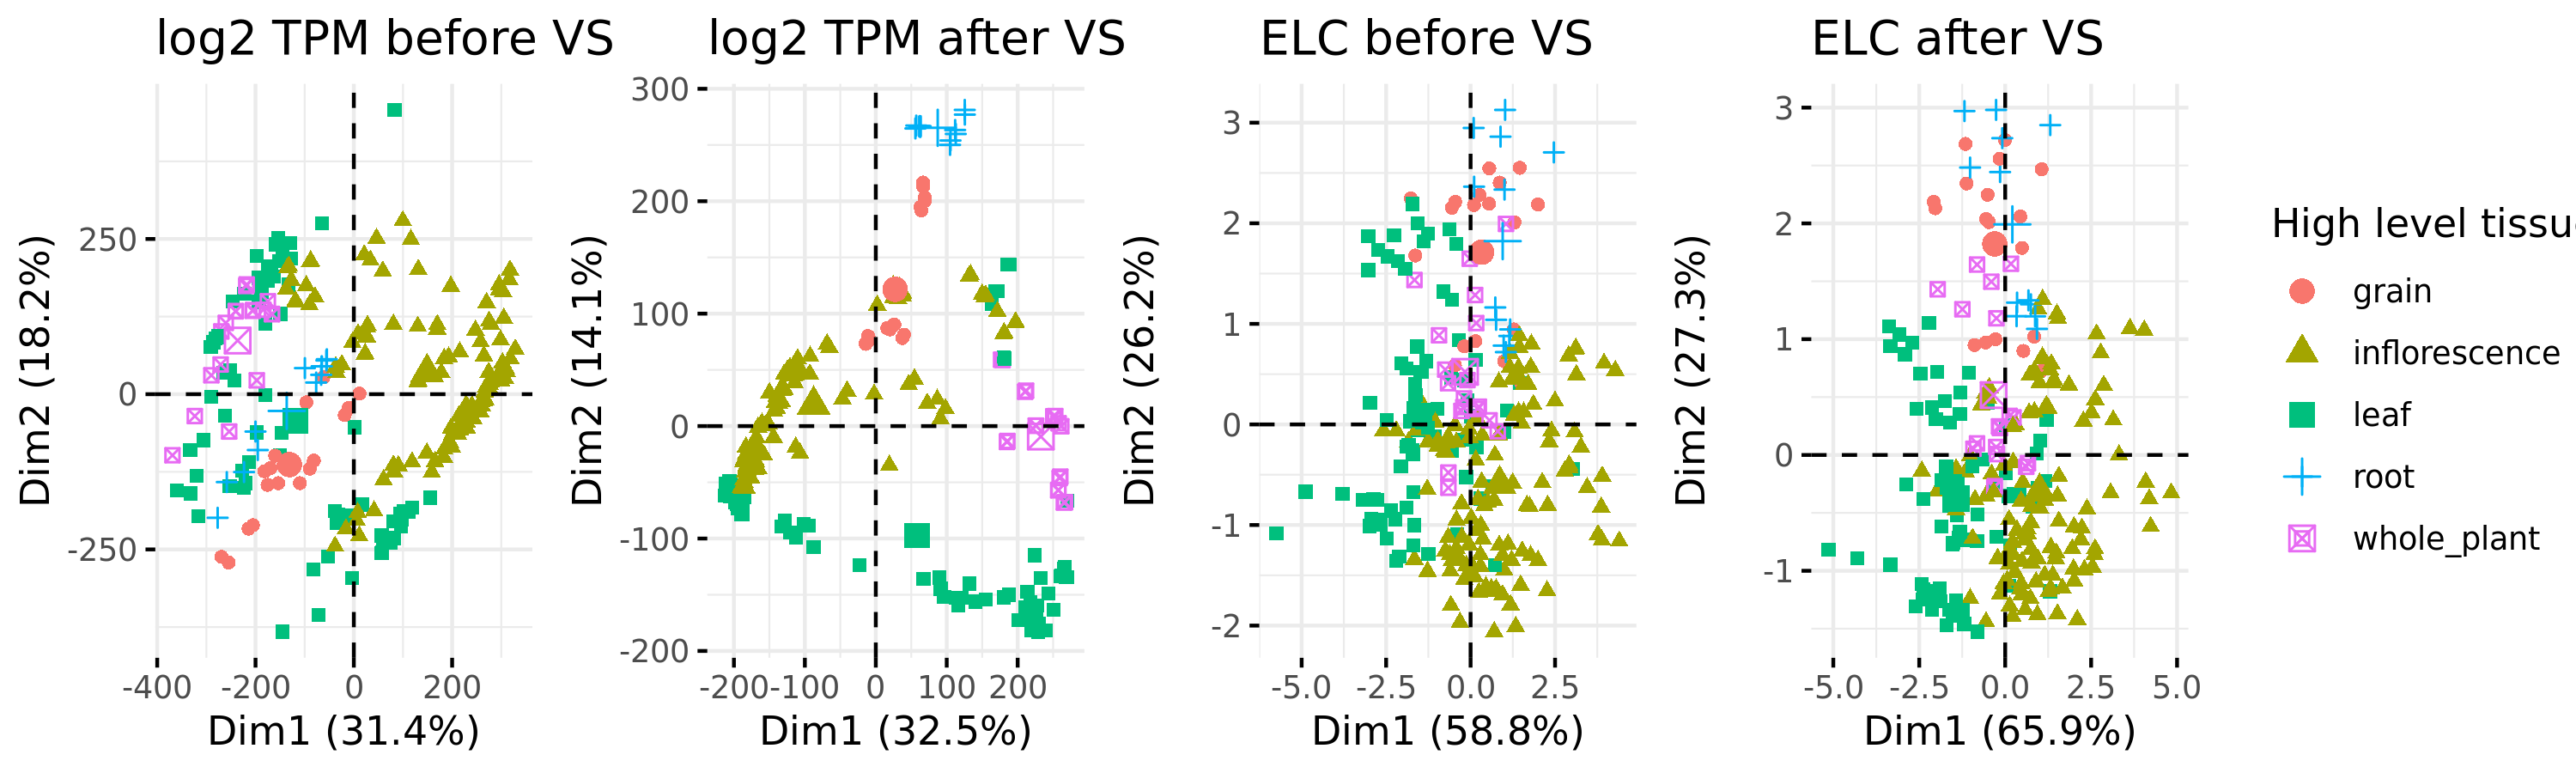

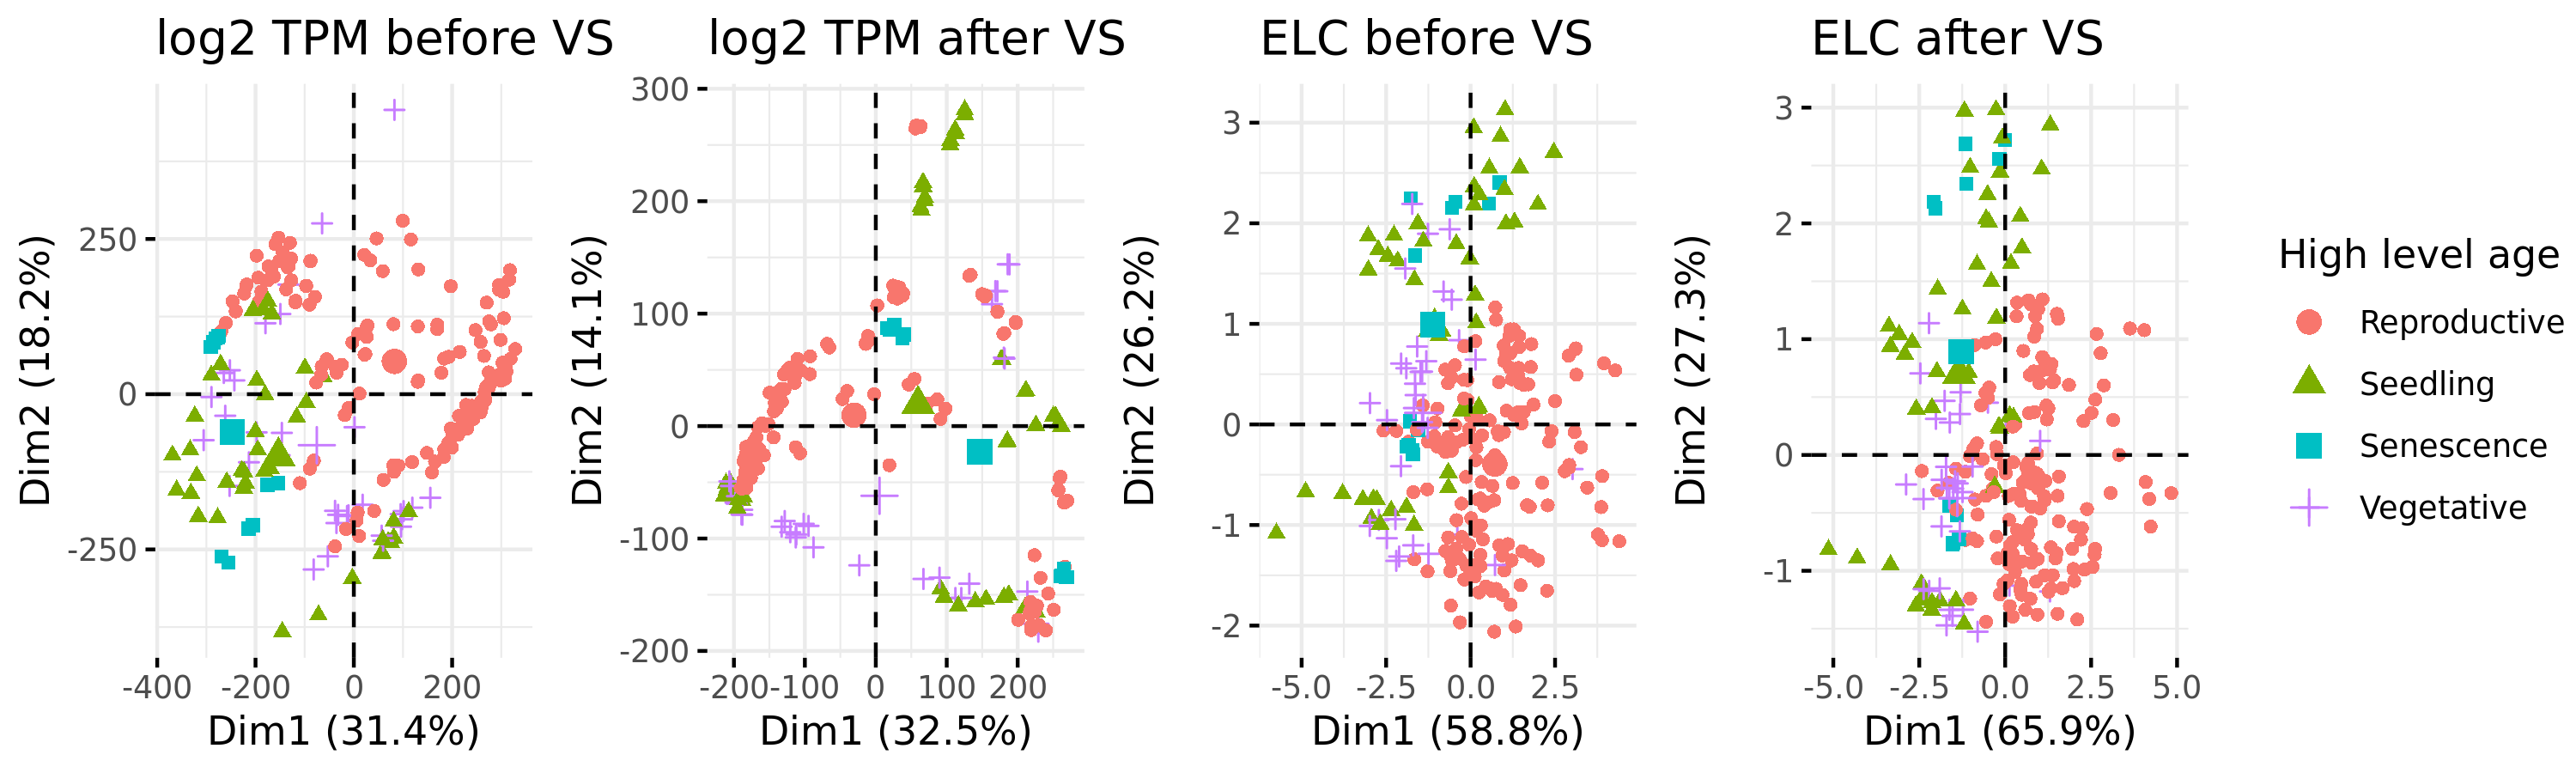

In [183]:
cowplot::plot_grid(prow1, legend1, rel_widths = c(3, .8))
cowplot::plot_grid(prow2, legend2, rel_widths = c(3, .4))
cowplot::plot_grid(prow3, legend3, rel_widths = c(3, .7))
cowplot::plot_grid(prow4, legend4, rel_widths = c(3, .5))
cowplot::plot_grid(prow5, legend5, rel_widths = c(3, .5))

In [139]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/vanda.marosi/anaconda3/envs/r/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_DE.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_DE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_DE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] viridis_0.5.1               viridisLite_0.3.0          
 [3] RColorBrewer_1.1-2          edgeR_3.28.0               
 [5] limma_3.42.0                factoextra_1.0.7           
 [7] FactoMineR_2.3              hexbin_1.27.2              
 [9] vsn_3.54.0              